In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

###### 他社債務(60か月)

## 参考
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

## モジュールとCSVの読み込み

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7839818617965139382
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2223208982343685739
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA RTX A2000 Laptop GPU


In [5]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
app_br_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train_br_all-domein_60-monthes.csv') 
app_br_test_origin = pd.read_csv('./home-credit-default-risk/exports/app_test_br_all-domein_60-monthes.csv')
#POS_CASH_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
#previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
#installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
#app_br_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_Loan_From_other_banks_cash-consumer-loans.csv')
#app_br_test_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_Loan_From_other_banks_cash-consumer-loans.csv')
#app_train_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_overdue_hist.csv')
#app_test_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_overdue_hist.csv')
#app_train_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_debt_credit_ratio_none.csv')
#app_test_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_debt_credit_ratio_none.csv')

app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

In [7]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
bureau_balance = bureau_balance_origin.copy()
app_br_train = app_br_train_origin.copy()
app_br_test = app_br_test_origin.copy()

In [8]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 他金融機関での借り入れ情報(bureau)前処理

In [9]:
len(app_train)

307511

In [10]:
len(app_test)

48744

In [11]:
len(app_br_train)

91932

In [12]:
len(app_br_test)

42311

In [13]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
app_train = app_train[['SK_ID_CURR','TARGET']].copy()
app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

In [14]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

In [15]:
# trainへマージ
app_train = pd.merge(app_train, app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

### br_min_credit_day_overdue

In [16]:
app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

TARGET  br_min_credit_day_overdue
TARGET                     1.000000                   0.009145
br_min_credit_day_overdue  0.009145                   1.000000

The correlation between br_min_credit_day_overdue and the TARGET is 0.0091
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


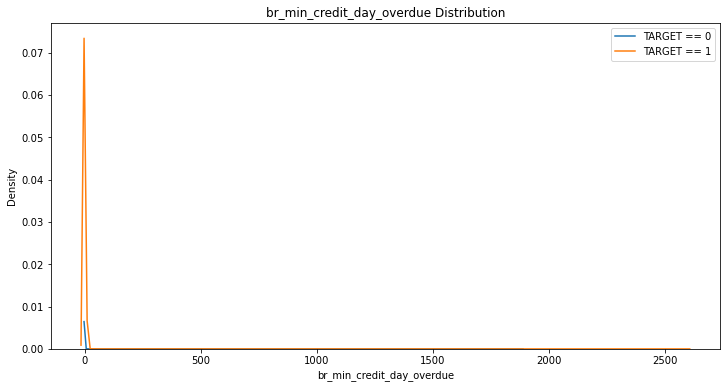

In [17]:
kde_target('br_min_credit_day_overdue', app_train)

In [18]:
## Yao-Johnson変換
#num_cols = ['br_min_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [19]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

### br_max_credit_day_overdue

In [20]:
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                   0.000438
br_max_credit_day_overdue  0.000438                   1.000000

The correlation between br_max_credit_day_overdue and the TARGET is 0.0004
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


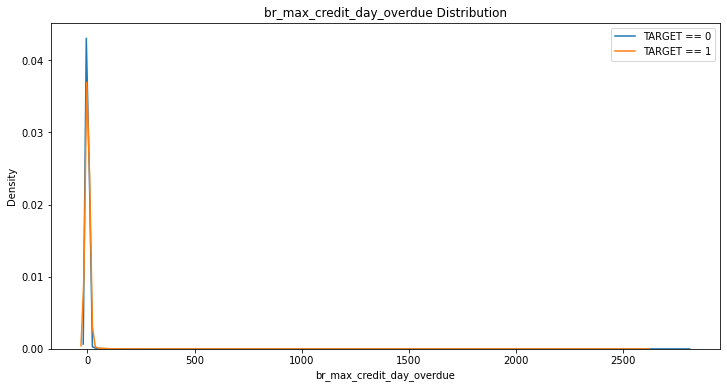

In [21]:
kde_target('br_max_credit_day_overdue', app_train)

In [22]:
## Yao-Johnson変換
num_cols = ['br_max_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [23]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                   0.032556
br_max_credit_day_overdue  0.032556                   1.000000

The correlation between br_max_credit_day_overdue and the TARGET is 0.0326
Median value for loan that was not repaid = -0.1131
Median value for loan that was repaid =     -0.1131


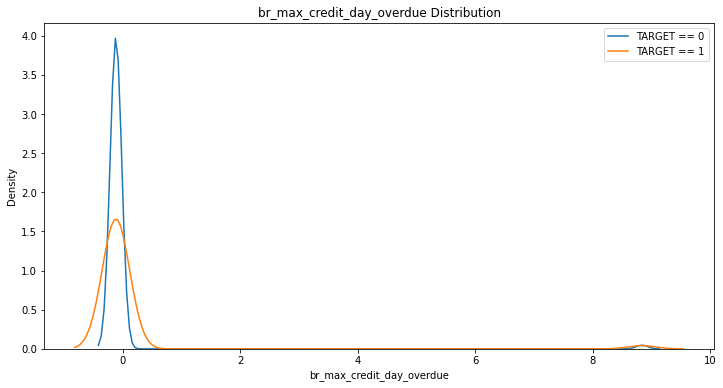

In [24]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_credit_day_overdue', app_train)

### br_sum_credit_day_overdue

In [25]:
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                  -0.002364
br_sum_credit_day_overdue -0.002364                   1.000000

The correlation between br_sum_credit_day_overdue and the TARGET is -0.0024
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


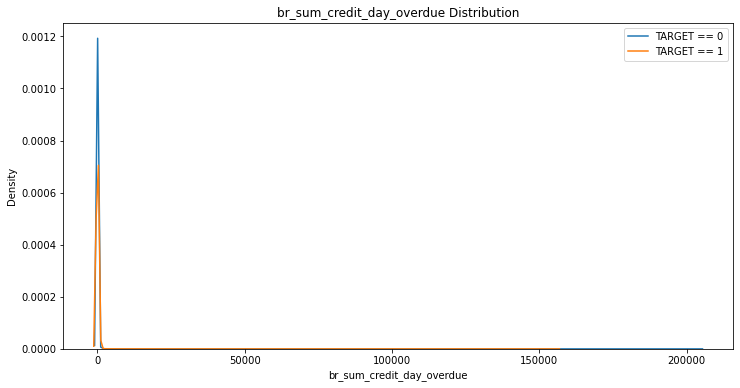

In [26]:
kde_target('br_sum_credit_day_overdue', app_train)

In [27]:
## Yao-Johnson変換
num_cols = ['br_sum_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [28]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                   0.032556
br_sum_credit_day_overdue  0.032556                   1.000000

The correlation between br_sum_credit_day_overdue and the TARGET is 0.0326
Median value for loan that was not repaid = -0.1131
Median value for loan that was repaid =     -0.1131


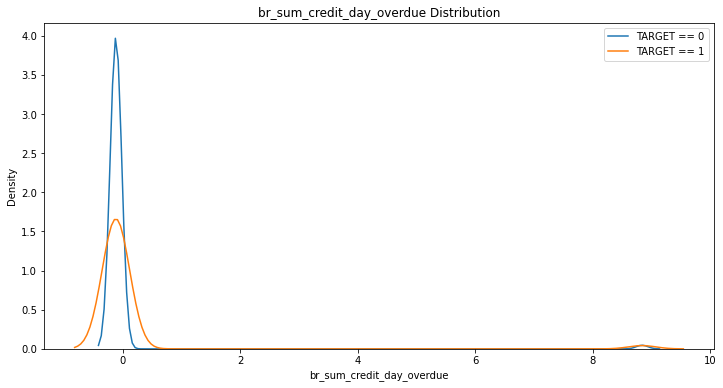

In [29]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_credit_day_overdue', app_train)

### br_avg_credit_day_overdue

In [30]:
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.003352
br_avg_credit_day_overdue  0.003352                   1.000000

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0034
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


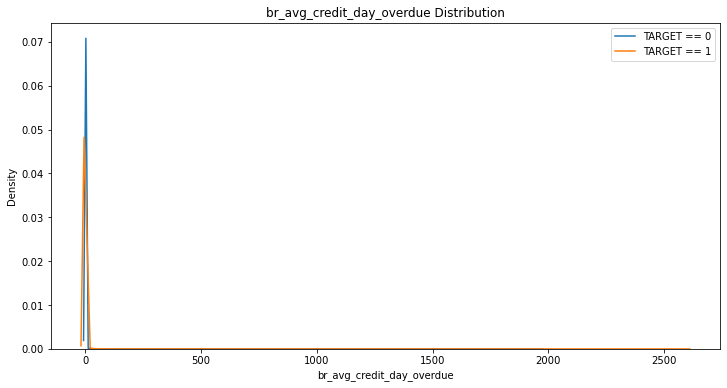

In [31]:
kde_target('br_avg_credit_day_overdue', app_train)

In [32]:
## Yao-Johnson変換
num_cols = ['br_avg_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [33]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.032616
br_avg_credit_day_overdue  0.032616                   1.000000

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0326
Median value for loan that was not repaid = -0.1131
Median value for loan that was repaid =     -0.1131


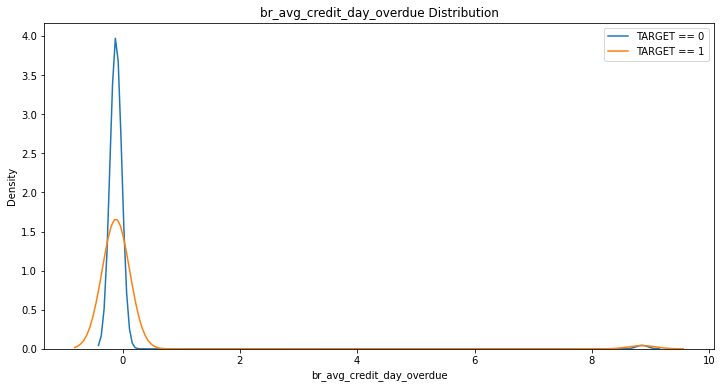

In [34]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_credit_day_overdue', app_train)

### br_cnt_credit_day_overdue

In [35]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.040412
br_cnt_credit_day_overdue -0.040412                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


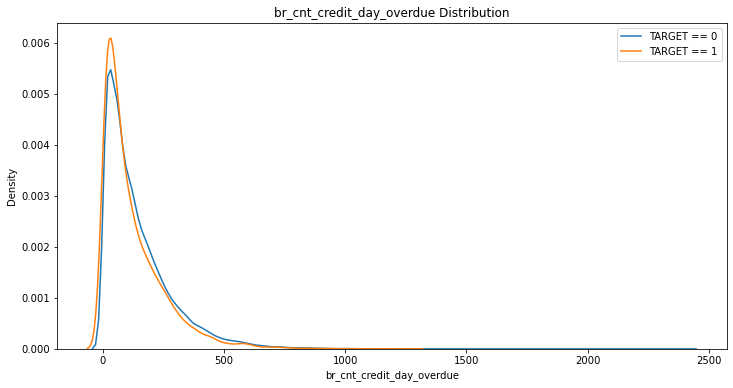

In [36]:
kde_target('br_cnt_credit_day_overdue', app_train)

In [37]:
## Yao-Johnson変換
num_cols = ['br_cnt_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [38]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.052954
br_cnt_credit_day_overdue -0.052954                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0530
Median value for loan that was not repaid = -0.1841
Median value for loan that was repaid =     0.0410


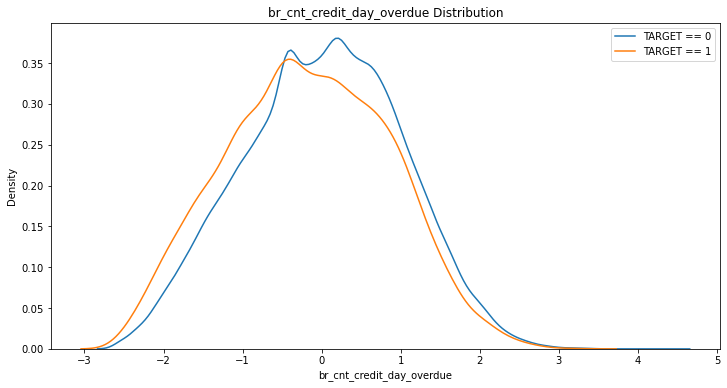

In [39]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_credit_day_overdue', app_train)

### br_stddev_credit_day_overdue

In [40]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.00000                      -0.00256
br_stddev_credit_day_overdue -0.00256                       1.00000

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


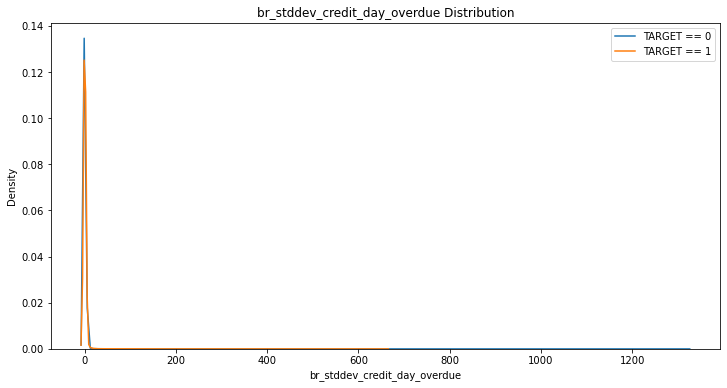

In [41]:
kde_target('br_stddev_credit_day_overdue', app_train)

In [42]:
## Yao-Johnson変換
num_cols = ['br_stddev_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [43]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                      0.031158
br_stddev_credit_day_overdue  0.031158                      1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is 0.0312
Median value for loan that was not repaid = -0.1106
Median value for loan that was repaid =     -0.1106


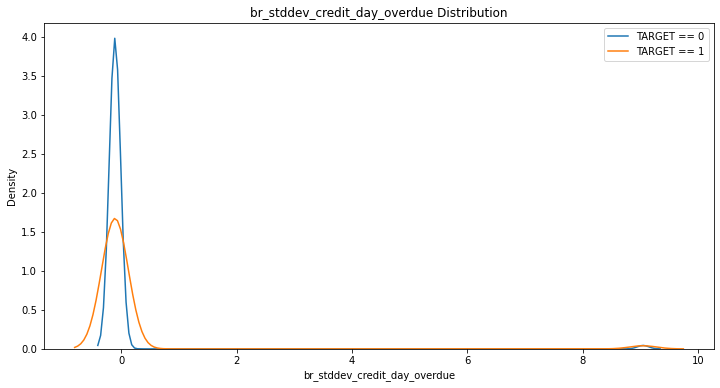

In [44]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_credit_day_overdue', app_train)

### br_stddev_pop_credit_day_overdue

In [45]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.00000                          -0.00256
br_stddev_pop_credit_day_overdue -0.00256                           1.00000

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


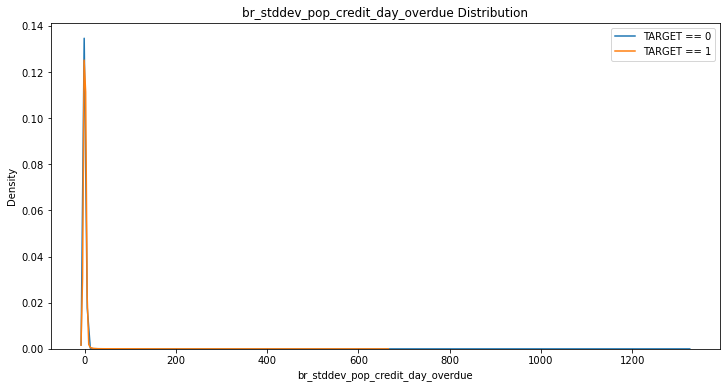

In [46]:
kde_target('br_stddev_pop_credit_day_overdue', app_train)

In [47]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [48]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                          0.031158
br_stddev_pop_credit_day_overdue  0.031158                          1.000000

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is 0.0312
Median value for loan that was not repaid = -0.1106
Median value for loan that was repaid =     -0.1106


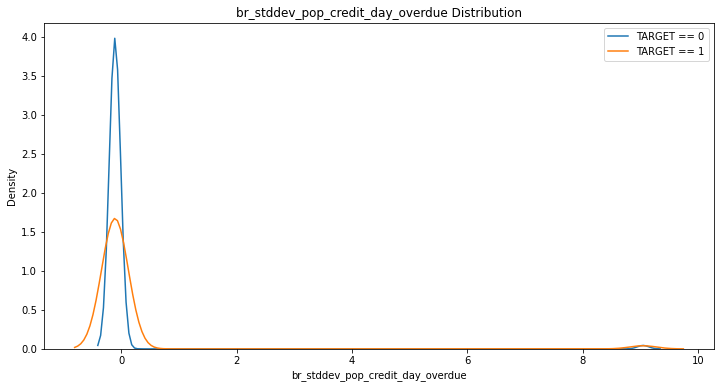

In [49]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_credit_day_overdue', app_train)

### br_var_pop_credit_day_overdue

In [50]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.004867
br_var_pop_credit_day_overdue -0.004867                       1.000000

The correlation between br_var_pop_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


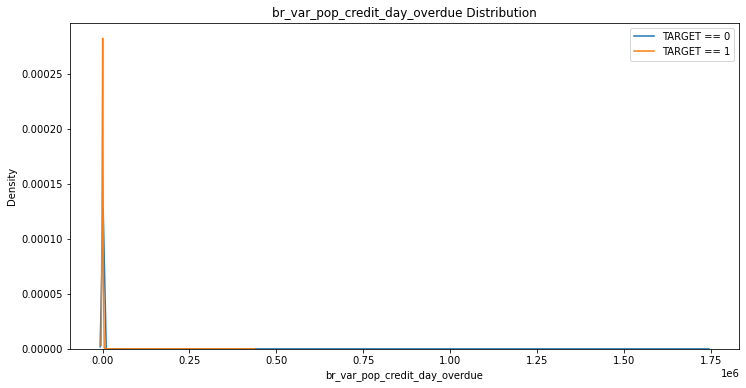

In [51]:
kde_target('br_var_pop_credit_day_overdue', app_train)

In [52]:
## Yao-Johnson変換
num_cols = ['br_var_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [53]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                       0.031218
br_var_pop_credit_day_overdue  0.031218                       1.000000

The correlation between br_var_pop_credit_day_overdue and the TARGET is 0.0312
Median value for loan that was not repaid = -0.1105
Median value for loan that was repaid =     -0.1105


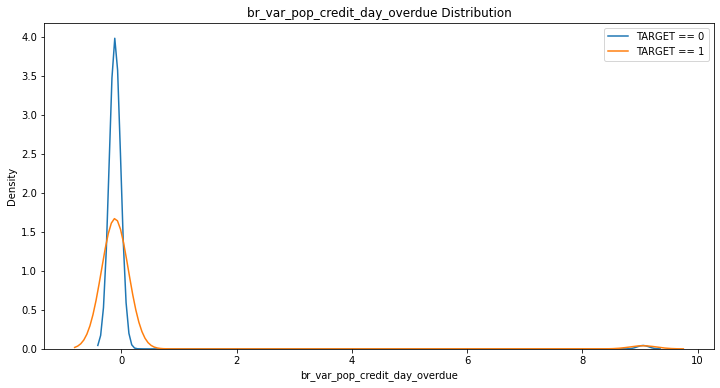

In [54]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_credit_day_overdue', app_train)

### br_var_samp_credit_day_overdue

In [55]:
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                       -0.004863
br_var_samp_credit_day_overdue -0.004863                        1.000000

The correlation between br_var_samp_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


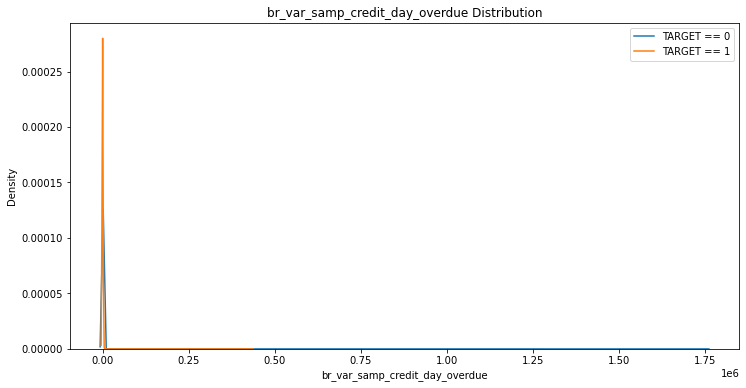

In [56]:
kde_target('br_var_samp_credit_day_overdue', app_train)

In [57]:
## Yao-Johnson変換
num_cols = ['br_var_samp_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [58]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                        0.031218
br_var_samp_credit_day_overdue  0.031218                        1.000000

The correlation between br_var_samp_credit_day_overdue and the TARGET is 0.0312
Median value for loan that was not repaid = -0.1105
Median value for loan that was repaid =     -0.1105


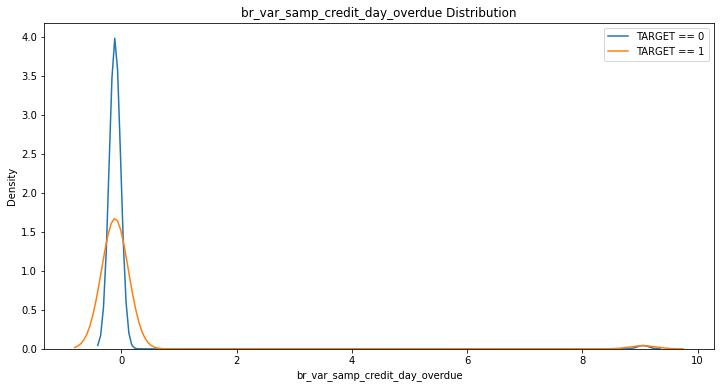

In [59]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_credit_day_overdue', app_train)

### br_variance_pop_credit_day_overdue

In [60]:
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue -0.004867   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                       -0.004867  
br_variance_pop_credit_day_overdue                            1.000000

The correlation between br_variance_pop_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


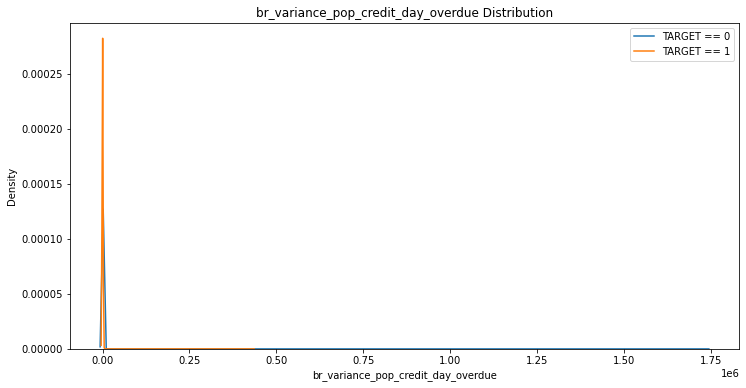

In [61]:
kde_target('br_variance_pop_credit_day_overdue', app_train)

In [62]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [63]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue  0.031218   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                        0.031218  
br_variance_pop_credit_day_overdue                            1.000000

The correlation between br_variance_pop_credit_day_overdue and the TARGET is 0.0312
Median value for loan that was not repaid = -0.1105
Median value for loan that was repaid =     -0.1105


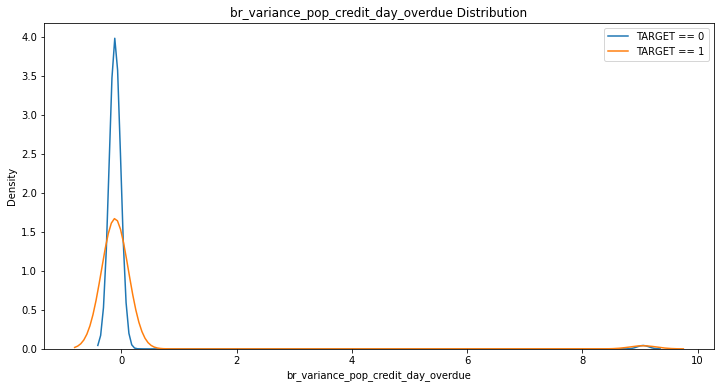

In [64]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_credit_day_overdue', app_train)

### br_min_days_credit_enddate

In [65]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.037033
br_min_days_credit_enddate  0.037033                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0370
Median value for loan that was not repaid = -843.0000
Median value for loan that was repaid =     -1117.0000


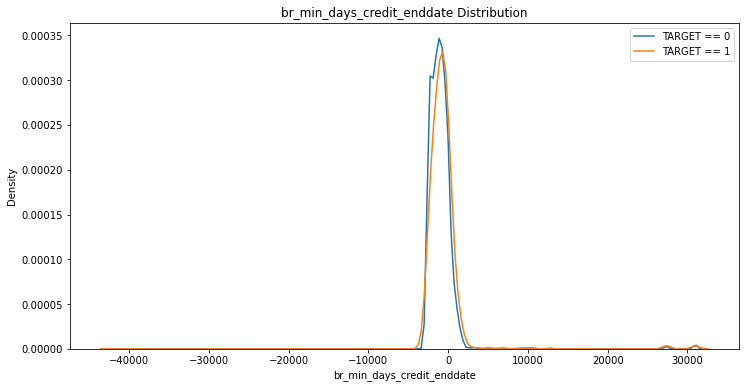

In [66]:
kde_target('br_min_days_credit_enddate', app_train)

In [67]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [68]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.054605
br_min_days_credit_enddate  0.054605                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0546
Median value for loan that was not repaid = 0.2924
Median value for loan that was repaid =     0.0223


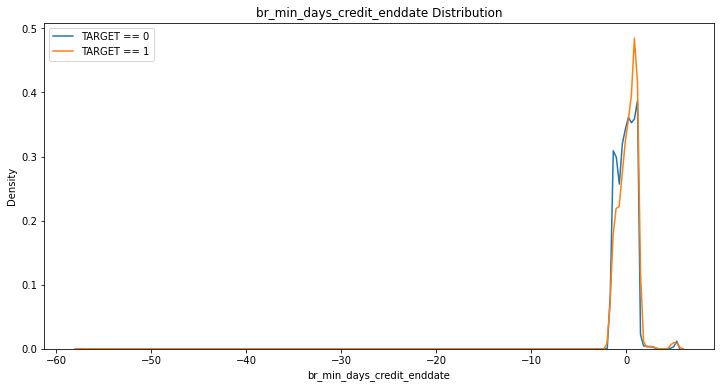

In [69]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_enddate', app_train)

### br_max_days_credit_enddate

In [70]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.036183
br_max_days_credit_enddate  0.036183                    1.000000

The correlation between br_max_days_credit_enddate and the TARGET is 0.0362
Median value for loan that was not repaid = 1114.0000
Median value for loan that was repaid =     924.0000


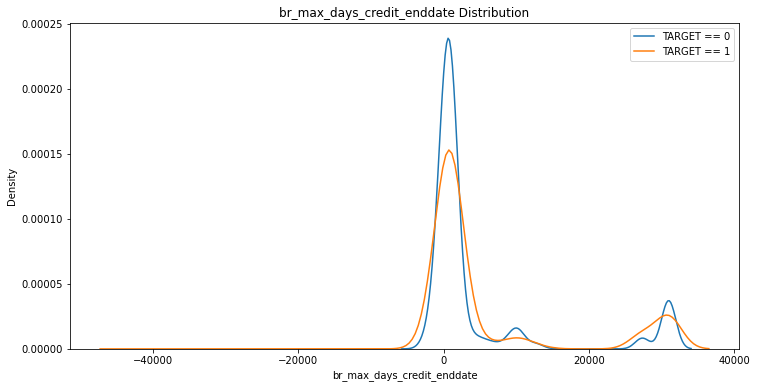

In [71]:
kde_target('br_max_days_credit_enddate', app_train)

In [72]:
## Yao-Johnson変換
#num_cols = ['br_max_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_max_days_credit_enddate'] = pt.transform(app_test[num_cols])


In [73]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

In [74]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_days_credit_enddate', app_train)

### br_sum_days_credit_enddate

In [75]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.024731
br_sum_days_credit_enddate  0.024731                    1.000000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0247
Median value for loan that was not repaid = 11.0000
Median value for loan that was repaid =     -12434.0000


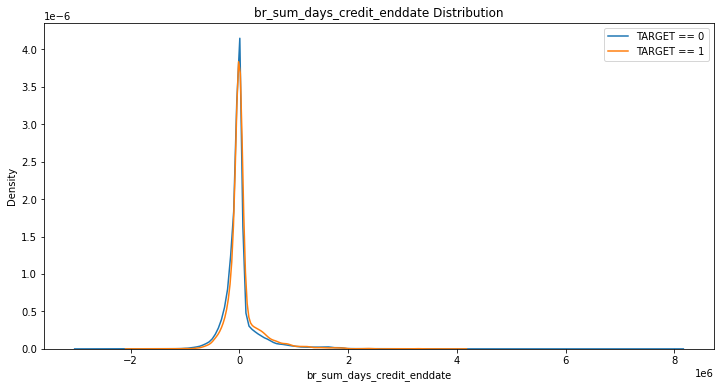

In [76]:
kde_target('br_sum_days_credit_enddate', app_train)

In [77]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [78]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.039714
br_sum_days_credit_enddate  0.039714                    1.000000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0397
Median value for loan that was not repaid = 0.2150
Median value for loan that was repaid =     0.1590


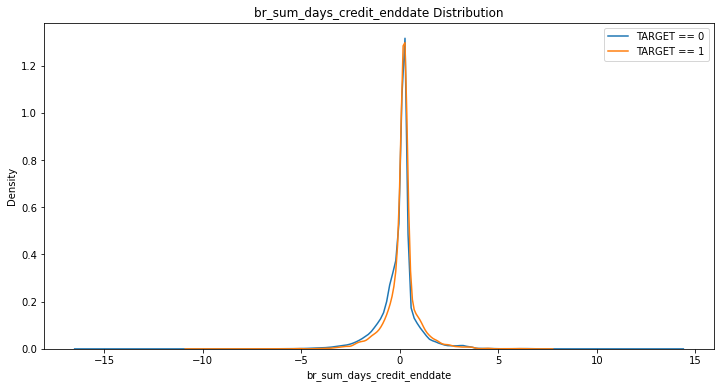

In [79]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_enddate', app_train)

### br_avg_days_credit_enddate

In [80]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.043261
br_avg_days_credit_enddate  0.043261                    1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0433
Median value for loan that was not repaid = 2.1707
Median value for loan that was repaid =     -224.0000


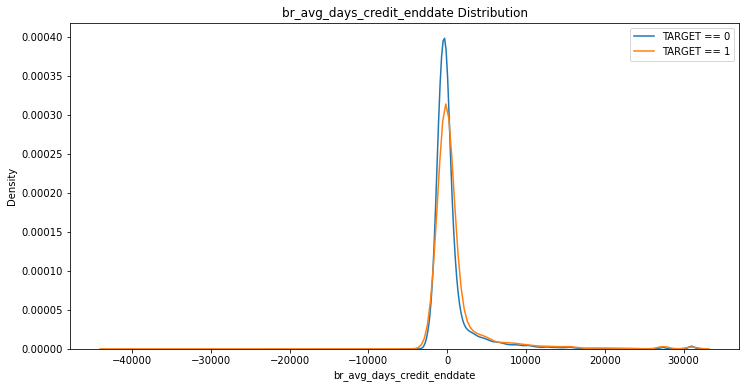

In [81]:
kde_target('br_avg_days_credit_enddate', app_train)

In [82]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [83]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.054592
br_avg_days_credit_enddate  0.054592                    1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0546
Median value for loan that was not repaid = 0.3176
Median value for loan that was repaid =     0.1107


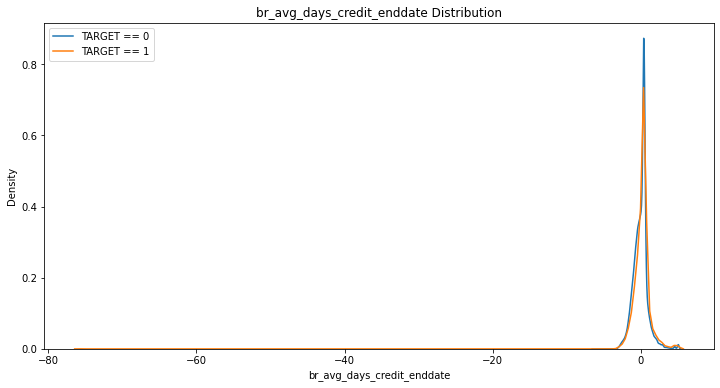

In [84]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_enddate', app_train)

### br_cnt_days_credit_enddate

In [85]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.043187
br_cnt_days_credit_enddate -0.043187                    1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0432
Median value for loan that was not repaid = 74.0000
Median value for loan that was repaid =     96.0000


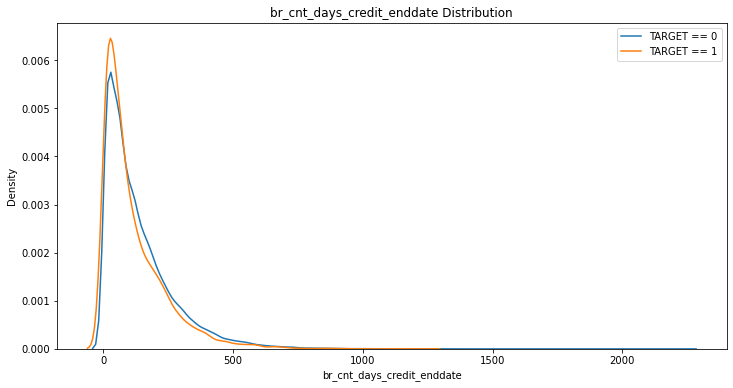

In [86]:
kde_target('br_cnt_days_credit_enddate', app_train)

In [87]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_enddate'] = pt.transform(app_test[num_cols])


In [88]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.055803
br_cnt_days_credit_enddate -0.055803                    1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0558
Median value for loan that was not repaid = -0.1993
Median value for loan that was repaid =     0.0341


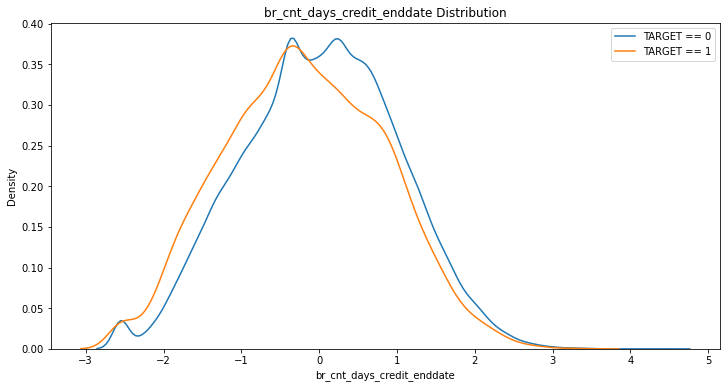

In [89]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_enddate', app_train)

### br_stddev_days_credit_enddate

In [90]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.025279
br_stddev_days_credit_enddate  0.025279                       1.000000

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0253
Median value for loan that was not repaid = 667.5509
Median value for loan that was repaid =     672.7729


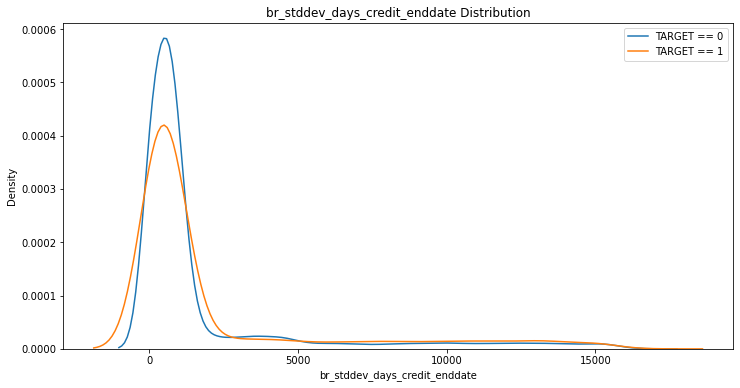

In [91]:
kde_target('br_stddev_days_credit_enddate', app_train)

In [92]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [93]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

In [94]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_days_credit_enddate', app_train)

### br_stddev_pop_days_credit_enddate

In [95]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.025279
br_stddev_pop_days_credit_enddate  0.025279                           1.000000

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0253
Median value for loan that was not repaid = 667.5509
Median value for loan that was repaid =     672.7729


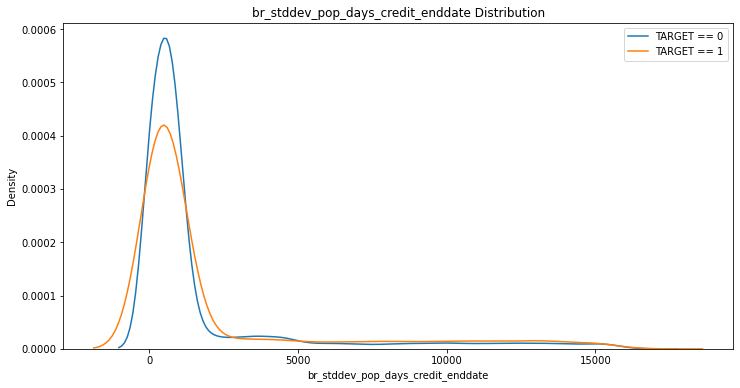

In [96]:
kde_target('br_stddev_pop_days_credit_enddate', app_train)

In [97]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [98]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

In [99]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_days_credit_enddate', app_train)

### br_var_pop_days_credit_enddate

In [100]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.025917
br_var_pop_days_credit_enddate  0.025917                        1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0259
Median value for loan that was not repaid = 445624.1613
Median value for loan that was repaid =     452623.4119


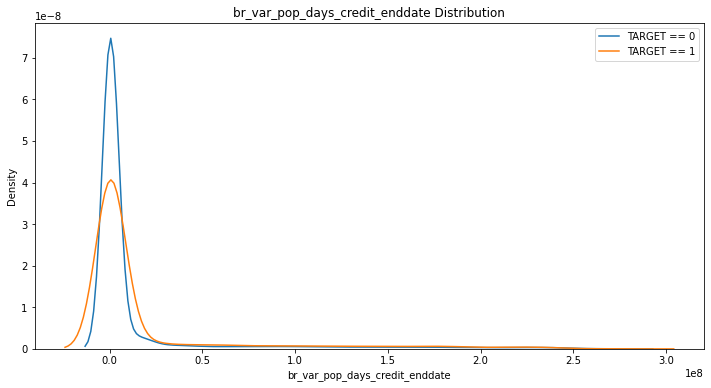

In [101]:
kde_target('br_var_pop_days_credit_enddate', app_train)

In [102]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [103]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.001552
br_var_pop_days_credit_enddate  0.001552                        1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0016
Median value for loan that was not repaid = 0.0838
Median value for loan that was repaid =     0.0876


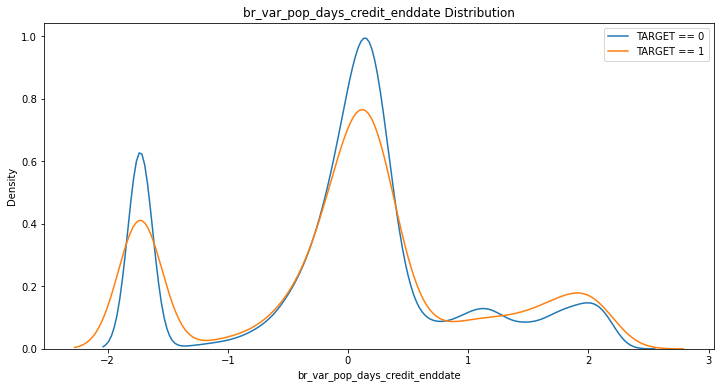

In [104]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_enddate', app_train)

### br_var_samp_days_credit_enddate

In [105]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.026529
br_var_samp_days_credit_enddate  0.026529                         1.000000

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0265
Median value for loan that was not repaid = 451188.8648
Median value for loan that was repaid =     458383.1710


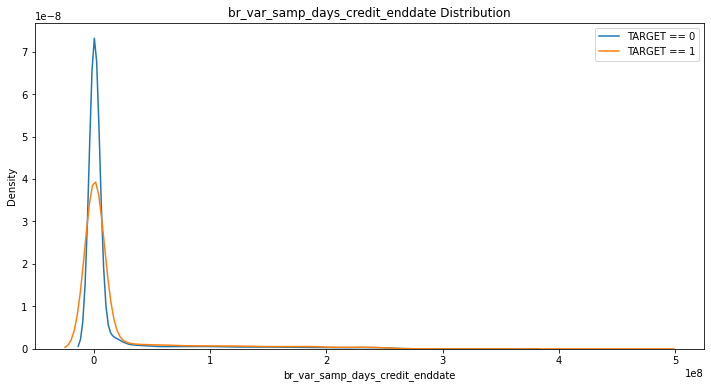

In [106]:
kde_target('br_var_samp_days_credit_enddate', app_train)

In [107]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [108]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

In [109]:

## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_days_credit_enddate', app_train)

### br_variance_pop_days_credit_enddate

In [110]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_days_credit_enddate  0.025917   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                          0.025917  
br_variance_pop_days_credit_enddate                             1.000000

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0259
Median value for loan that was not repaid = 445624.1613
Median value for loan that was repaid =     452623.4119


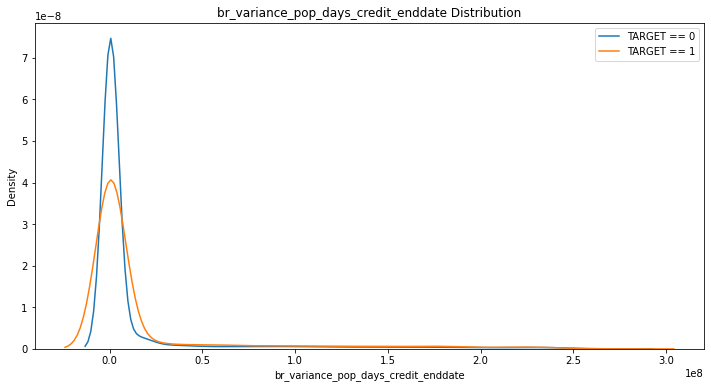

In [111]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

### br_min_days_enddate_fact

In [112]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.066363
br_min_days_enddate_fact  0.066363                  1.000000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0664
Median value for loan that was not repaid = -885.0000
Median value for loan that was repaid =     -1141.0000


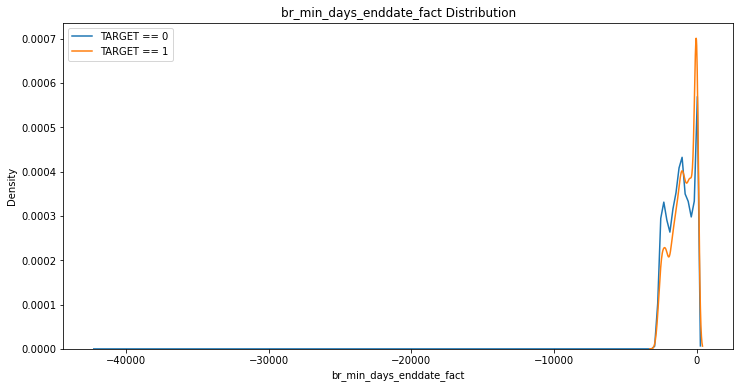

In [113]:
kde_target('br_min_days_enddate_fact', app_train)

In [114]:
## Yao-Johnson変換
num_cols = ['br_min_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_min_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [115]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.067622
br_min_days_enddate_fact  0.067622                  1.000000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0676
Median value for loan that was not repaid = 0.0294
Median value for loan that was repaid =     -0.2264


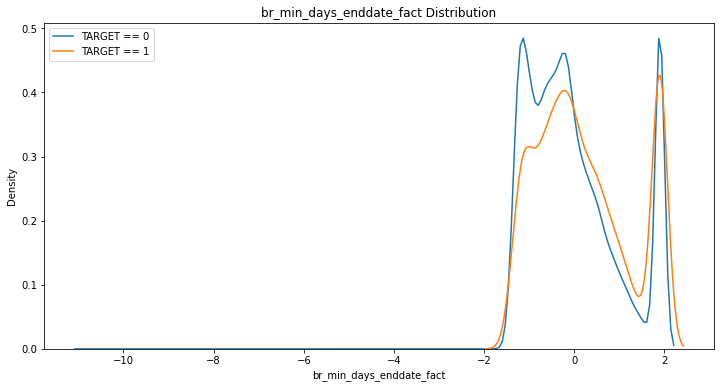

In [116]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_enddate_fact', app_train)

### br_max_days_enddate_fact

In [117]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.035493
br_max_days_enddate_fact  0.035493                  1.000000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0355
Median value for loan that was not repaid = -218.0000
Median value for loan that was repaid =     -272.0000


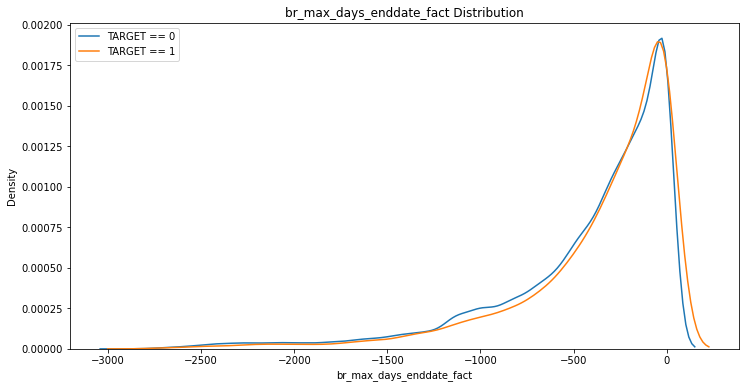

In [118]:
kde_target('br_max_days_enddate_fact', app_train)

In [119]:
## Yao-Johnson変換
num_cols = ['br_max_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_max_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [120]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.047323
br_max_days_enddate_fact  0.047323                  1.000000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0473
Median value for loan that was not repaid = 0.0483
Median value for loan that was repaid =     -0.0969


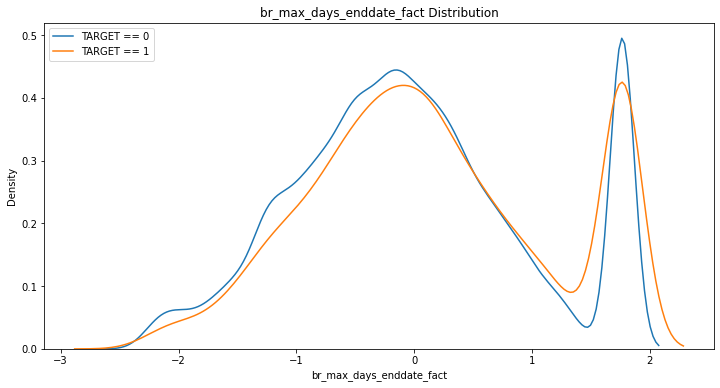

In [121]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_enddate_fact', app_train)

### br_sum_days_enddate_fact

In [122]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.052929
br_sum_days_enddate_fact  0.052929                  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0529
Median value for loan that was not repaid = -31709.0000
Median value for loan that was repaid =     -60254.0000


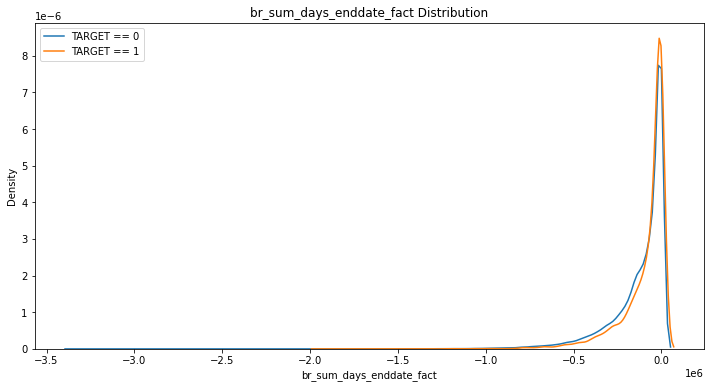

In [123]:
kde_target('br_sum_days_enddate_fact', app_train)

In [124]:
## Yao-Johnson変換
num_cols = ['br_sum_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [125]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.068347
br_sum_days_enddate_fact  0.068347                  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0683
Median value for loan that was not repaid = 0.1324
Median value for loan that was repaid =     -0.1649


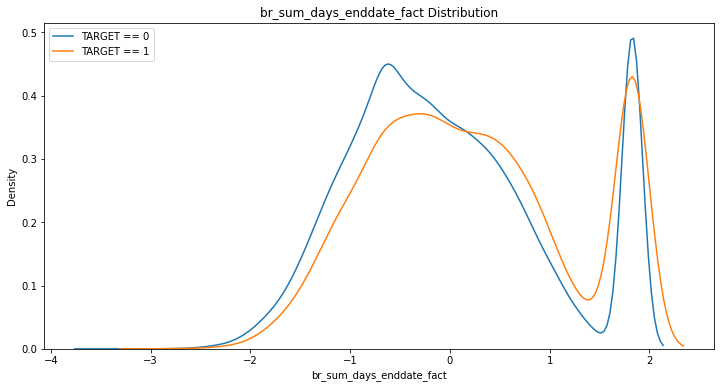

In [126]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_enddate_fact', app_train)

### br_avg_days_enddate_fact

In [127]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.00000                   0.06598
br_avg_days_enddate_fact  0.06598                   1.00000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0660
Median value for loan that was not repaid = -641.5000
Median value for loan that was repaid =     -816.2619


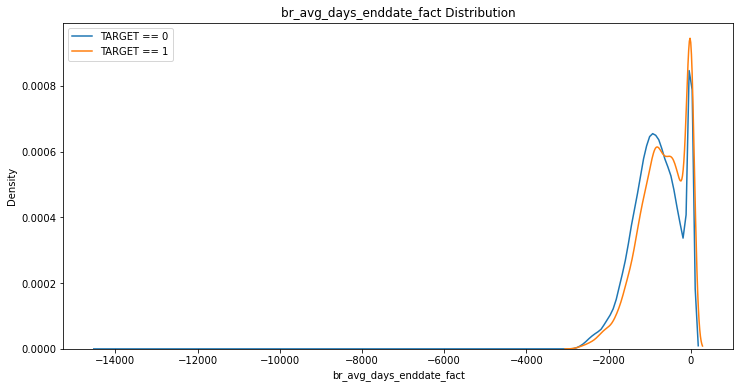

In [128]:
kde_target('br_avg_days_enddate_fact', app_train)

In [129]:
## Yao-Johnson変換
num_cols = ['br_avg_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [130]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.067595
br_avg_days_enddate_fact  0.067595                  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0676
Median value for loan that was not repaid = 0.0266
Median value for loan that was repaid =     -0.2285


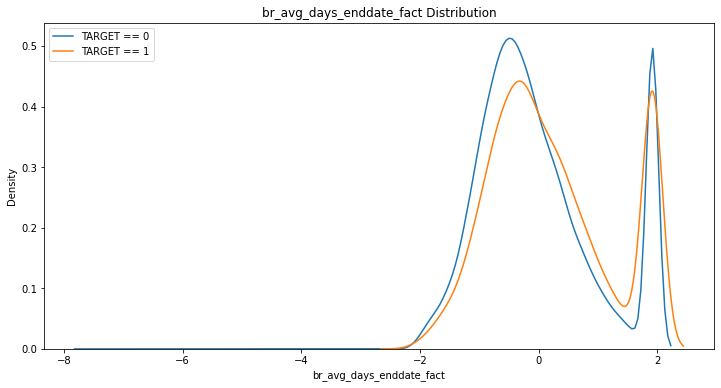

In [131]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_enddate_fact', app_train)

### br_cnt_days_enddate_fact

In [132]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.049224
br_cnt_days_enddate_fact -0.049224                  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0492
Median value for loan that was not repaid = 50.0000
Median value for loan that was repaid =     67.0000


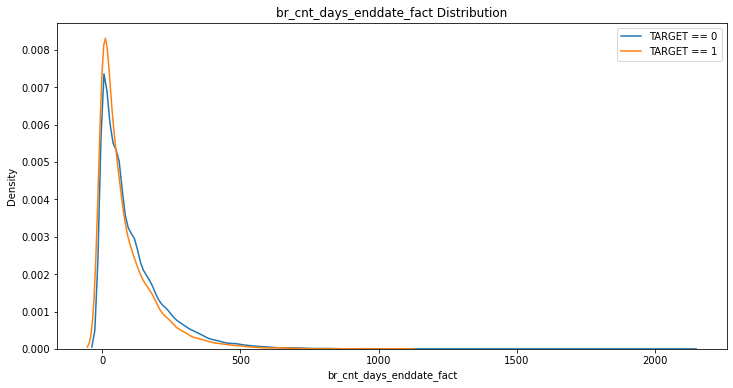

In [133]:
kde_target('br_cnt_days_enddate_fact', app_train)

In [134]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [135]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.061925
br_cnt_days_enddate_fact -0.061925                  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0619
Median value for loan that was not repaid = -0.1441
Median value for loan that was repaid =     0.0583


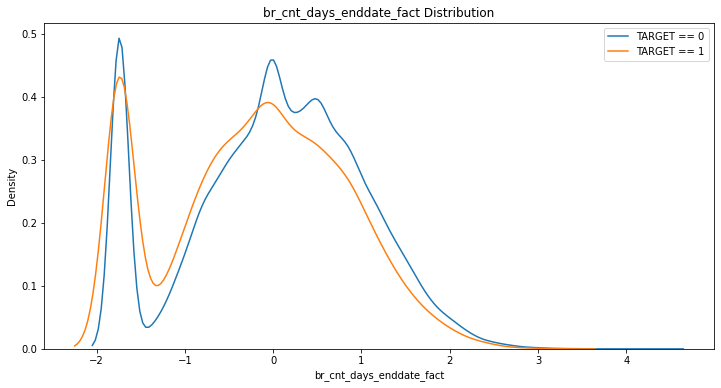

In [136]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_enddate_fact', app_train)

### br_stddev_days_enddate_fact

In [137]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.049746
br_stddev_days_enddate_fact -0.049746                     1.000000

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


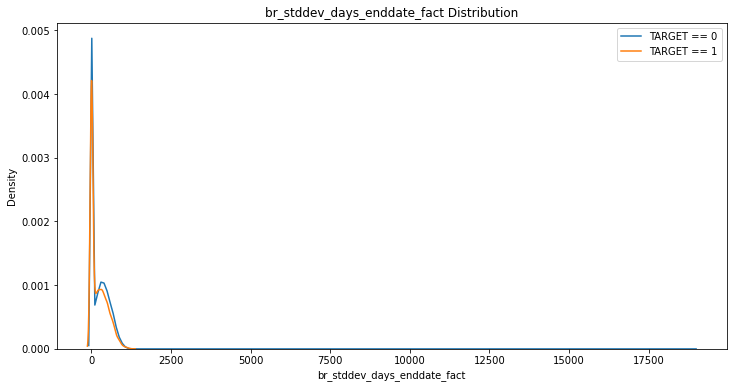

In [138]:
kde_target('br_stddev_days_enddate_fact', app_train)

In [139]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_enddate_fact'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [140]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

In [141]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_days_enddate_fact', app_train)

### br_stddev_pop_days_enddate_fact

In [142]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.049746
br_stddev_pop_days_enddate_fact -0.049746                         1.000000

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


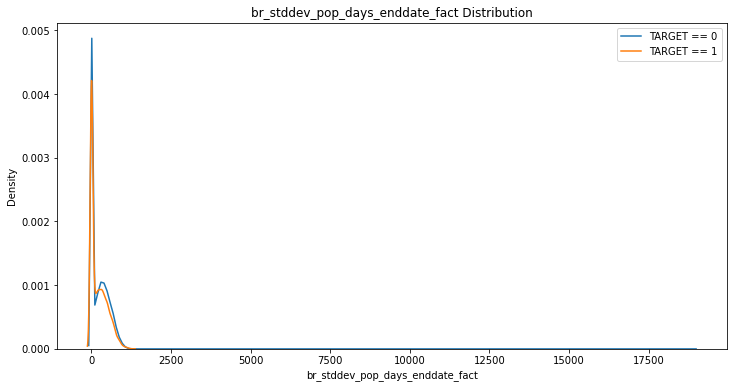

In [143]:
kde_target('br_stddev_pop_days_enddate_fact', app_train)

In [144]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [145]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


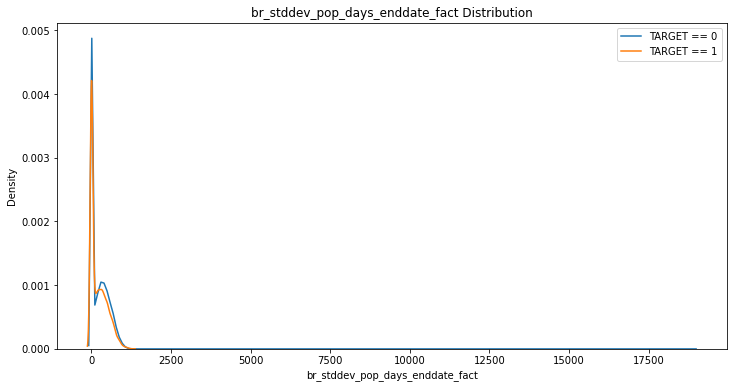

In [146]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_enddate_fact', app_train)

### br_var_pop_days_enddate_fact

In [147]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.008187
br_var_pop_days_enddate_fact -0.008187                      1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14174.8069
Median value for loan that was repaid =     48746.0656


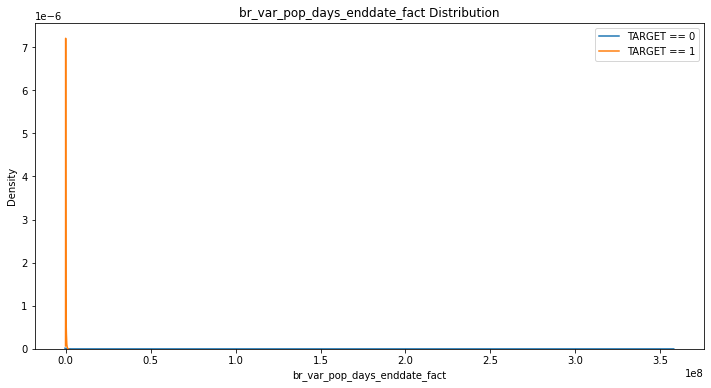

In [148]:
kde_target('br_var_pop_days_enddate_fact', app_train)

In [149]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [150]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.0000                       -0.0493
br_var_pop_days_enddate_fact -0.0493                        1.0000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0493
Median value for loan that was not repaid = 0.1563
Median value for loan that was repaid =     0.4600


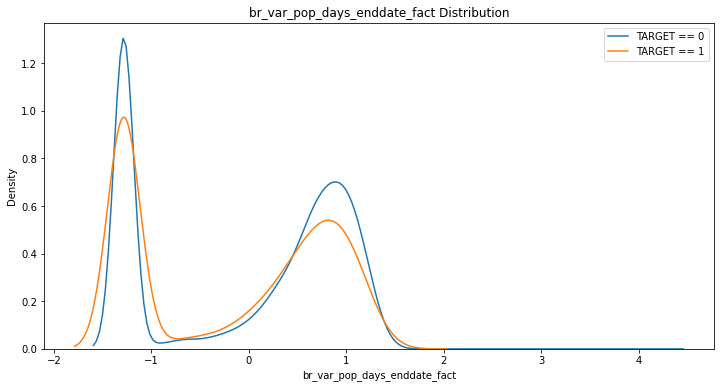

In [151]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_enddate_fact', app_train)

### br_var_samp_days_enddate_fact

In [152]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.008178
br_var_samp_days_enddate_fact -0.008178                       1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14635.2498
Median value for loan that was repaid =     49640.2576


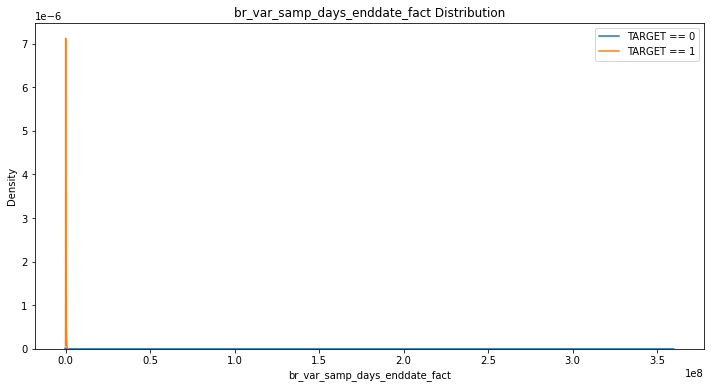

In [153]:
kde_target('br_var_samp_days_enddate_fact', app_train)

In [154]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [155]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.049197
br_var_samp_days_enddate_fact -0.049197                       1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0492
Median value for loan that was not repaid = 0.1605
Median value for loan that was repaid =     0.4613


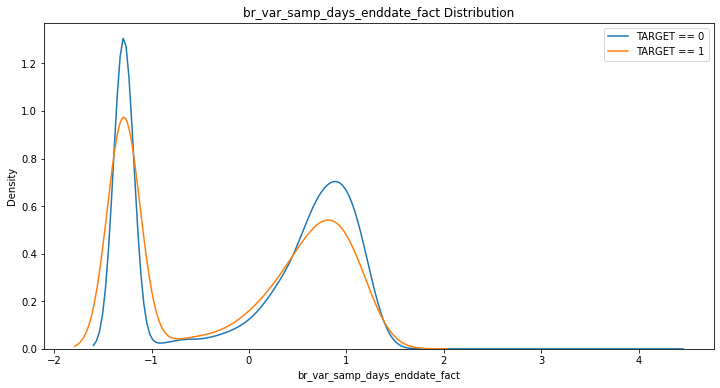

In [156]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_enddate_fact', app_train)

### br_variance_pop_days_enddate_fact

In [157]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.008187
br_variance_pop_days_enddate_fact -0.008187                           1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14174.8069
Median value for loan that was repaid =     48746.0656


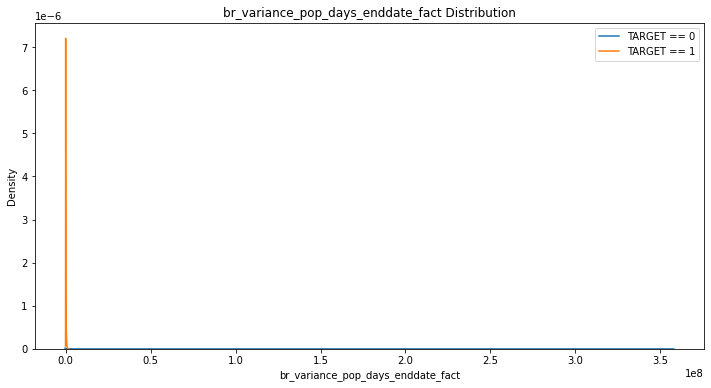

In [158]:
kde_target('br_variance_pop_days_enddate_fact', app_train)

In [159]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [160]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.0000                            -0.0493
br_variance_pop_days_enddate_fact -0.0493                             1.0000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0493
Median value for loan that was not repaid = 0.1563
Median value for loan that was repaid =     0.4600


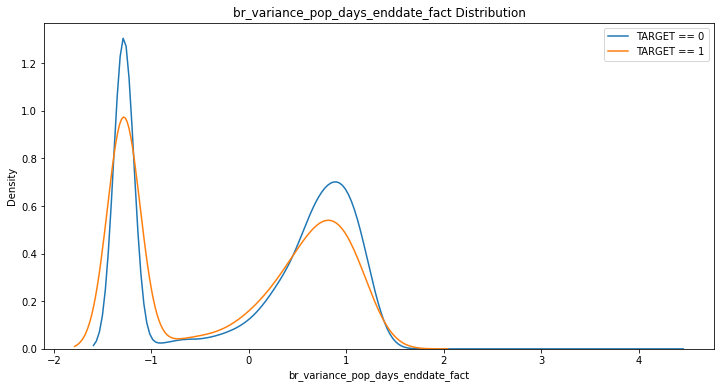

In [161]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_enddate_fact', app_train)

### br_min_amt_credit_max_overdue

In [162]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.002691
br_min_amt_credit_max_overdue  0.002691                       1.000000

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0027
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


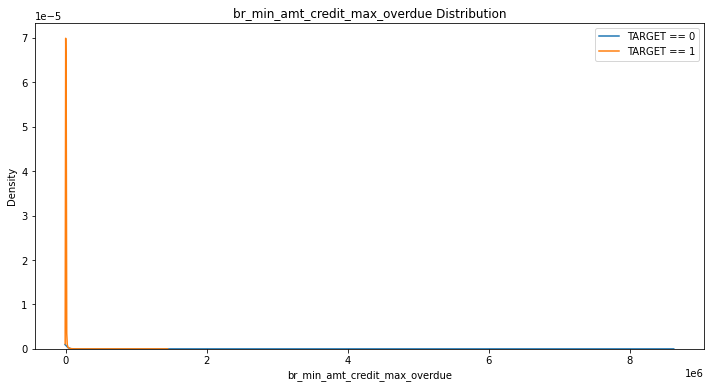

In [163]:
kde_target('br_min_amt_credit_max_overdue', app_train)

In [164]:
num_cols = ['br_min_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_min_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [165]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.029626
br_min_amt_credit_max_overdue  0.029626                       1.000000

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0296
Median value for loan that was not repaid = -0.2641
Median value for loan that was repaid =     -0.2641


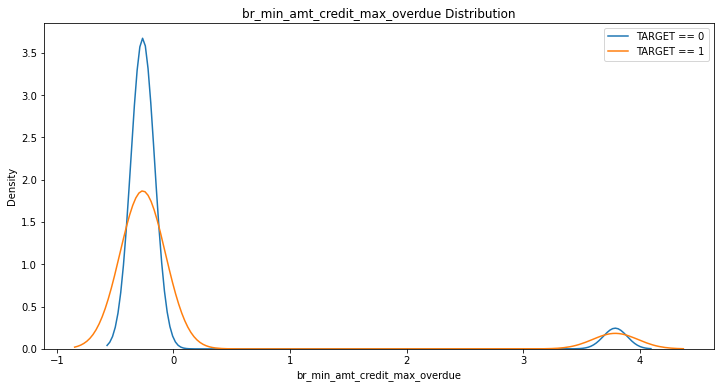

In [166]:
kde_target('br_min_amt_credit_max_overdue', app_train)

### br_max_amt_credit_max_overdue

In [167]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.000545
br_max_amt_credit_max_overdue  0.000545                       1.000000

The correlation between br_max_amt_credit_max_overdue and the TARGET is 0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


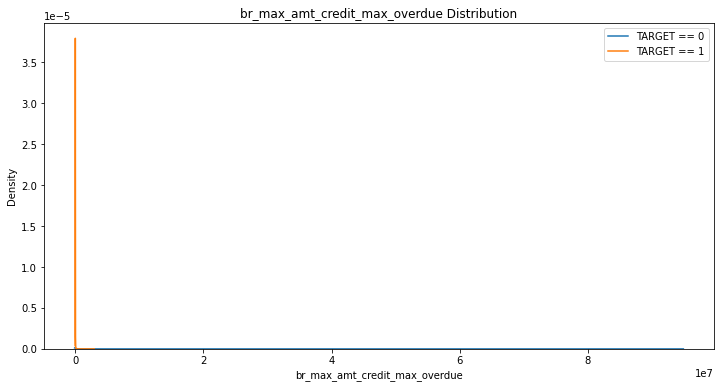

In [168]:
kde_target('br_max_amt_credit_max_overdue', app_train)

In [169]:
num_cols = ['br_max_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_max_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [170]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.041277
br_max_amt_credit_max_overdue  0.041277                       1.000000

The correlation between br_max_amt_credit_max_overdue and the TARGET is 0.0413
Median value for loan that was not repaid = -0.5429
Median value for loan that was repaid =     -0.5429


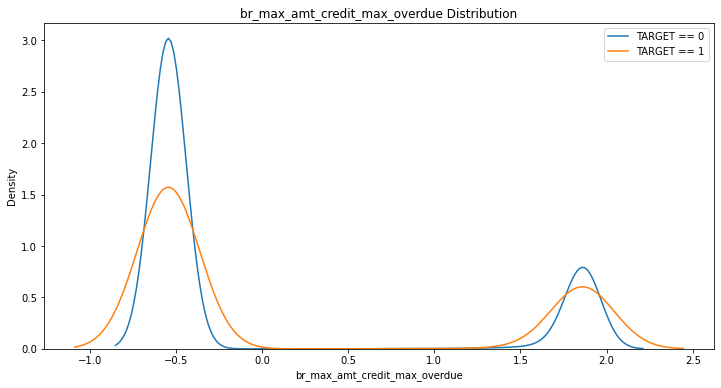

In [171]:
kde_target('br_max_amt_credit_max_overdue', app_train)

### br_sum_amt_credit_max_overdue

In [172]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                      -0.000177
br_sum_amt_credit_max_overdue -0.000177                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is -0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


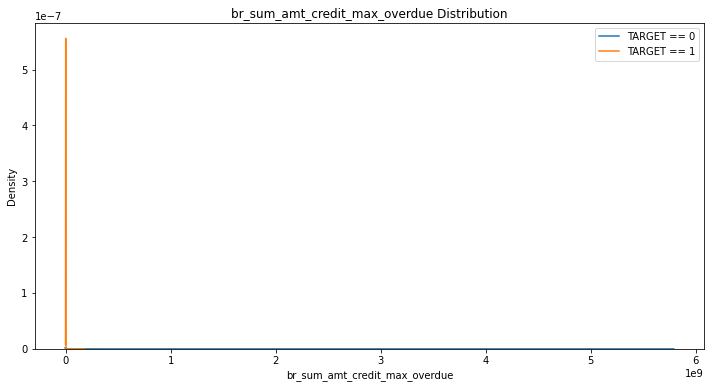

In [173]:
kde_target('br_sum_amt_credit_max_overdue', app_train)

In [174]:
num_cols = ['br_sum_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [175]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.040649
br_sum_amt_credit_max_overdue  0.040649                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0406
Median value for loan that was not repaid = -0.5438
Median value for loan that was repaid =     -0.5438


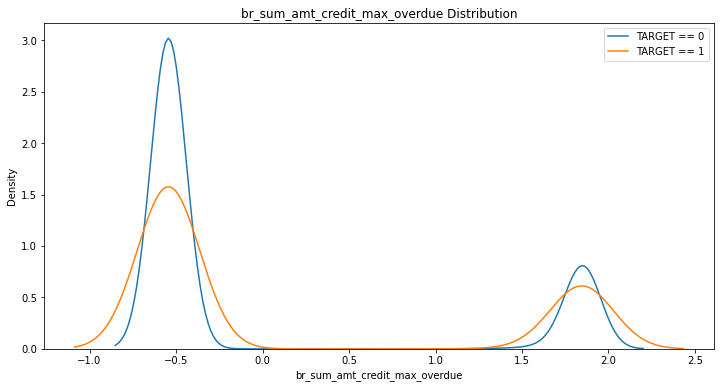

In [176]:
kde_target('br_sum_amt_credit_max_overdue', app_train)

### br_avg_amt_credit_max_overdue

In [177]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000019
br_avg_amt_credit_max_overdue -0.000019                       1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is -0.0000
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


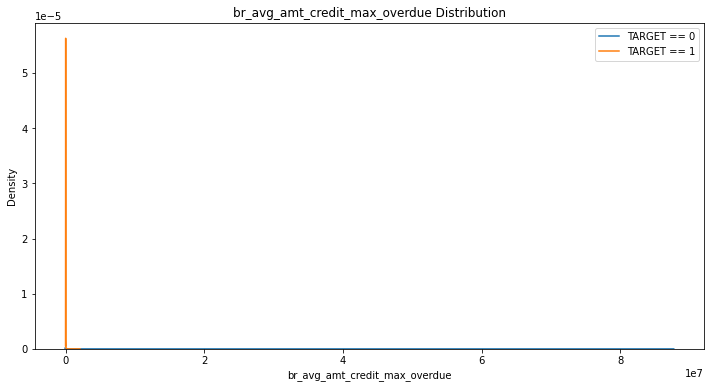

In [178]:
kde_target('br_avg_amt_credit_max_overdue', app_train)

In [179]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [180]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                       0.041347
br_avg_amt_credit_max_overdue  0.041347                       1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is 0.0413
Median value for loan that was not repaid = -0.5420
Median value for loan that was repaid =     -0.5420


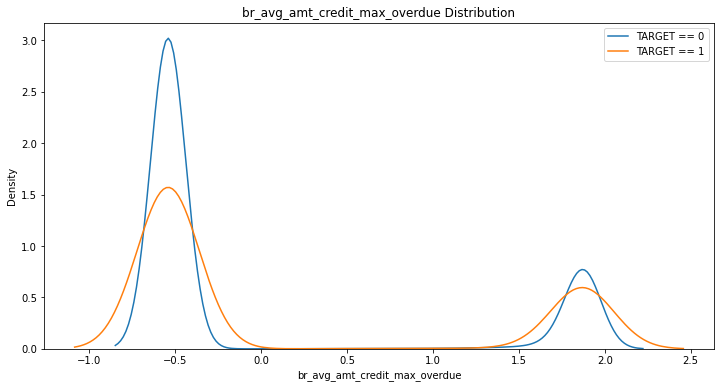

In [181]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_max_overdue', app_train)

### br_cnt_amt_credit_max_overdue

In [182]:
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                      -0.019445
br_cnt_amt_credit_max_overdue -0.019445                       1.000000

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0194
Median value for loan that was not repaid = 16.0000
Median value for loan that was repaid =     19.0000


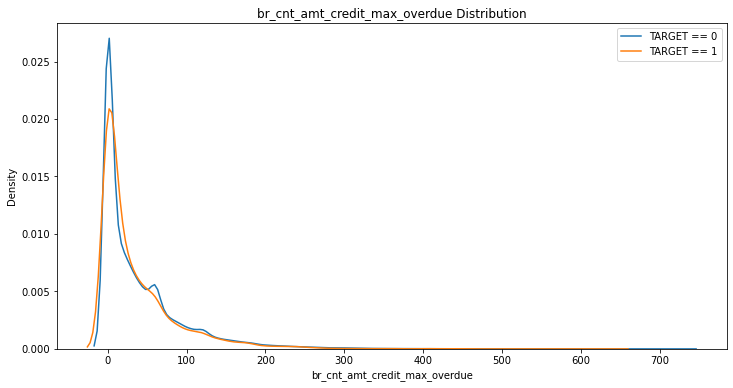

In [183]:
kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [184]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [185]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                      -0.009218
br_cnt_amt_credit_max_overdue -0.009218                       1.000000

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0092
Median value for loan that was not repaid = 0.1424
Median value for loan that was repaid =     0.2312


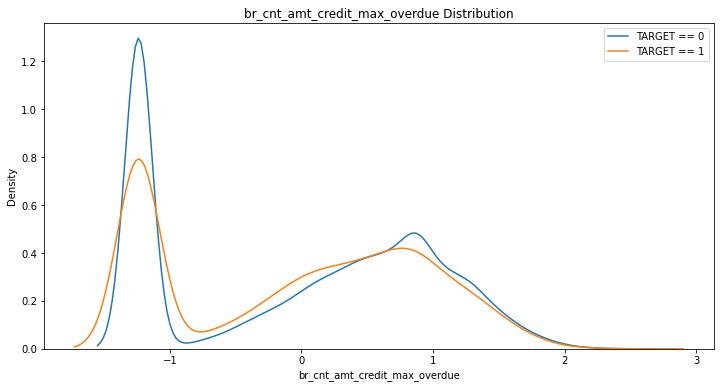

In [186]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_max_overdue', app_train)

### br_stddev_amt_credit_max_overdue

In [187]:
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.000837
br_stddev_amt_credit_max_overdue  0.000837                          1.000000

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


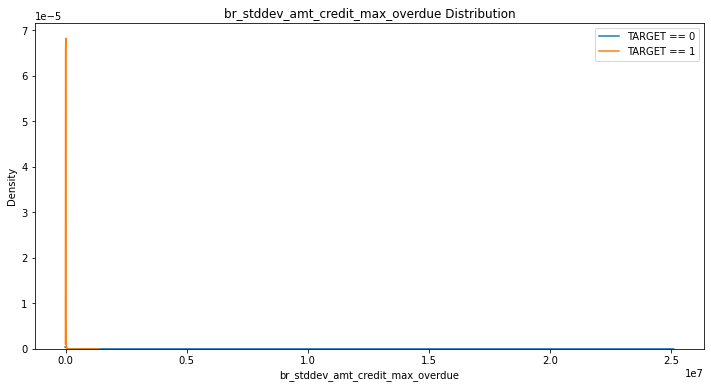

In [188]:
kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [189]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [190]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.031343
br_stddev_amt_credit_max_overdue  0.031343                          1.000000

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0313
Median value for loan that was not repaid = -0.4640
Median value for loan that was repaid =     -0.4640


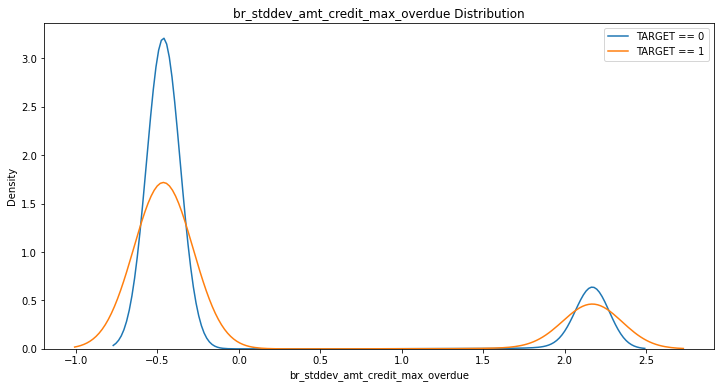

In [191]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_max_overdue', app_train)

### br_stddev_pop_amt_credit_max_overdue

In [192]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.000837   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.000837  
br_stddev_pop_amt_credit_max_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


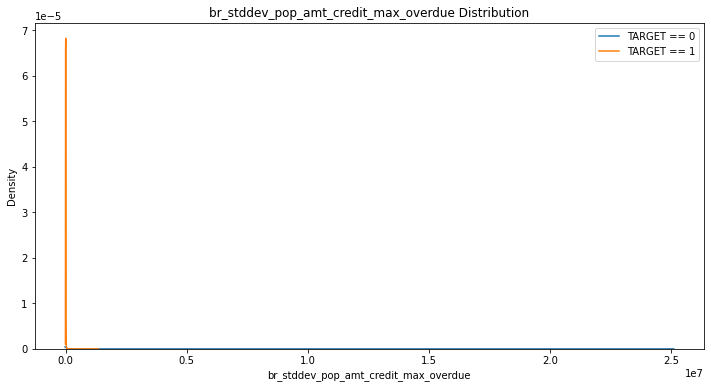

In [193]:
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [194]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [195]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.031343   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.031343  
br_stddev_pop_amt_credit_max_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0313
Median value for loan that was not repaid = -0.4640
Median value for loan that was repaid =     -0.4640


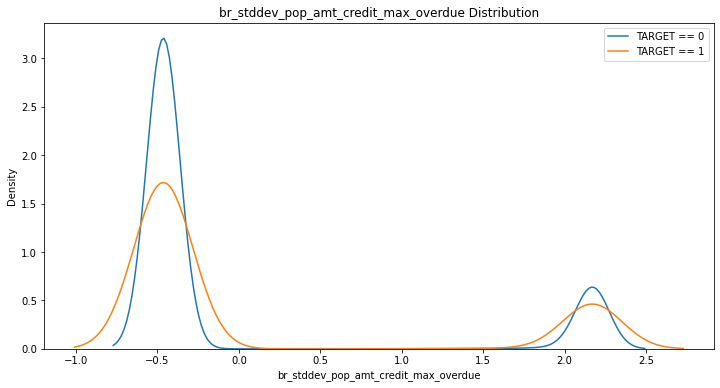

In [196]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

### br_var_pop_amt_credit_max_overdue

In [197]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                          -0.000962
br_var_pop_amt_credit_max_overdue -0.000962                           1.000000

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


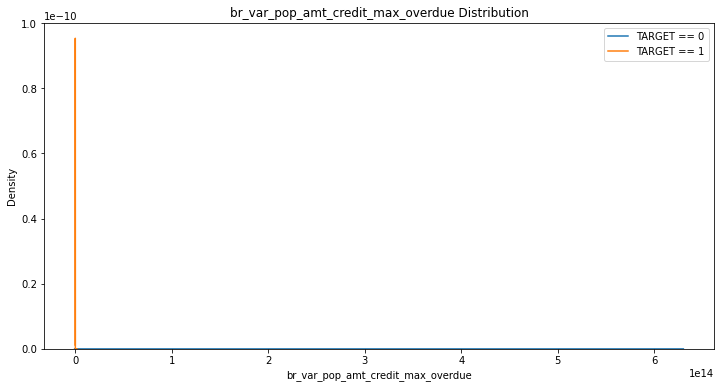

In [198]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [199]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [200]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                           0.031395
br_var_pop_amt_credit_max_overdue  0.031395                           1.000000

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is 0.0314
Median value for loan that was not repaid = -0.4637
Median value for loan that was repaid =     -0.4637


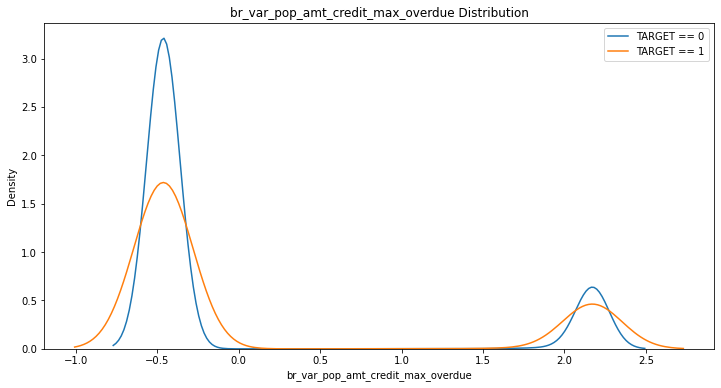

In [201]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

### br_var_samp_amt_credit_max_overdue

In [202]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue -0.000962   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                       -0.000962  
br_var_samp_amt_credit_max_overdue                            1.000000

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


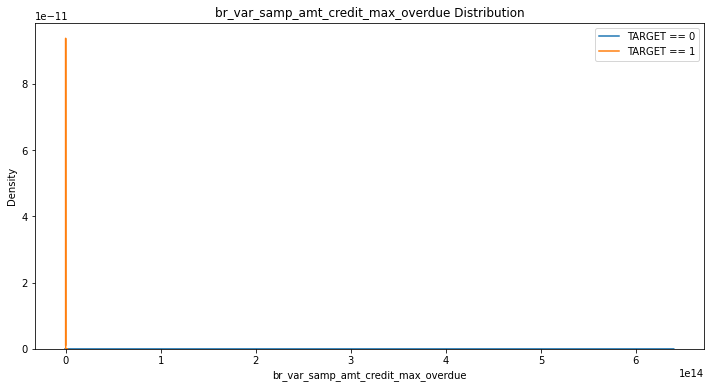

In [203]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [204]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [205]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue  0.031394   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                        0.031394  
br_var_samp_amt_credit_max_overdue                            1.000000

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is 0.0314
Median value for loan that was not repaid = -0.4637
Median value for loan that was repaid =     -0.4637


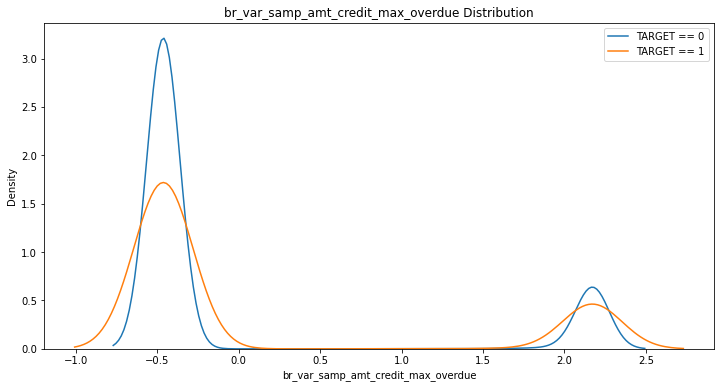

In [206]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

### br_variance_pop_amt_credit_max_overdue

In [207]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue -0.000962   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                               -0.000962  
br_variance_pop_amt_credit_max_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


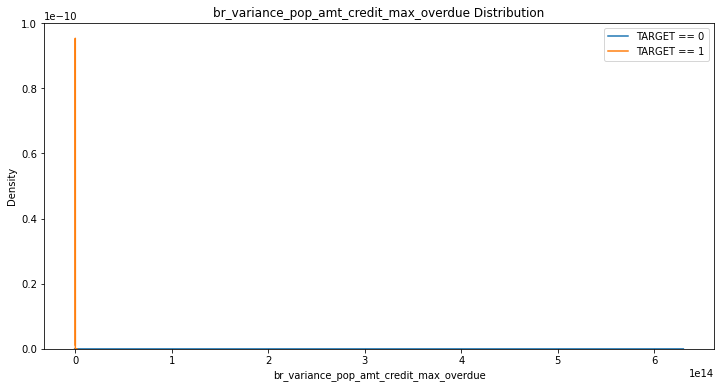

In [208]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [209]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [210]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue  0.031395   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                                0.031395  
br_variance_pop_amt_credit_max_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is 0.0314
Median value for loan that was not repaid = -0.4637
Median value for loan that was repaid =     -0.4637


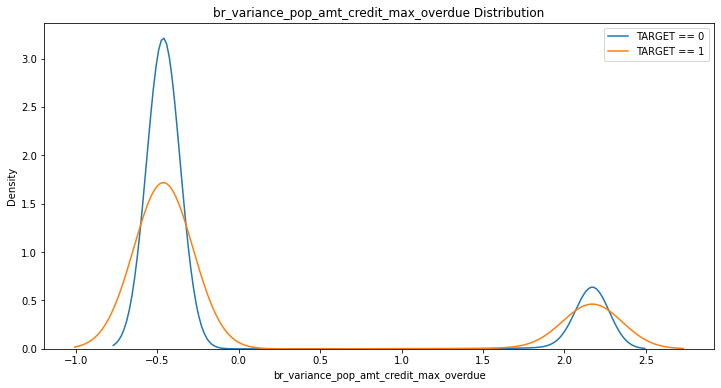

In [211]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

### br_min_cnt_credit_prolong

In [212]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.005553
br_min_cnt_credit_prolong  0.005553                   1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0056
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


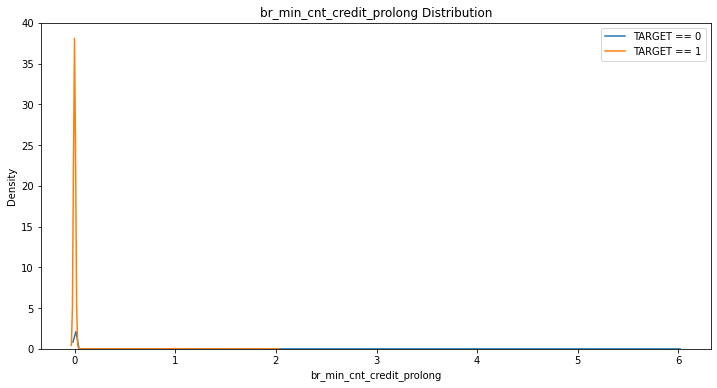

In [213]:
kde_target('br_min_cnt_credit_prolong', app_train)

In [214]:
## Yao-Johnson変換
num_cols = ['br_min_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_min_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [215]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.006039
br_min_cnt_credit_prolong  0.006039                   1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0060
Median value for loan that was not repaid = -0.0343
Median value for loan that was repaid =     -0.0343


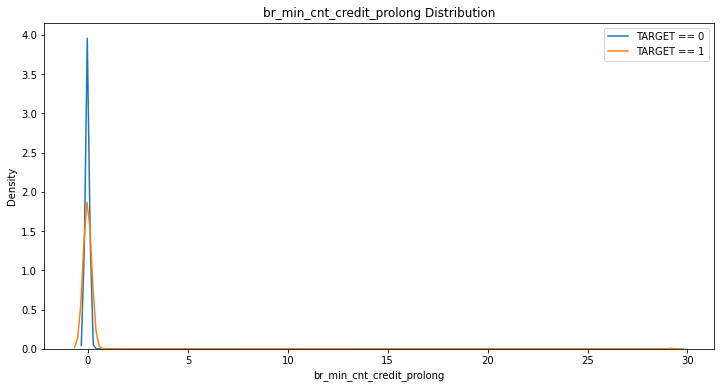

In [216]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_cnt_credit_prolong', app_train)

### br_max_cnt_credit_prolong

In [217]:
## 目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.007141
br_max_cnt_credit_prolong  0.007141                   1.000000

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0071
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


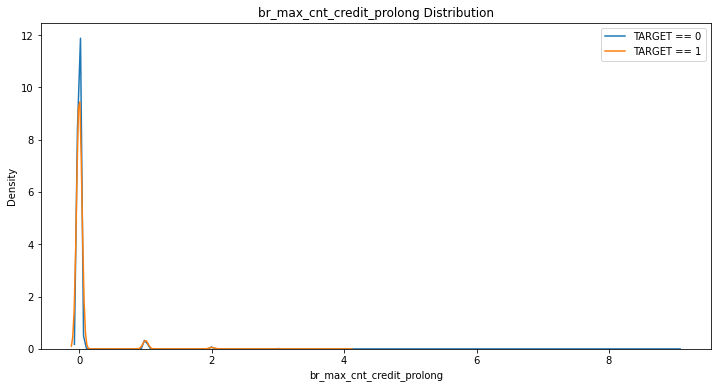

In [218]:
## 特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

In [219]:
## Yao-Johnson変換
num_cols = ['br_max_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_max_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [220]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.011207
br_max_cnt_credit_prolong  0.011207                   1.000000

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0112
Median value for loan that was not repaid = -0.1792
Median value for loan that was repaid =     -0.1792


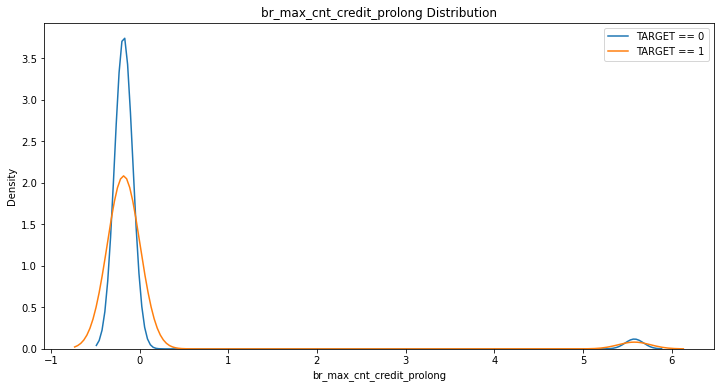

In [221]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

### br_sum_cnt_credit_prolong

In [222]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.000000                  -0.002808
br_sum_cnt_credit_prolong -0.002808                   1.000000

The correlation between br_sum_cnt_credit_prolong and the TARGET is -0.0028
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


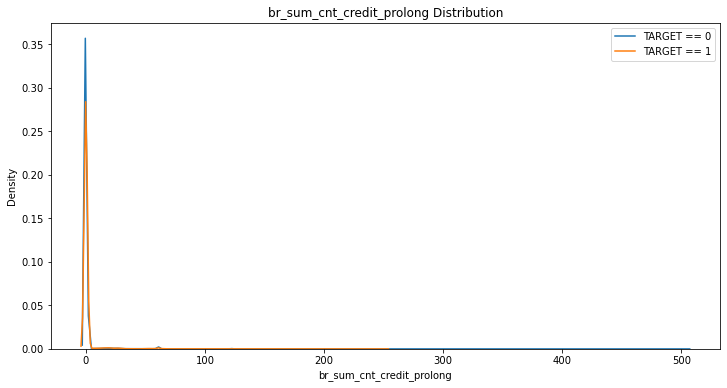

In [223]:
## 特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

In [224]:
## Yao-Johnson変換
num_cols = ['br_sum_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_sum_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [225]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.000000                   0.011207
br_sum_cnt_credit_prolong  0.011207                   1.000000

The correlation between br_sum_cnt_credit_prolong and the TARGET is 0.0112
Median value for loan that was not repaid = -0.1792
Median value for loan that was repaid =     -0.1792


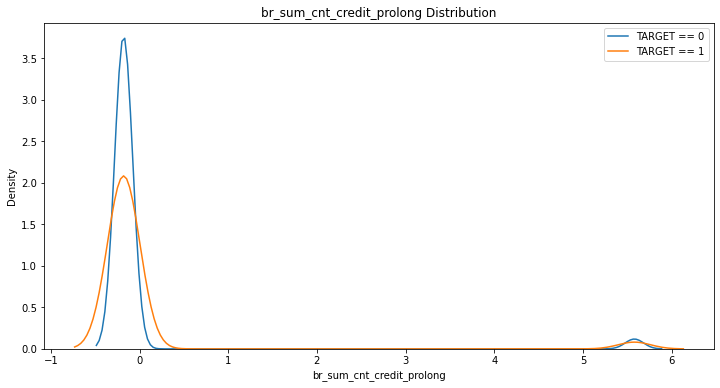

In [226]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

### br_avg_cnt_credit_prolong

In [227]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.007663
br_avg_cnt_credit_prolong  0.007663                   1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0077
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


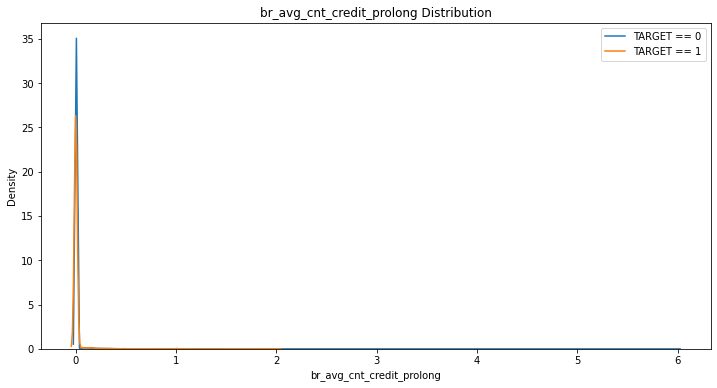

In [228]:
## 特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

In [229]:
## Yao-Johnson変換
num_cols = ['br_avg_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_avg_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [230]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.011041
br_avg_cnt_credit_prolong  0.011041                   1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0110
Median value for loan that was not repaid = -0.1791
Median value for loan that was repaid =     -0.1791


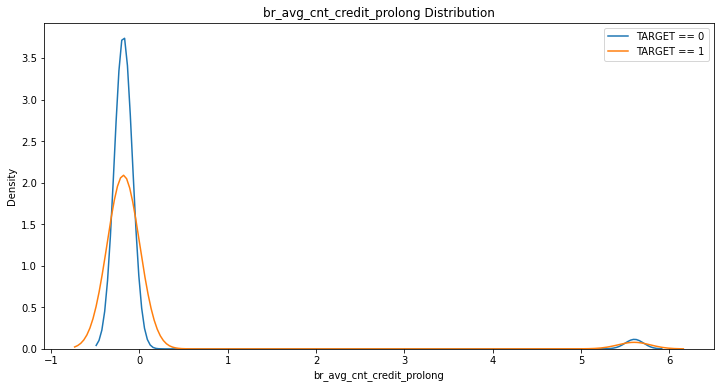

In [231]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

### br_cnt_cnt_credit_prolong

In [232]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.040412
br_cnt_cnt_credit_prolong -0.040412                   1.000000

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


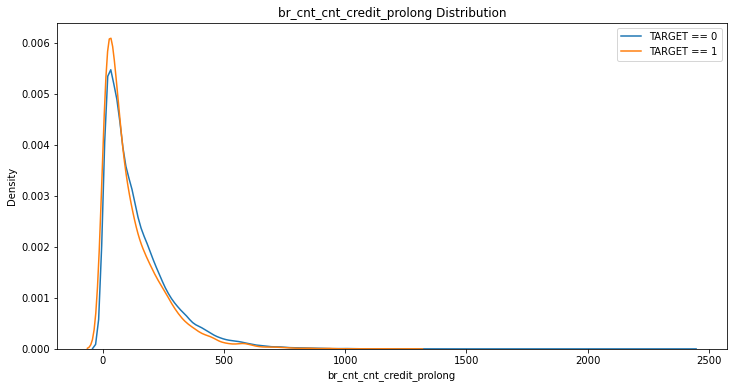

In [233]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

### br_stddev_cnt_credit_prolong

In [234]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.005682
br_stddev_cnt_credit_prolong  0.005682                      1.000000

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


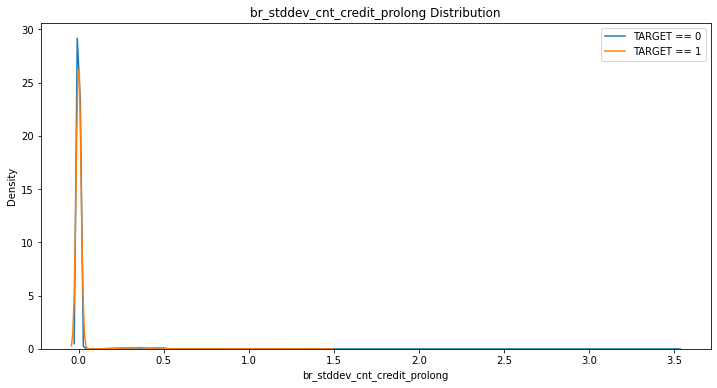

In [235]:
## 特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

In [236]:
## Yao-Johnson変換
num_cols = ['br_stddev_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [237]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.010203
br_stddev_cnt_credit_prolong  0.010203                      1.000000

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0102
Median value for loan that was not repaid = -0.1757
Median value for loan that was repaid =     -0.1757


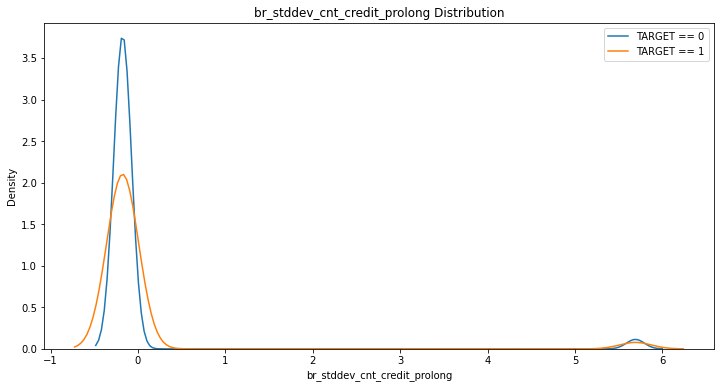

In [238]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

### br_stddev_pop_cnt_credit_prolong

In [239]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.005682
br_stddev_pop_cnt_credit_prolong  0.005682                          1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


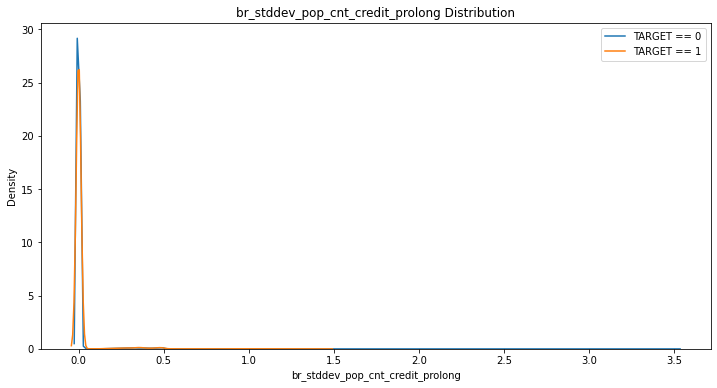

In [240]:
## 特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

In [241]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [242]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.010203
br_stddev_pop_cnt_credit_prolong  0.010203                          1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0102
Median value for loan that was not repaid = -0.1757
Median value for loan that was repaid =     -0.1757


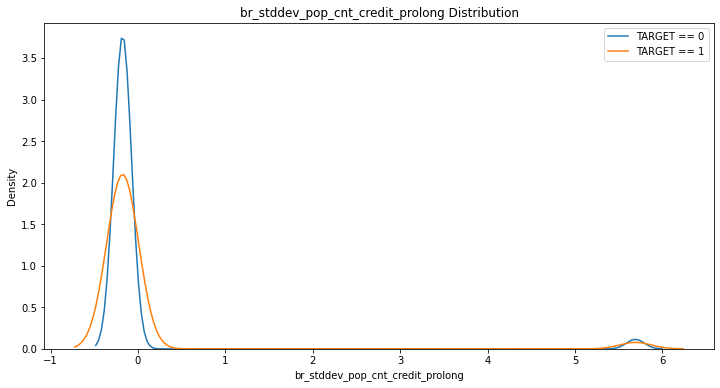

In [243]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

### br_var_pop_cnt_credit_prolong

In [244]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.000646
br_var_pop_cnt_credit_prolong  0.000646                       1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0006
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


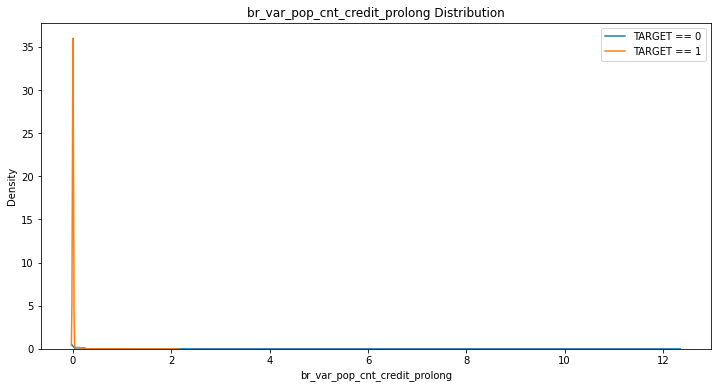

In [245]:
## 特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

In [246]:
## Yao-Johnson変換
num_cols = ['br_var_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [247]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.010049
br_var_pop_cnt_credit_prolong  0.010049                       1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0100
Median value for loan that was not repaid = -0.1756
Median value for loan that was repaid =     -0.1756


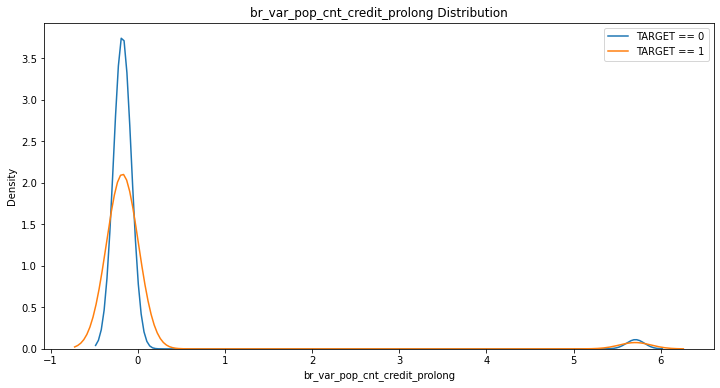

In [248]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

### br_var_samp_cnt_credit_prolong

In [249]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.000765
br_var_samp_cnt_credit_prolong  0.000765                        1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


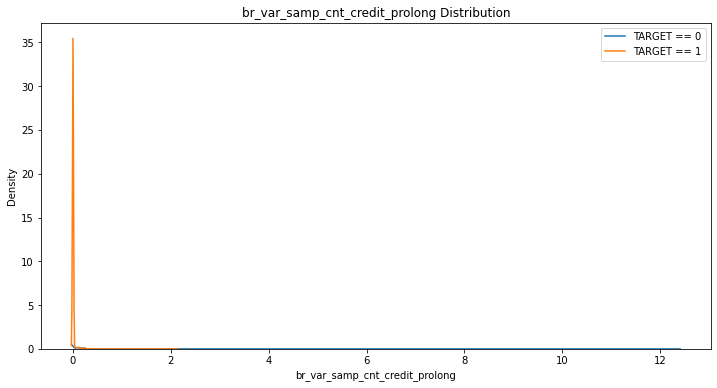

In [250]:
## 特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

In [251]:
## Yao-Johnson変換
num_cols = ['br_var_samp_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [252]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.010049
br_var_samp_cnt_credit_prolong  0.010049                        1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0100
Median value for loan that was not repaid = -0.1756
Median value for loan that was repaid =     -0.1756


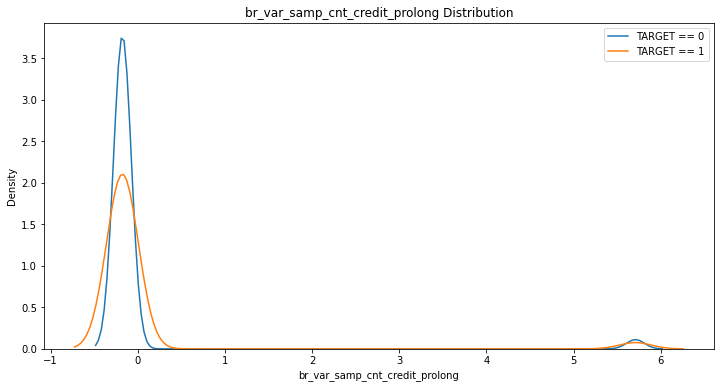

In [253]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

### br_variance_pop_cnt_credit_prolong

In [254]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.000646   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.000646  
br_variance_pop_cnt_credit_prolong                            1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0006
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


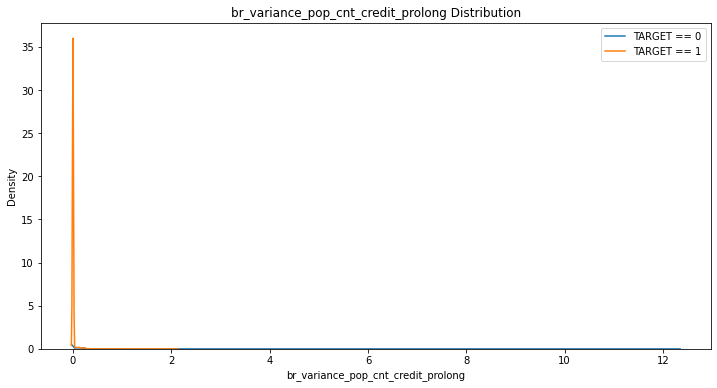

In [255]:
## 特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

In [256]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [257]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.010049   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.010049  
br_variance_pop_cnt_credit_prolong                            1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0100
Median value for loan that was not repaid = -0.1756
Median value for loan that was repaid =     -0.1756


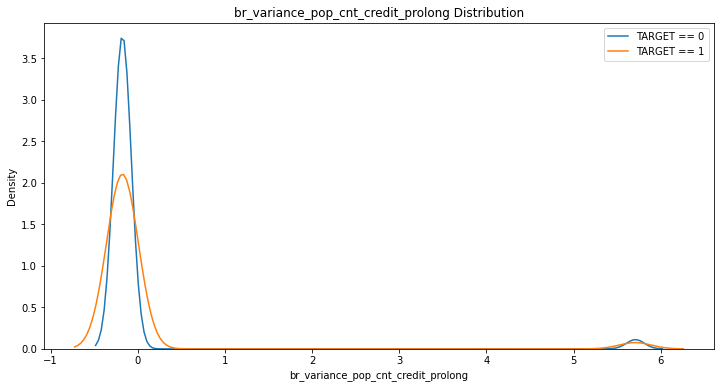

In [258]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

### br_min_amt_credit_sum

In [259]:
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.013165
br_min_amt_credit_sum -0.013165               1.000000

The correlation between br_min_amt_credit_sum and the TARGET is -0.0132
Median value for loan that was not repaid = 36000.0000
Median value for loan that was repaid =     43128.0000


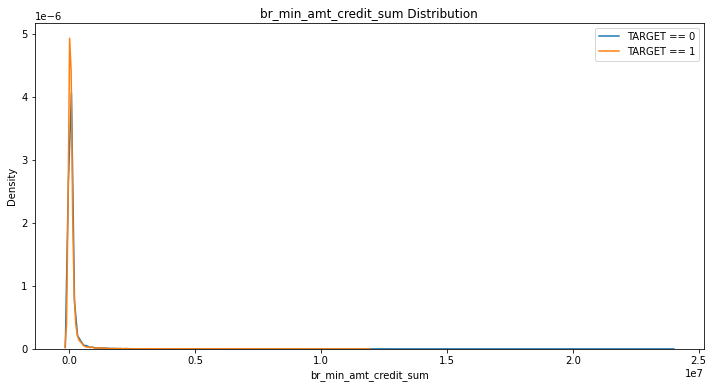

In [260]:
kde_target('br_min_amt_credit_sum', app_train)

In [261]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [262]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.020873
br_min_amt_credit_sum -0.020873               1.000000

The correlation between br_min_amt_credit_sum and the TARGET is -0.0209
Median value for loan that was not repaid = 0.0631
Median value for loan that was repaid =     0.1442


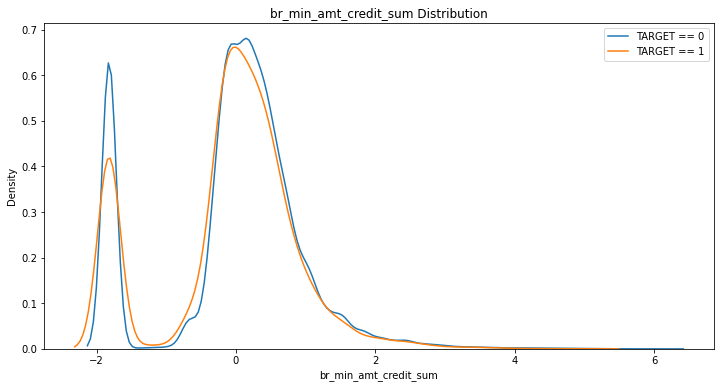

In [263]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum', app_train)

### br_max_amt_credit_sum

In [264]:
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.018822
br_max_amt_credit_sum -0.018822               1.000000

The correlation between br_max_amt_credit_sum and the TARGET is -0.0188
Median value for loan that was not repaid = 450000.0000
Median value for loan that was repaid =     454500.0000


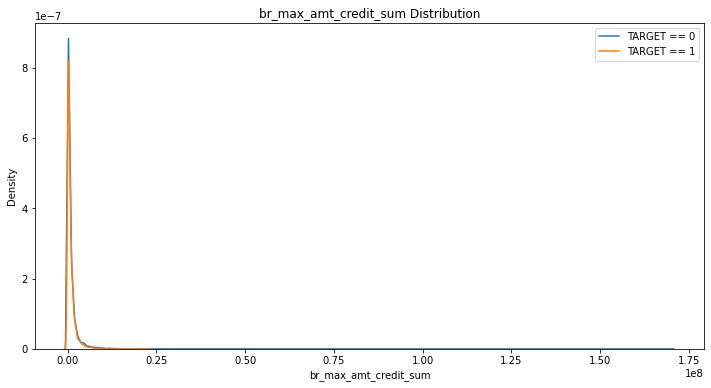

In [265]:
kde_target('br_max_amt_credit_sum', app_train)

In [266]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [267]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.022011
br_max_amt_credit_sum -0.022011               1.000000

The correlation between br_max_amt_credit_sum and the TARGET is -0.0220
Median value for loan that was not repaid = -0.0898
Median value for loan that was repaid =     -0.0825


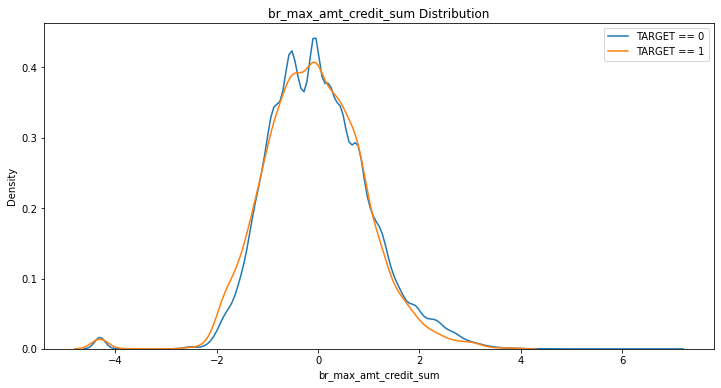

In [268]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum', app_train)

### br_sum_amt_credit_sum

In [269]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.029583
br_sum_amt_credit_sum -0.029583               1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0296
Median value for loan that was not repaid = 15241648.8600
Median value for loan that was repaid =     20821472.8200


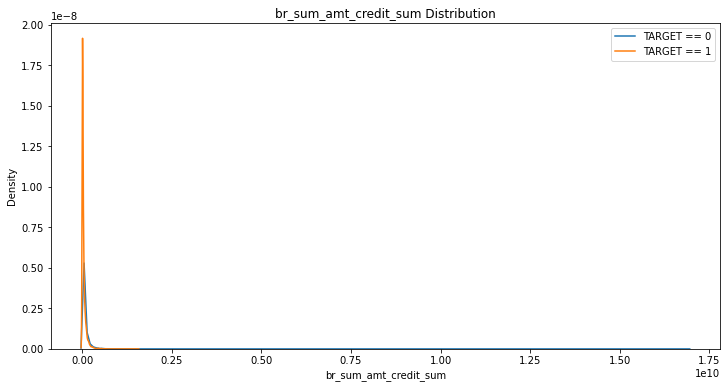

In [270]:
kde_target('br_sum_amt_credit_sum', app_train)

In [271]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [272]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.055281
br_sum_amt_credit_sum -0.055281               1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0553
Median value for loan that was not repaid = -0.1913
Median value for loan that was repaid =     -0.0001


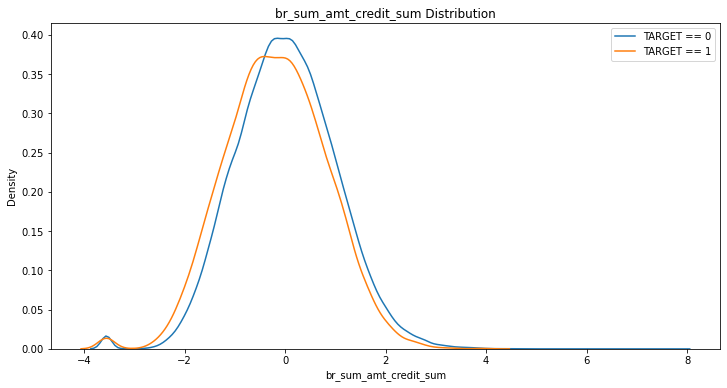

In [273]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum', app_train)

### br_avg_amt_credit_sum

In [274]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.024909
br_avg_amt_credit_sum -0.024909               1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0249
Median value for loan that was not repaid = 177727.9592
Median value for loan that was repaid =     193234.7520


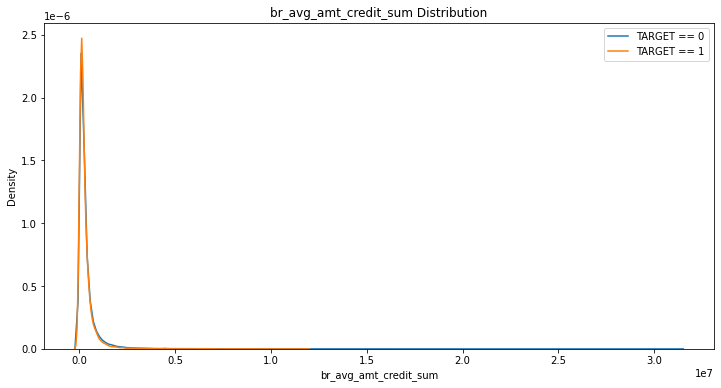

In [275]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

In [276]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [277]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.030857
br_avg_amt_credit_sum -0.030857               1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0309
Median value for loan that was not repaid = -0.1680
Median value for loan that was repaid =     -0.0958


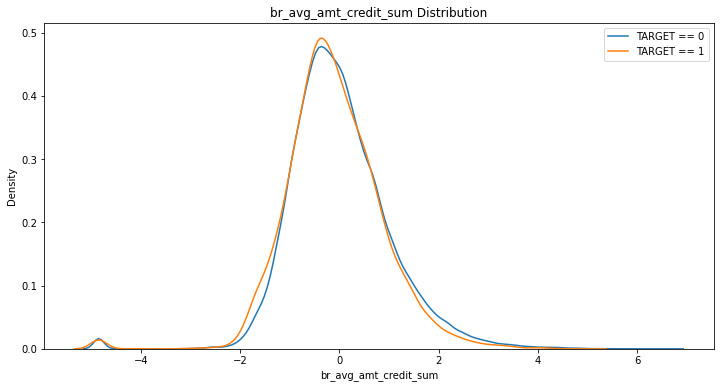

In [278]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

### br_cnt_amt_credit_sum

In [279]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.040412
br_cnt_amt_credit_sum -0.040412               1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


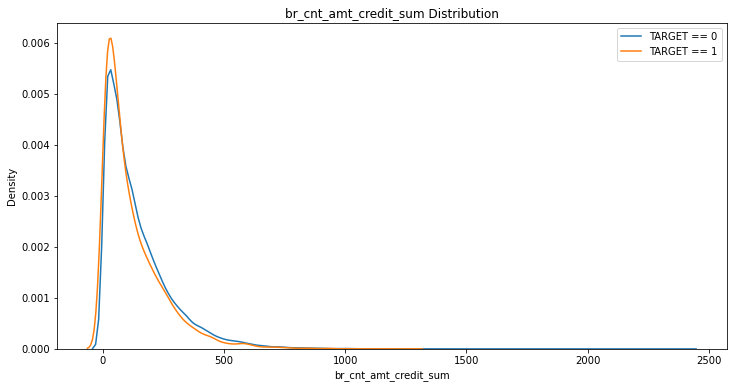

In [280]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

In [281]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [282]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.052954
br_cnt_amt_credit_sum -0.052954               1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0530
Median value for loan that was not repaid = -0.1841
Median value for loan that was repaid =     0.0410


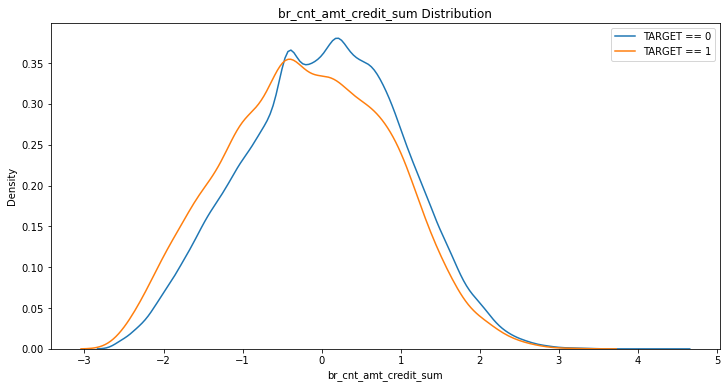

In [283]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

### br_stddev_amt_credit_sum

In [284]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.000000                 -0.018673
br_stddev_amt_credit_sum -0.018673                  1.000000

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0187
Median value for loan that was not repaid = 115148.8013
Median value for loan that was repaid =     121694.9680


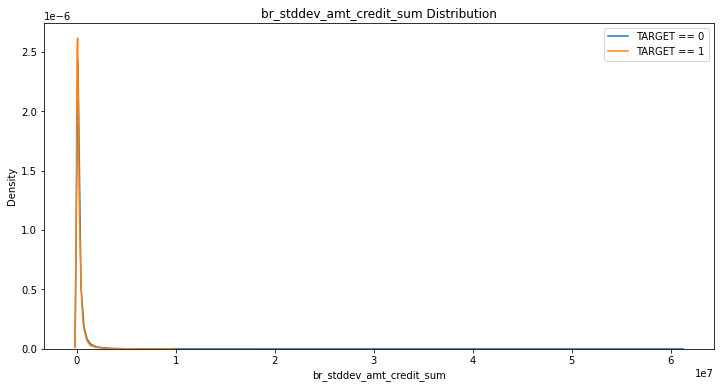

In [285]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

### br_stddev_pop_amt_credit_sum

In [286]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

TARGET  br_stddev_pop_amt_credit_sum
TARGET                        1.000000                     -0.018673
br_stddev_pop_amt_credit_sum -0.018673                      1.000000

The correlation between br_stddev_pop_amt_credit_sum and the TARGET is -0.0187
Median value for loan that was not repaid = 115148.8013
Median value for loan that was repaid =     121694.9680


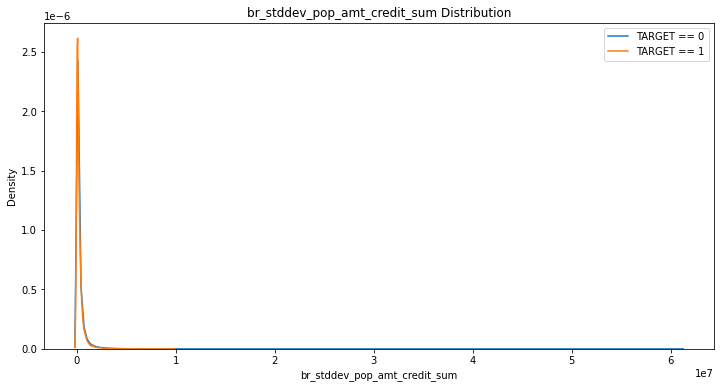

In [287]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum', app_train)

### br_var_pop_amt_credit_sum

In [288]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.003815
br_var_pop_amt_credit_sum -0.003815                   1.000000

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0038
Median value for loan that was not repaid = 13259246440.4831
Median value for loan that was repaid =     14809665239.1709


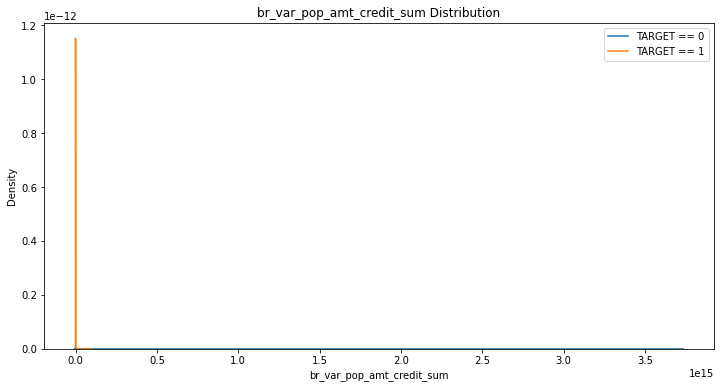

In [289]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

In [290]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [291]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.019536
br_var_pop_amt_credit_sum -0.019536                   1.000000

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0195
Median value for loan that was not repaid = 0.0865
Median value for loan that was repaid =     0.1129


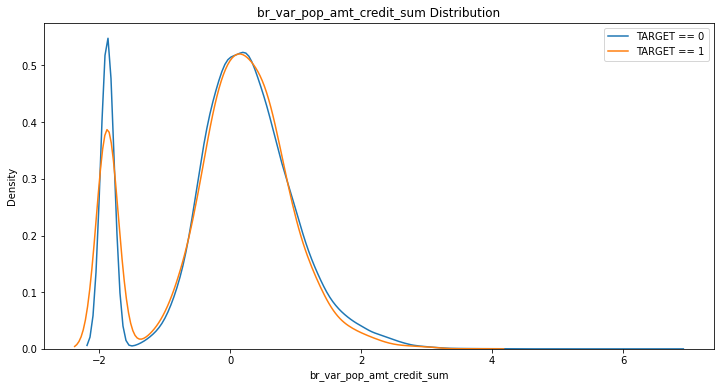

In [292]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

### br_var_samp_amt_credit_sum

In [293]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.003828
br_var_samp_amt_credit_sum -0.003828                    1.000000

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0038
Median value for loan that was not repaid = 13489676875.7267
Median value for loan that was repaid =     15016340629.4280


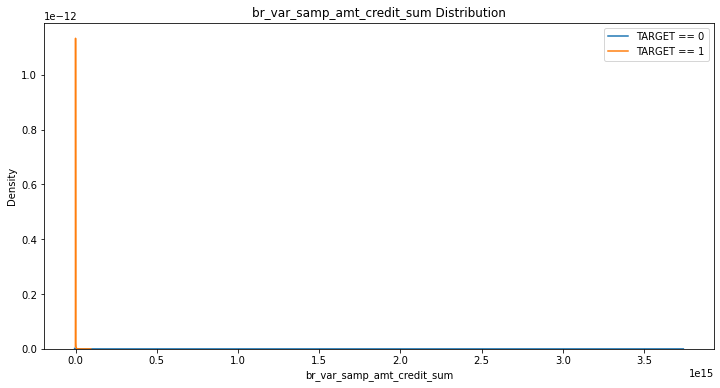

In [294]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

In [295]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [296]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.019305
br_var_samp_amt_credit_sum -0.019305                    1.000000

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0193
Median value for loan that was not repaid = 0.0871
Median value for loan that was repaid =     0.1127


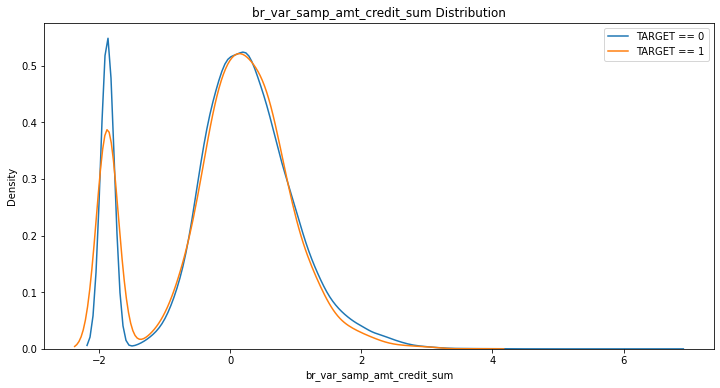

In [297]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

### br_variance_pop_amt_credit_sum

In [298]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.003815
br_variance_pop_amt_credit_sum -0.003815                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0038
Median value for loan that was not repaid = 13259246440.4831
Median value for loan that was repaid =     14809665239.1709


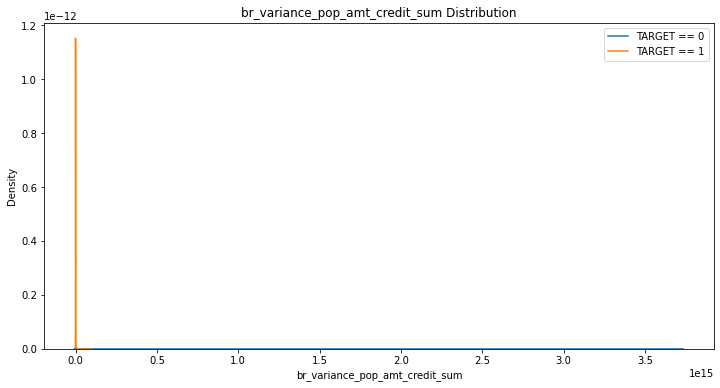

In [299]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [300]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [301]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.019536
br_variance_pop_amt_credit_sum -0.019536                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0195
Median value for loan that was not repaid = 0.0865
Median value for loan that was repaid =     0.1129


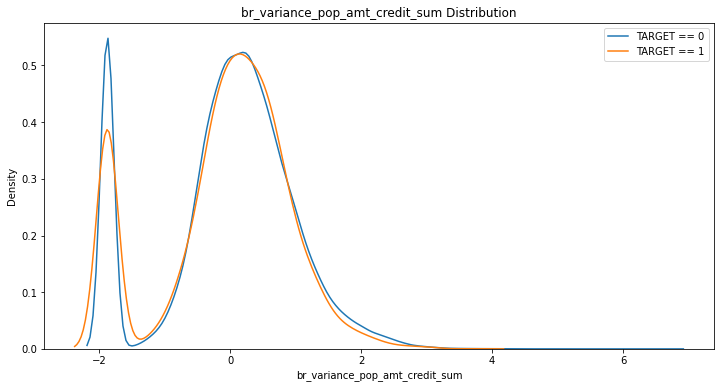

In [302]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

### br_min_amt_credit_sum_debt

In [303]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.00000                    -0.00119
br_min_amt_credit_sum_debt -0.00119                     1.00000

The correlation between br_min_amt_credit_sum_debt and the TARGET is -0.0012
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


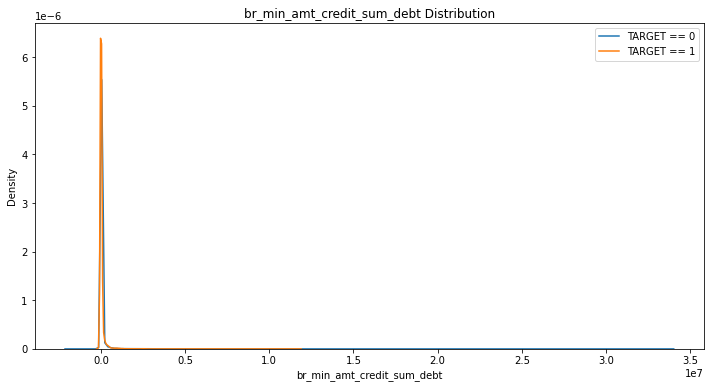

In [304]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [305]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [306]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.000000                    0.002172
br_min_amt_credit_sum_debt  0.002172                    1.000000

The correlation between br_min_amt_credit_sum_debt and the TARGET is 0.0022
Median value for loan that was not repaid = -0.0937
Median value for loan that was repaid =     -0.0937


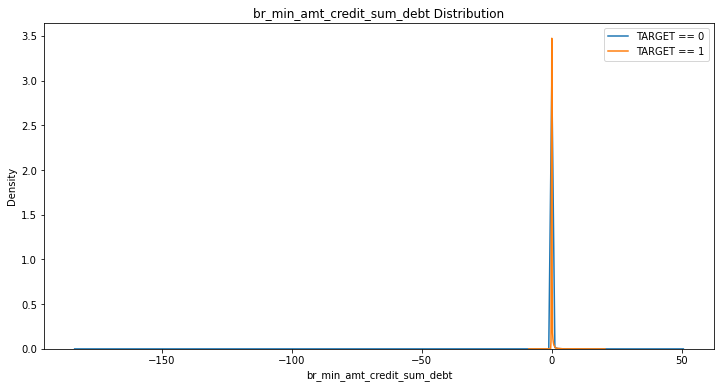

In [307]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [308]:
app_train.drop(['br_min_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_debt'], axis=1, inplace=True)

### br_max_amt_credit_sum_debt

In [309]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.000979
br_max_amt_credit_sum_debt  0.000979                    1.000000

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0010
Median value for loan that was not repaid = 216611.7750
Median value for loan that was repaid =     155250.0000


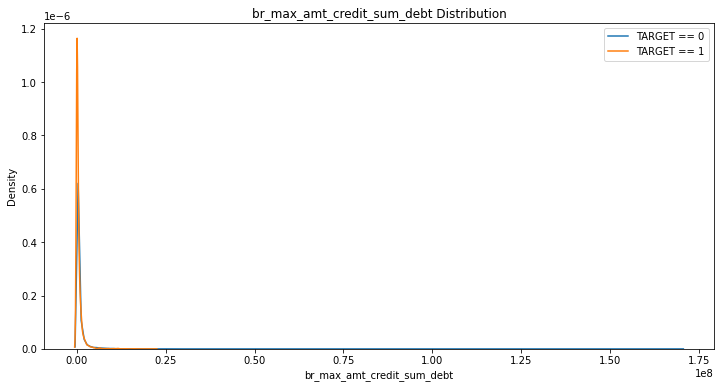

In [310]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

In [311]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [312]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.015617
br_max_amt_credit_sum_debt  0.015617                    1.000000

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0156
Median value for loan that was not repaid = -0.1251
Median value for loan that was repaid =     -0.2293


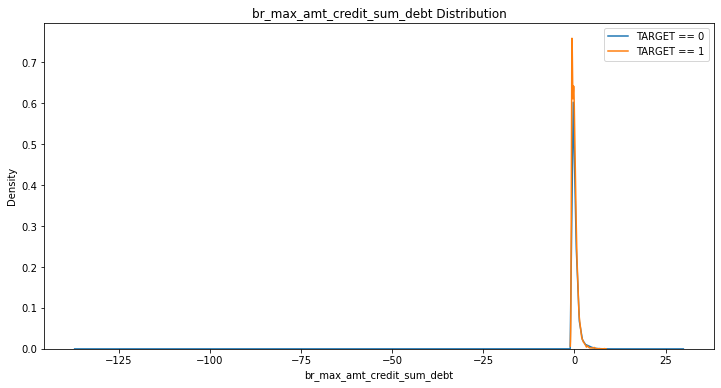

In [313]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

### br_sum_amt_credit_sum_debt

In [314]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                   -0.005482
br_sum_amt_credit_sum_debt -0.005482                    1.000000

The correlation between br_sum_amt_credit_sum_debt and the TARGET is -0.0055
Median value for loan that was not repaid = 2844288.0000
Median value for loan that was repaid =     2086762.5000


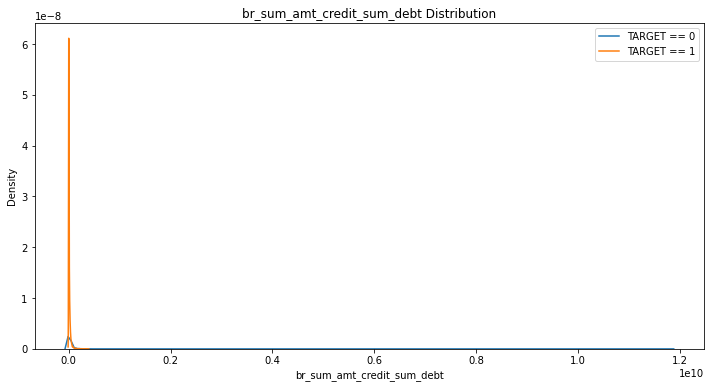

In [315]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [316]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [317]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                   -0.003189
br_sum_amt_credit_sum_debt -0.003189                    1.000000

The correlation between br_sum_amt_credit_sum_debt and the TARGET is -0.0032
Median value for loan that was not repaid = -0.2096
Median value for loan that was repaid =     -0.2365


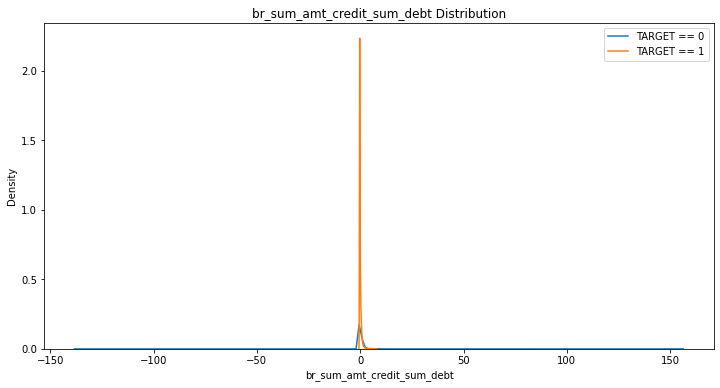

In [318]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [319]:
app_train.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)

### br_avg_amt_credit_sum_debt

In [320]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                   -0.000757
br_avg_amt_credit_sum_debt -0.000757                    1.000000

The correlation between br_avg_amt_credit_sum_debt and the TARGET is -0.0008
Median value for loan that was not repaid = 48532.1250
Median value for loan that was repaid =     28857.4054


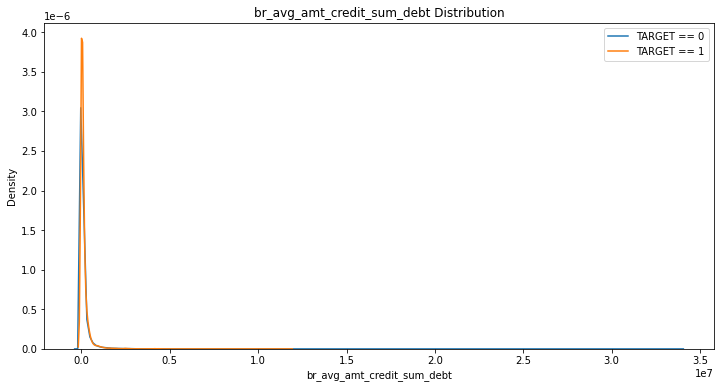

In [321]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [322]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [323]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                    0.008292
br_avg_amt_credit_sum_debt  0.008292                    1.000000

The correlation between br_avg_amt_credit_sum_debt and the TARGET is 0.0083
Median value for loan that was not repaid = -0.1632
Median value for loan that was repaid =     -0.2419


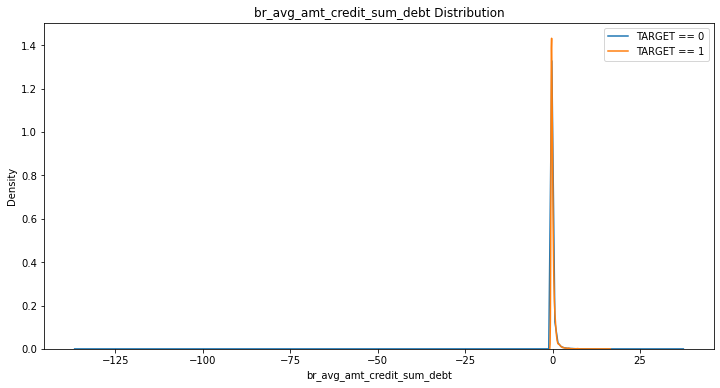

In [324]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [325]:
app_train.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)

### br_cnt_amt_credit_sum_debt

In [326]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.00000                    -0.03538
br_cnt_amt_credit_sum_debt -0.03538                     1.00000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0354
Median value for loan that was not repaid = 67.0000
Median value for loan that was repaid =     83.0000


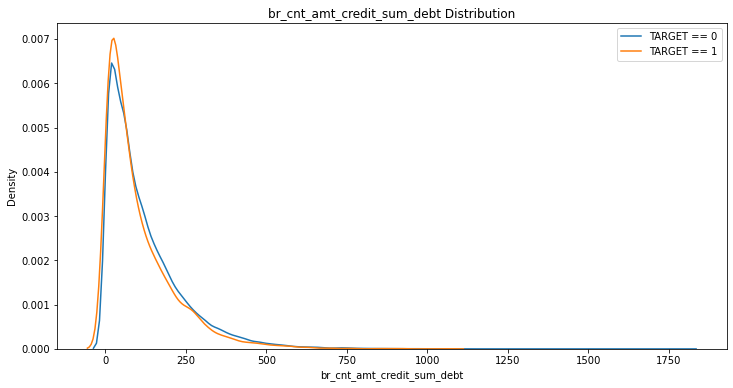

In [327]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

In [328]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [329]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.042109
br_cnt_amt_credit_sum_debt -0.042109                    1.000000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0421
Median value for loan that was not repaid = -0.1634
Median value for loan that was repaid =     0.0212


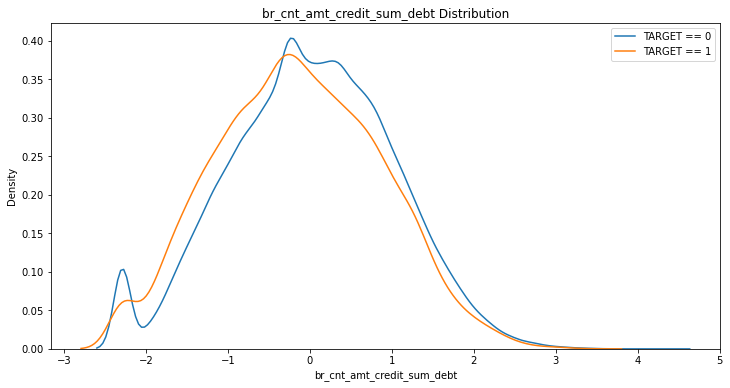

In [330]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

### br_stddev_amt_credit_sum_debt

In [331]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                      -0.000183
br_stddev_amt_credit_sum_debt -0.000183                       1.000000

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is -0.0002
Median value for loan that was not repaid = 57095.1592
Median value for loan that was repaid =     38260.2170


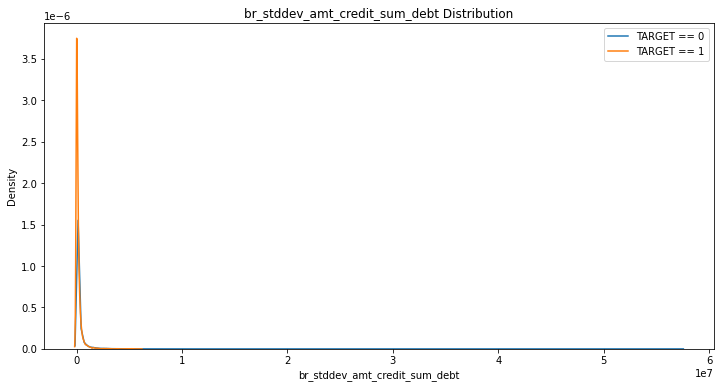

In [332]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [333]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [334]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                       0.029915
br_stddev_amt_credit_sum_debt  0.029915                       1.000000

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is 0.0299
Median value for loan that was not repaid = 0.5115
Median value for loan that was repaid =     0.4053


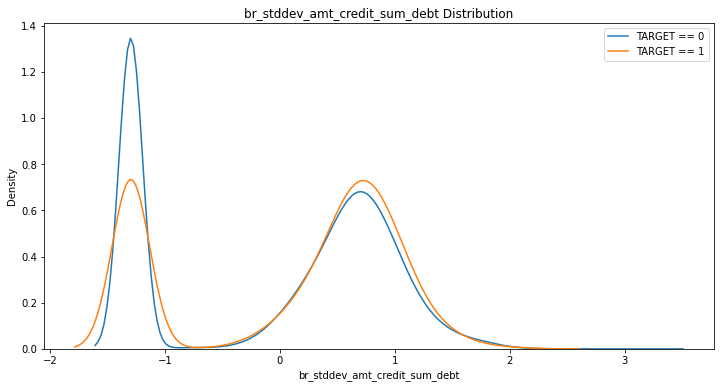

In [335]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

### br_stddev_pop_amt_credit_sum_debt

In [336]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

TARGET  br_stddev_pop_amt_credit_sum_debt
TARGET                             1.000000                          -0.000183
br_stddev_pop_amt_credit_sum_debt -0.000183                           1.000000

The correlation between br_stddev_pop_amt_credit_sum_debt and the TARGET is -0.0002
Median value for loan that was not repaid = 57095.1592
Median value for loan that was repaid =     38260.2170


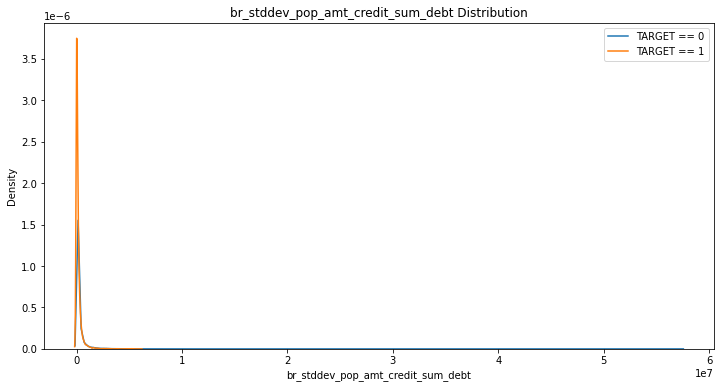

In [337]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [338]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [339]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.040489
br_sum_amt_credit_max_overdue  0.040489                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0405
Median value for loan that was not repaid = -0.5441
Median value for loan that was repaid =     -0.5441


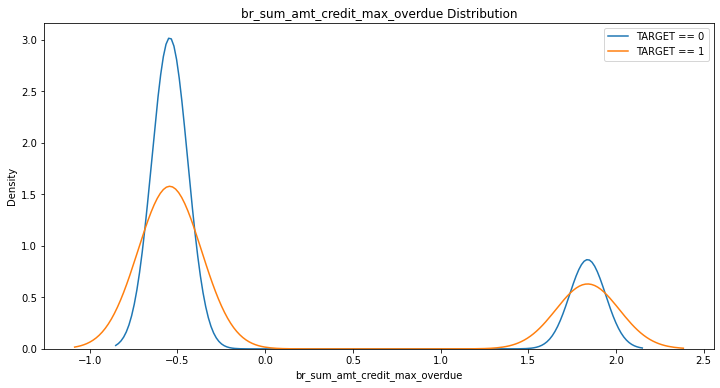

In [340]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_max_overdue', app_train)

### br_var_pop_amt_credit_sum_debt

In [341]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.00000                        -0.00215
br_var_pop_amt_credit_sum_debt -0.00215                         1.00000

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is -0.0021
Median value for loan that was not repaid = 3259857204.4701
Median value for loan that was repaid =     1463844202.8261


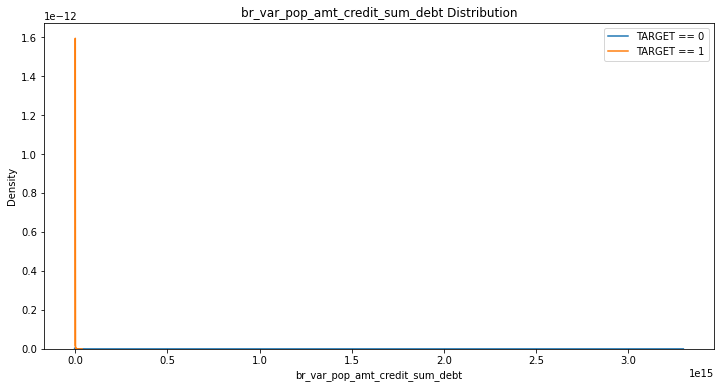

In [342]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [343]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [344]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.000000                        0.029914
br_var_pop_amt_credit_sum_debt  0.029914                        1.000000

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is 0.0299
Median value for loan that was not repaid = 0.5116
Median value for loan that was repaid =     0.4053


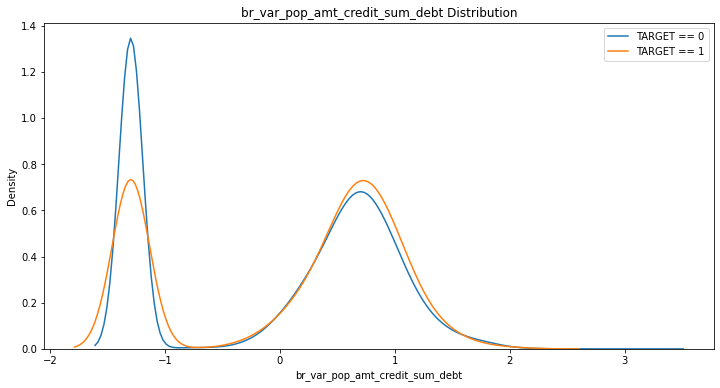

In [345]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

### br_var_samp_amt_credit_sum_debt

In [346]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                        -0.002157
br_var_samp_amt_credit_sum_debt -0.002157                         1.000000

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is -0.0022
Median value for loan that was not repaid = 3334031791.3840
Median value for loan that was repaid =     1492970065.0713


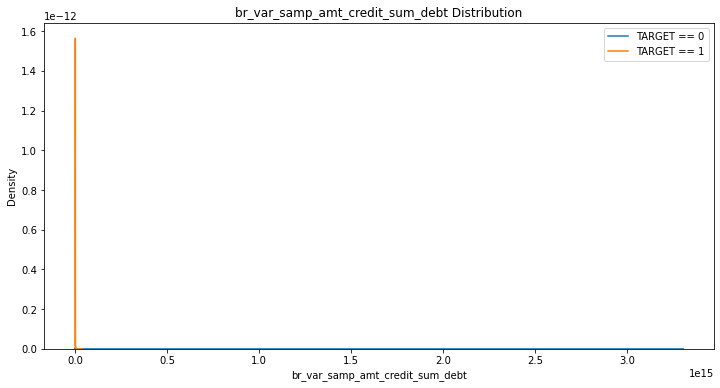

In [347]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [348]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [349]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                         0.030046
br_var_samp_amt_credit_sum_debt  0.030046                         1.000000

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is 0.0300
Median value for loan that was not repaid = 0.5123
Median value for loan that was repaid =     0.4057


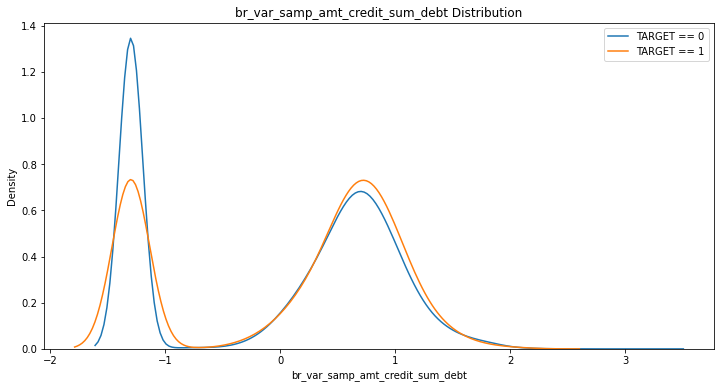

In [350]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

### br_variance_pop_amt_credit_sum_debt

In [351]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.00000   
br_variance_pop_amt_credit_sum_debt -0.00215   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                          -0.00215  
br_variance_pop_amt_credit_sum_debt                              1.00000

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is -0.0021
Median value for loan that was not repaid = 3259857204.4701
Median value for loan that was repaid =     1463844202.8261


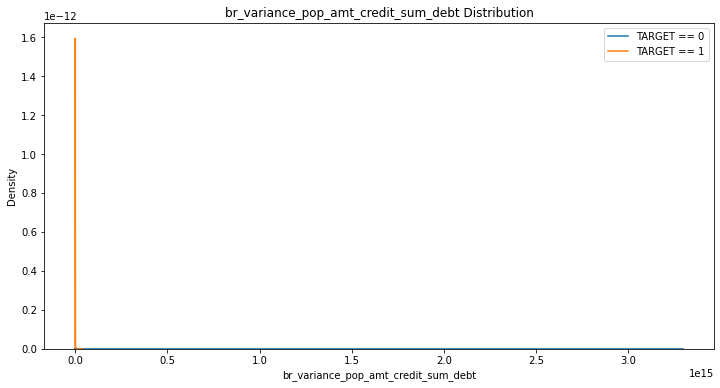

In [352]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [353]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [354]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_amt_credit_sum_debt  0.029914   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                          0.029914  
br_variance_pop_amt_credit_sum_debt                             1.000000

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is 0.0299
Median value for loan that was not repaid = 0.5116
Median value for loan that was repaid =     0.4053


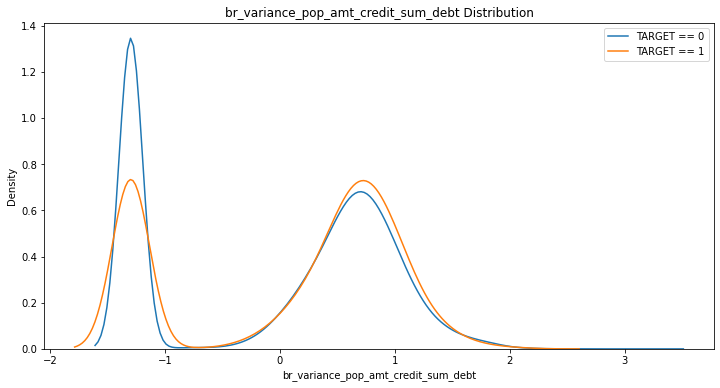

In [355]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

### br_min_amt_credit_sum_limit

In [356]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.005803
br_min_amt_credit_sum_limit -0.005803                     1.000000

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


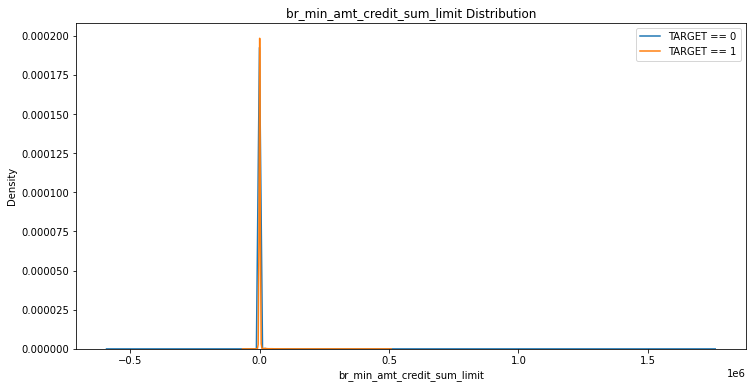

In [357]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [358]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [359]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.00000                     -0.00352
br_min_amt_credit_sum_limit -0.00352                      1.00000

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0035
Median value for loan that was not repaid = -0.0410
Median value for loan that was repaid =     -0.0410


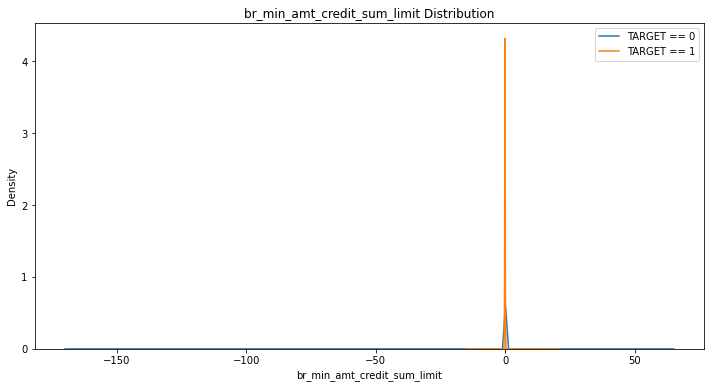

In [360]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [361]:
app_train.drop(['br_min_amt_credit_sum_limit'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_limit'], axis=1, inplace=True)

### br_max_amt_credit_sum_limit

In [362]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.00000                     -0.01289
br_max_amt_credit_sum_limit -0.01289                      1.00000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0129
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


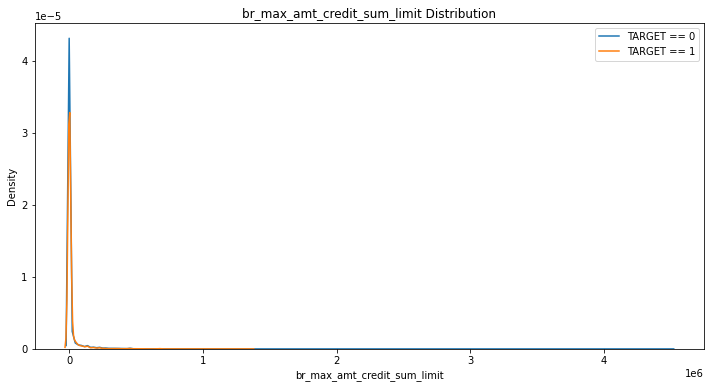

In [363]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

In [364]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [365]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [366]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum_limit', app_train)

### br_sum_amt_credit_sum_limit

In [367]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.015135
br_sum_amt_credit_sum_limit -0.015135                     1.000000

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0151
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


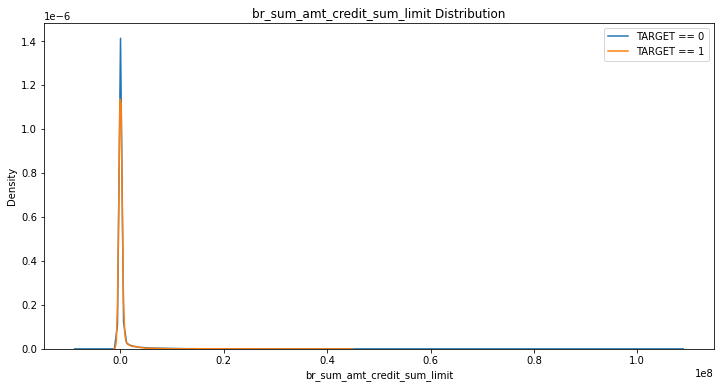

In [368]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

In [369]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [370]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

In [371]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_limit', app_train)

### br_avg_amt_credit_sum_limit

In [372]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

TARGET  br_avg_amt_credit_sum_limit
TARGET                       1.000000                    -0.011125
br_avg_amt_credit_sum_limit -0.011125                     1.000000

The correlation between br_avg_amt_credit_sum_limit and the TARGET is -0.0111
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


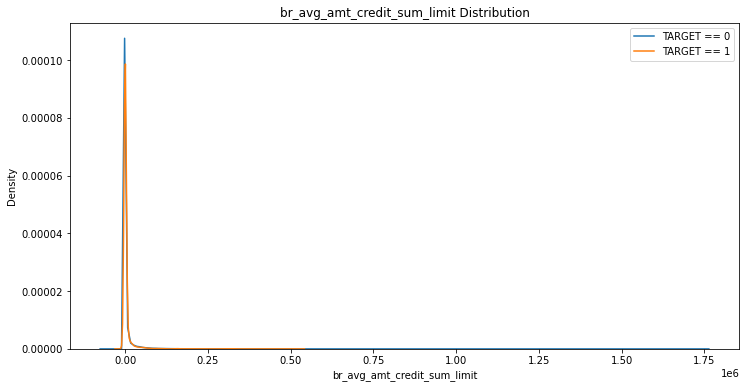

In [373]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_limit', app_train)

In [374]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [375]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [376]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_limit', app_train)

### br_cnt_amt_credit_sum_limit

In [377]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.033391
br_cnt_amt_credit_sum_limit -0.033391                     1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0334
Median value for loan that was not repaid = 48.0000
Median value for loan that was repaid =     60.0000


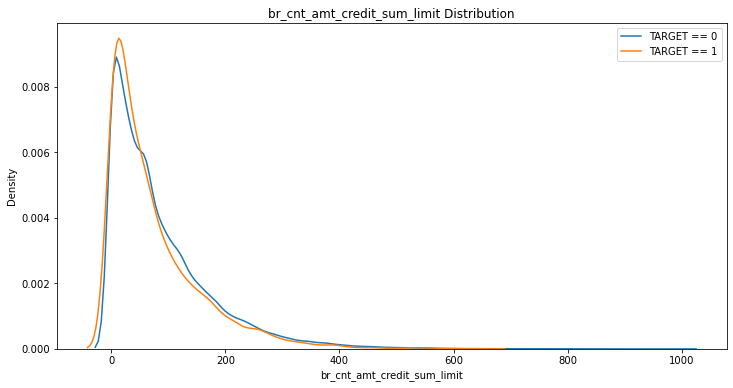

In [378]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

In [379]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [380]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.035782
br_cnt_amt_credit_sum_limit -0.035782                     1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0358
Median value for loan that was not repaid = -0.0986
Median value for loan that was repaid =     0.0753


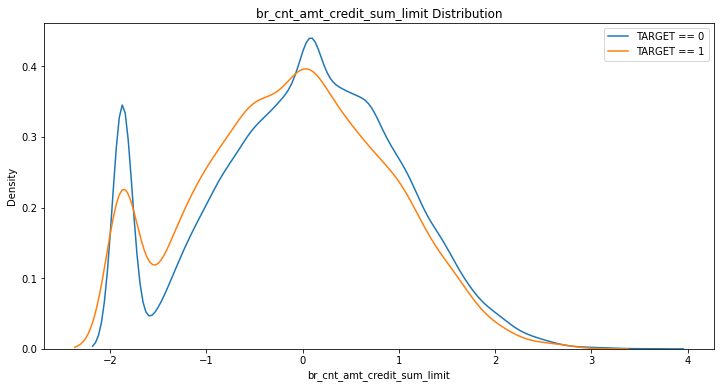

In [381]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

### br_stddev_amt_credit_sum_limit

In [382]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.000000                       -0.011589
br_stddev_amt_credit_sum_limit -0.011589                        1.000000

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


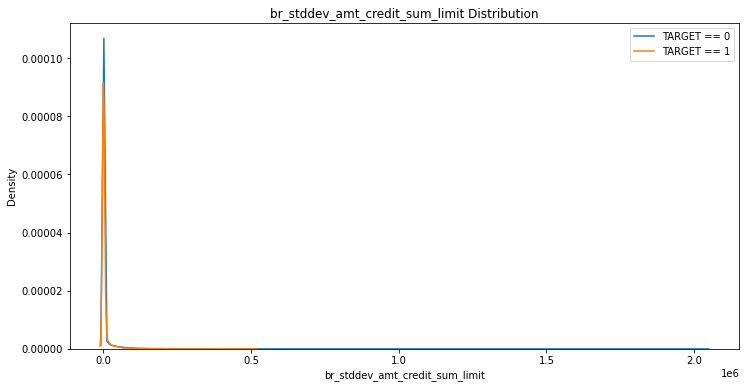

In [383]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [384]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [385]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.000000                        0.036388
br_stddev_amt_credit_sum_limit  0.036388                        1.000000

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4412
Median value for loan that was repaid =     -0.4412


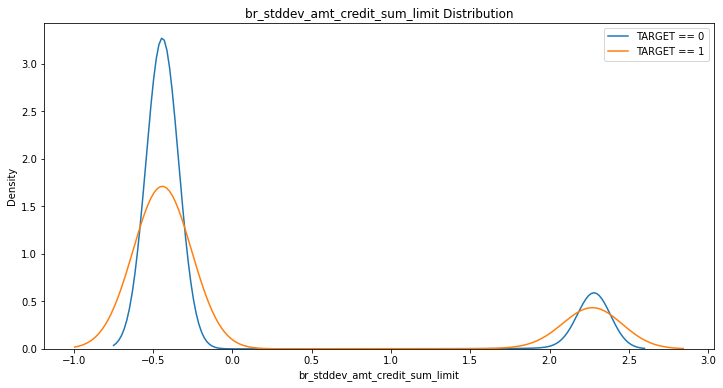

In [386]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

### br_stddev_pop_amt_credit_sum_limit

In [387]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.000000   
br_stddev_pop_amt_credit_sum_limit -0.011589   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                       -0.011589  
br_stddev_pop_amt_credit_sum_limit                            1.000000

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


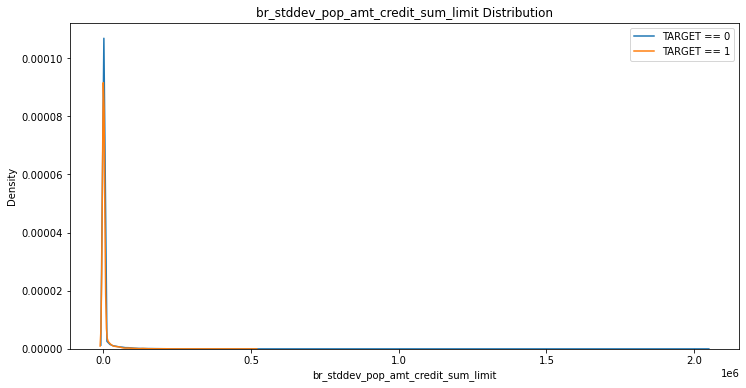

In [388]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [389]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [390]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.000000   
br_stddev_pop_amt_credit_sum_limit  0.036388   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                        0.036388  
br_stddev_pop_amt_credit_sum_limit                            1.000000

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4412
Median value for loan that was repaid =     -0.4412


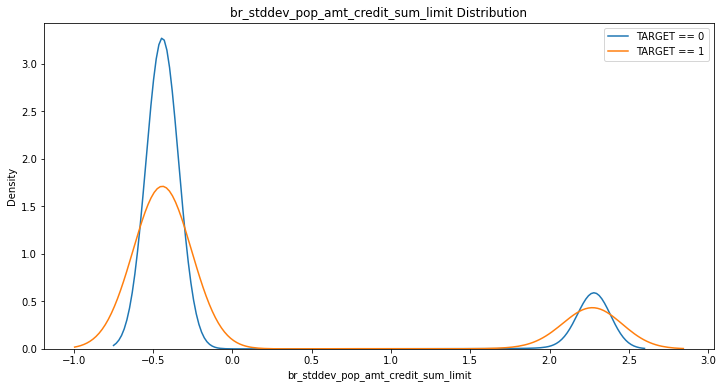

In [391]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

### br_var_pop_amt_credit_sum_limit

In [392]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.004928
br_var_pop_amt_credit_sum_limit -0.004928                         1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


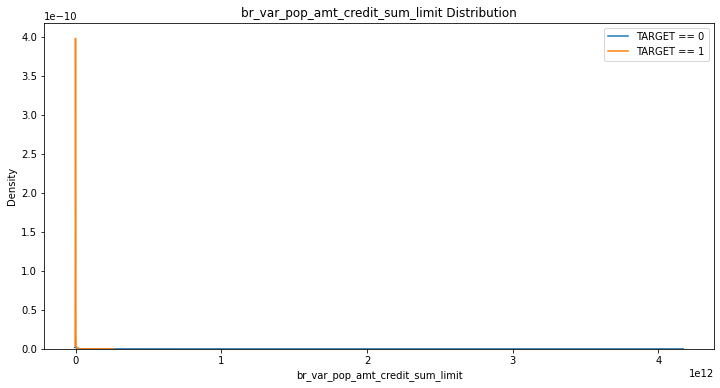

In [393]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

In [394]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [395]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                         0.036299
br_var_pop_amt_credit_sum_limit  0.036299                         1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is 0.0363
Median value for loan that was not repaid = -0.4410
Median value for loan that was repaid =     -0.4410


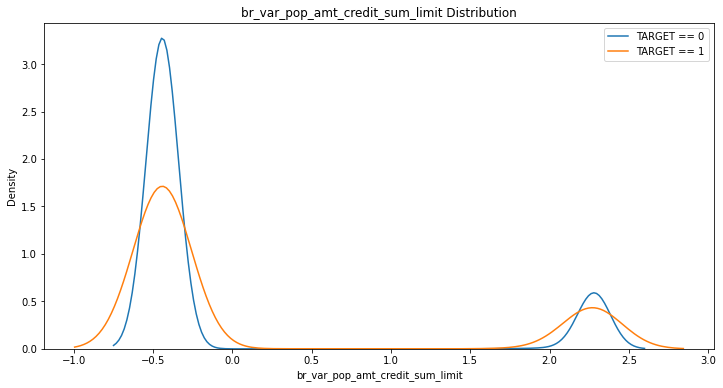

In [396]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

### br_var_samp_amt_credit_sum_limit

In [397]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.004898
br_var_samp_amt_credit_sum_limit -0.004898                          1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


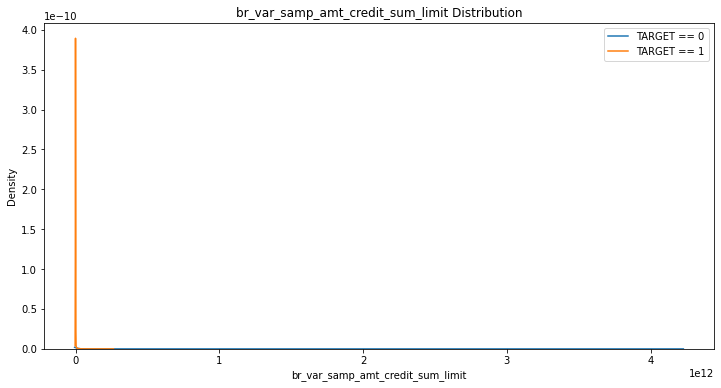

In [398]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

In [399]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [400]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                          0.036305
br_var_samp_amt_credit_sum_limit  0.036305                          1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is 0.0363
Median value for loan that was not repaid = -0.4410
Median value for loan that was repaid =     -0.4410


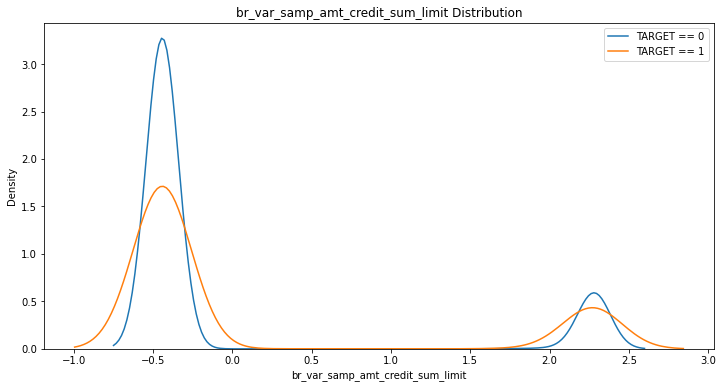

In [401]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

### br_variance_pop_amt_credit_sum_limit

In [402]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.004928   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.004928  
br_variance_pop_amt_credit_sum_limit                              1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


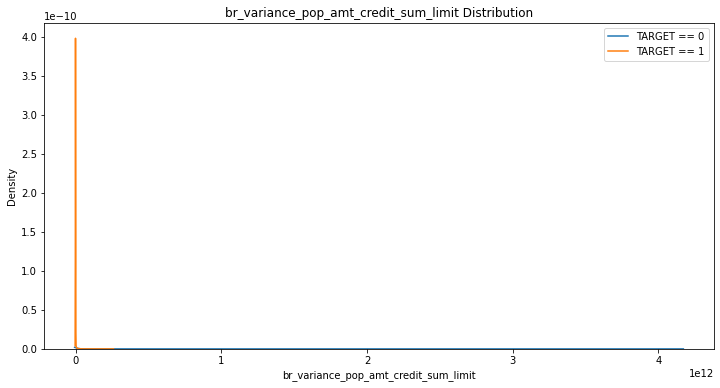

In [403]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

In [404]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [405]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit  0.036299   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                            0.036299  
br_variance_pop_amt_credit_sum_limit                              1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is 0.0363
Median value for loan that was not repaid = -0.4410
Median value for loan that was repaid =     -0.4410


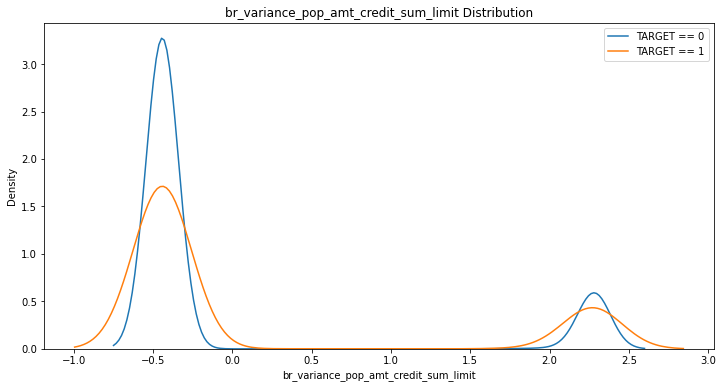

In [406]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

### br_min_amt_credit_sum_overdue

In [407]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                      -0.000443
br_min_amt_credit_sum_overdue -0.000443                       1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is -0.0004
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


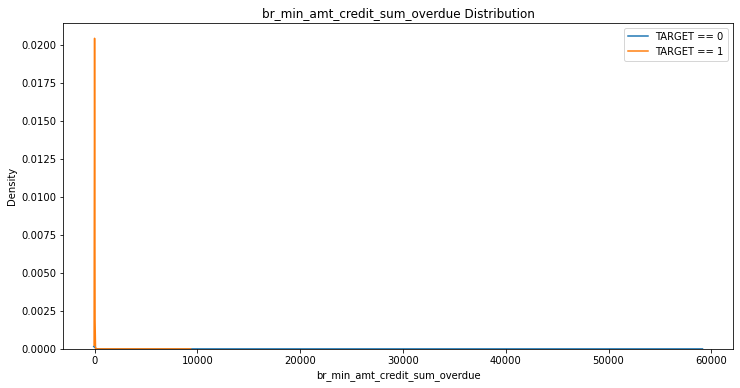

In [408]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [409]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [410]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.008976
br_min_amt_credit_sum_overdue  0.008976                       1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is 0.0090
Median value for loan that was not repaid = -0.0245
Median value for loan that was repaid =     -0.0245


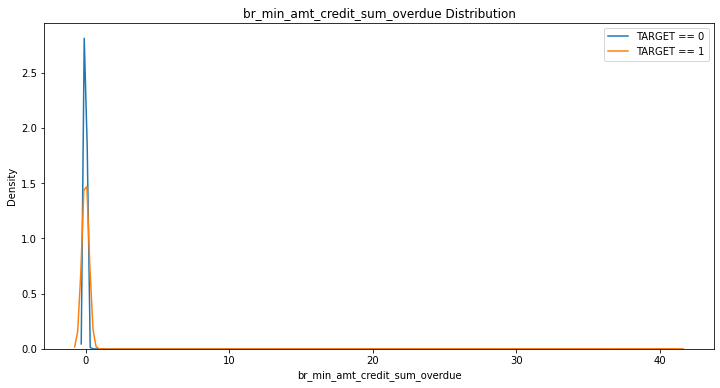

In [411]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [412]:
app_train.drop(['br_min_amt_credit_sum_overdue'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_overdue'], axis=1, inplace=True)

### br_max_amt_credit_sum_overdue

In [413]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.018012
br_max_amt_credit_sum_overdue  0.018012                       1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0180
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


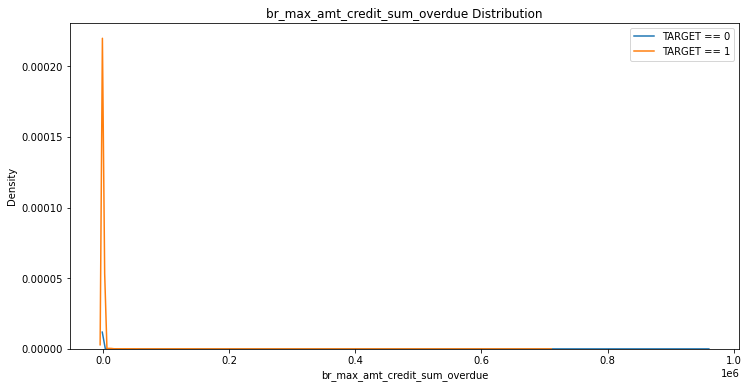

In [414]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

In [415]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [416]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.033745
br_max_amt_credit_sum_overdue  0.033745                       1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0337
Median value for loan that was not repaid = -0.1142
Median value for loan that was repaid =     -0.1142


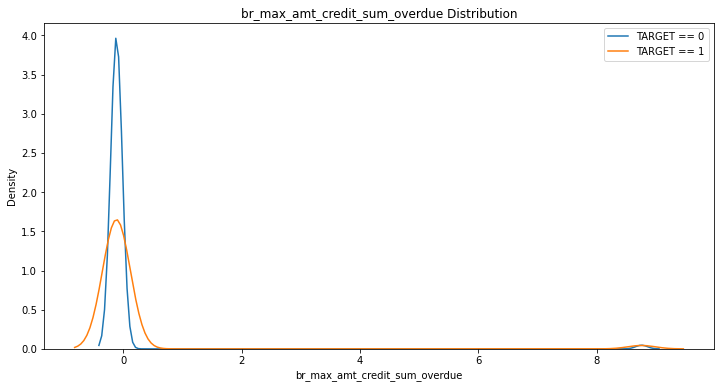

In [417]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

### br_sum_amt_credit_sum_overdue

In [418]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.006955
br_sum_amt_credit_sum_overdue  0.006955                       1.000000

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0070
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


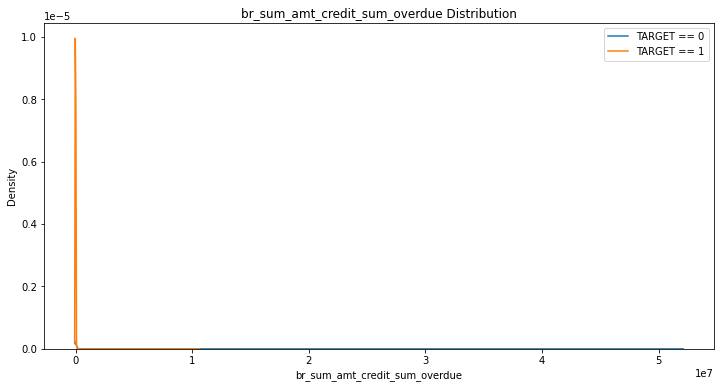

In [419]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [420]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [421]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.033741
br_sum_amt_credit_sum_overdue  0.033741                       1.000000

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0337
Median value for loan that was not repaid = -0.1142
Median value for loan that was repaid =     -0.1142


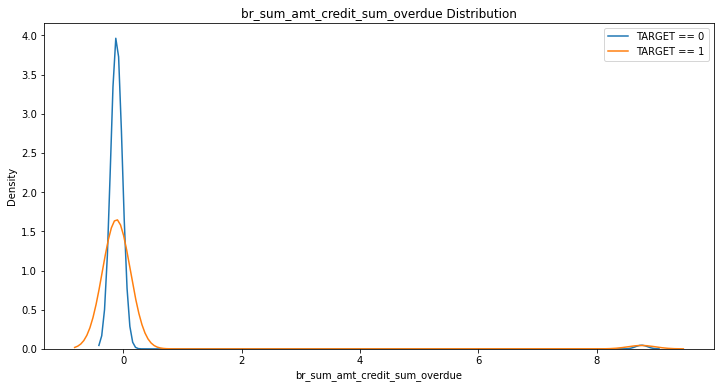

In [422]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

### br_avg_amt_credit_sum_overdue

In [423]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.018425
br_avg_amt_credit_sum_overdue  0.018425                       1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0184
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


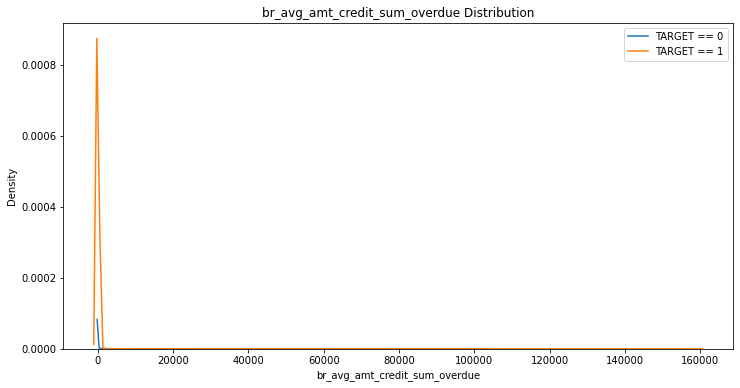

In [424]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

In [425]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [426]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.033826
br_avg_amt_credit_sum_overdue  0.033826                       1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0338
Median value for loan that was not repaid = -0.1141
Median value for loan that was repaid =     -0.1141


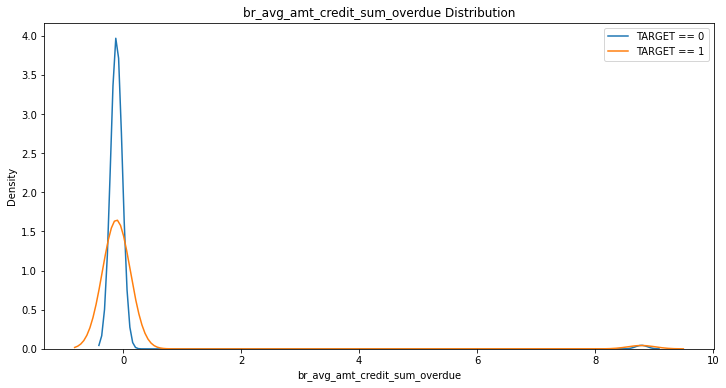

In [427]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

### br_cnt_amt_credit_sum_overdue

In [428]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.040412
br_cnt_amt_credit_sum_overdue -0.040412                       1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


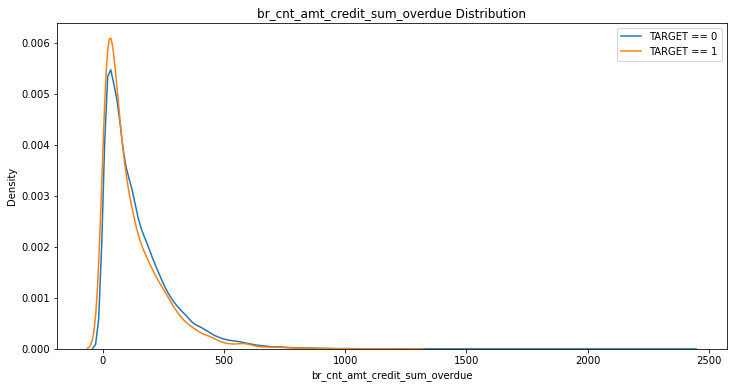

In [429]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

In [430]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [431]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.052954
br_cnt_amt_credit_sum_overdue -0.052954                       1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0530
Median value for loan that was not repaid = -0.1841
Median value for loan that was repaid =     0.0410


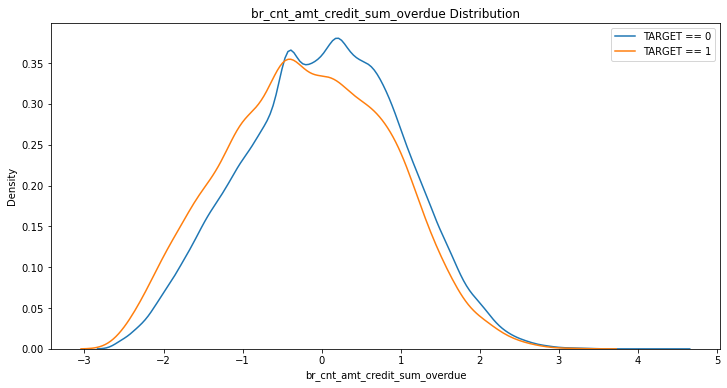

In [432]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

### br_stddev_amt_credit_sum_overdue

In [433]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.00000                           0.01918
br_stddev_amt_credit_sum_overdue  0.01918                           1.00000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0192
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


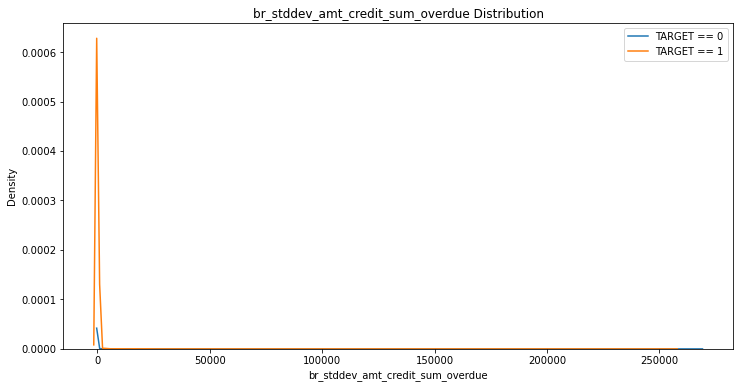

In [434]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

In [435]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [436]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.032571
br_stddev_amt_credit_sum_overdue  0.032571                          1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0326
Median value for loan that was not repaid = -0.1115
Median value for loan that was repaid =     -0.1115


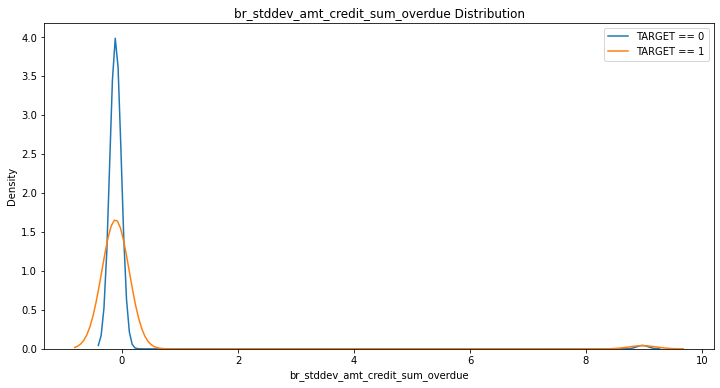

In [437]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

### br_stddev_pop_amt_credit_sum_overdue

In [438]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.00000   
br_stddev_pop_amt_credit_sum_overdue  0.01918   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                             0.01918  
br_stddev_pop_amt_credit_sum_overdue                               1.00000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0192
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


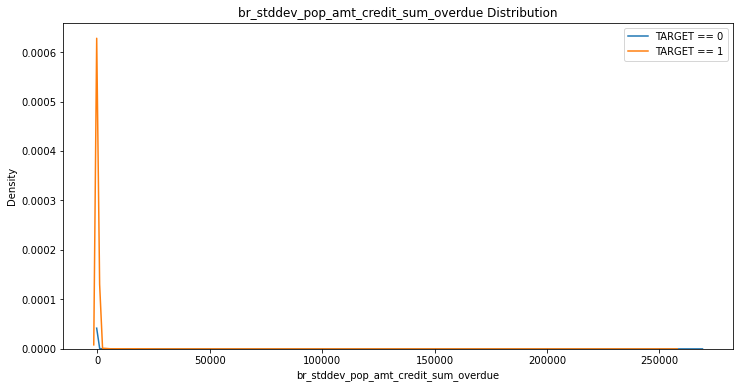

In [439]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

In [440]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [441]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.032571   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.032571  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0326
Median value for loan that was not repaid = -0.1115
Median value for loan that was repaid =     -0.1115


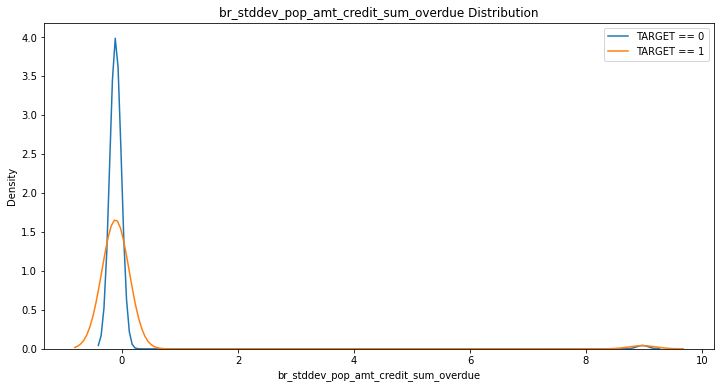

In [442]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

### br_var_pop_amt_credit_sum_overdue

In [443]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.007761
br_var_pop_amt_credit_sum_overdue  0.007761                           1.000000

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


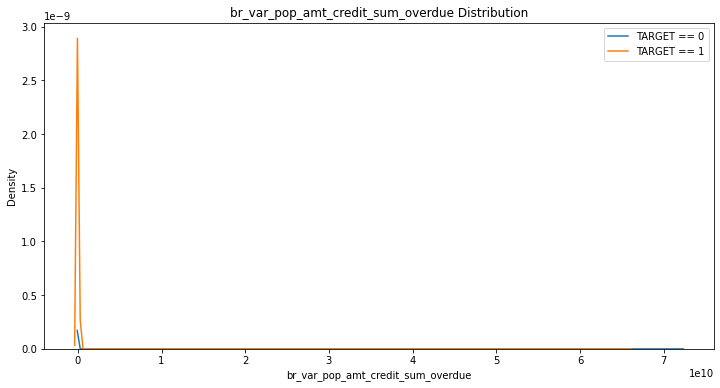

In [444]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [445]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [446]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.00000                            0.03268
br_var_pop_amt_credit_sum_overdue  0.03268                            1.00000

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0327
Median value for loan that was not repaid = -0.1113
Median value for loan that was repaid =     -0.1113


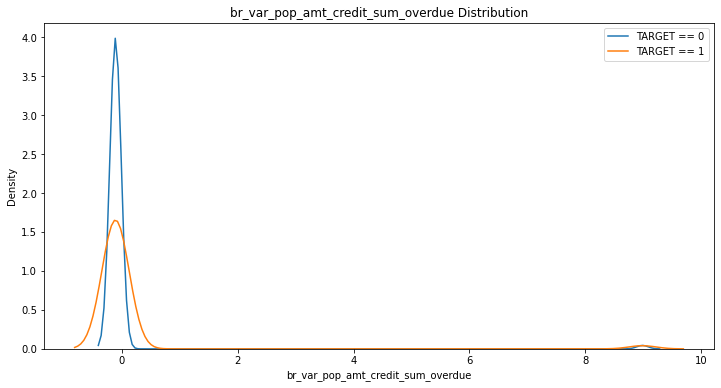

In [447]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

### br_var_samp_amt_credit_sum_overdue

In [448]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.007824   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.007824  
br_var_samp_amt_credit_sum_overdue                            1.000000

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


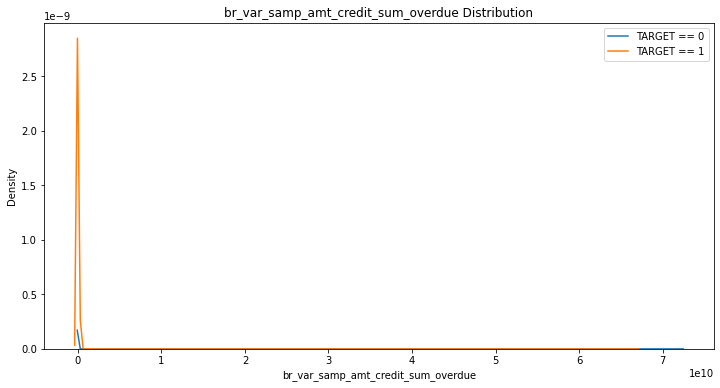

In [449]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [450]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [451]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.00000   
br_var_samp_amt_credit_sum_overdue  0.03268   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                         0.03268  
br_var_samp_amt_credit_sum_overdue                             1.00000

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0327
Median value for loan that was not repaid = -0.1113
Median value for loan that was repaid =     -0.1113


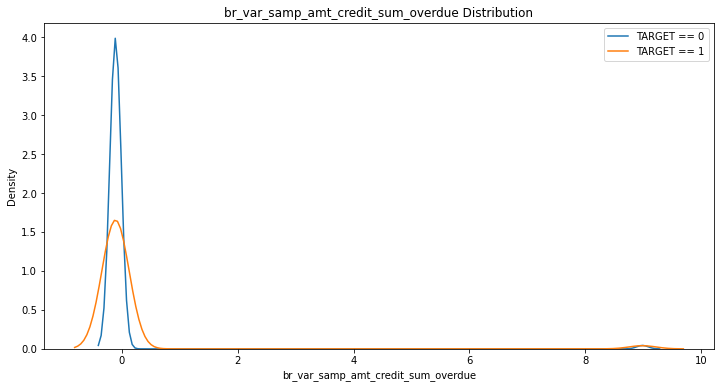

In [452]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

### br_variance_pop_amt_credit_sum_overdue

In [453]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_sum_overdue  0.007761   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                0.007761  
br_variance_pop_amt_credit_sum_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


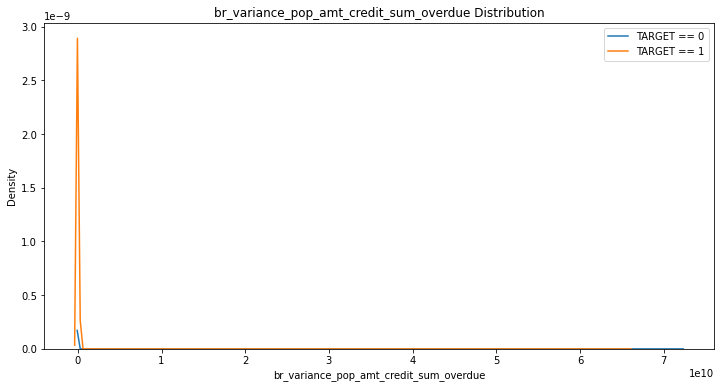

In [454]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [455]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [456]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.00000   
br_variance_pop_amt_credit_sum_overdue  0.03268   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                 0.03268  
br_variance_pop_amt_credit_sum_overdue                                 1.00000

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0327
Median value for loan that was not repaid = -0.1113
Median value for loan that was repaid =     -0.1113


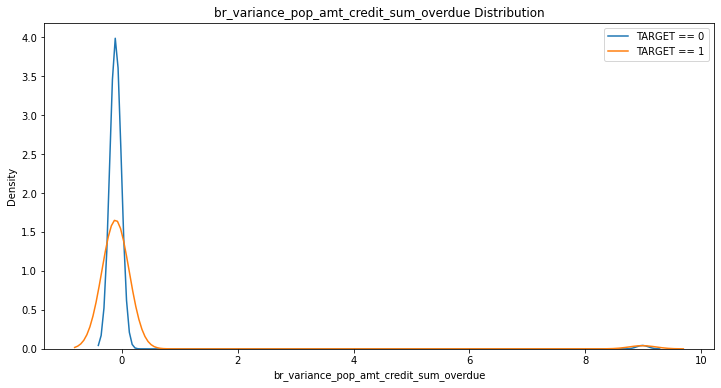

In [457]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

### br_min_days_credit_update

In [458]:
## 目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.051165
br_min_days_credit_update  0.051165                   1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0512
Median value for loan that was not repaid = -779.0000
Median value for loan that was repaid =     -971.0000


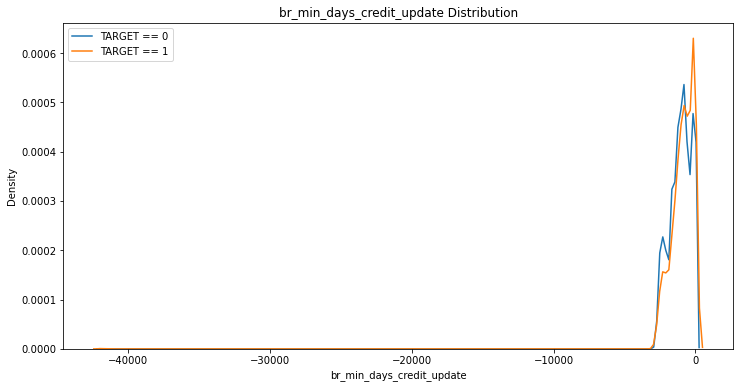

In [459]:
## 特徴量の分布
kde_target('br_min_days_credit_update', app_train)

In [460]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_update'] = pt.transform(app_test[num_cols])

In [461]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.062835
br_min_days_credit_update  0.062835                   1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0628
Median value for loan that was not repaid = 0.0919
Median value for loan that was repaid =     -0.1470


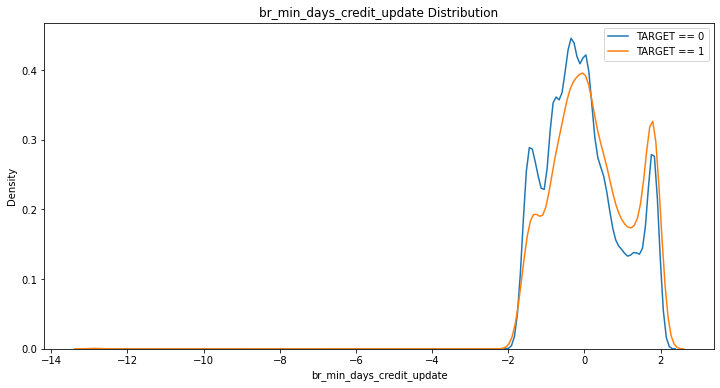

In [462]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_update', app_train)

### br_max_days_credit_update

In [463]:
## 目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.00000                    0.02751
br_max_days_credit_update  0.02751                    1.00000

The correlation between br_max_days_credit_update and the TARGET is 0.0275
Median value for loan that was not repaid = -13.0000
Median value for loan that was repaid =     -16.0000


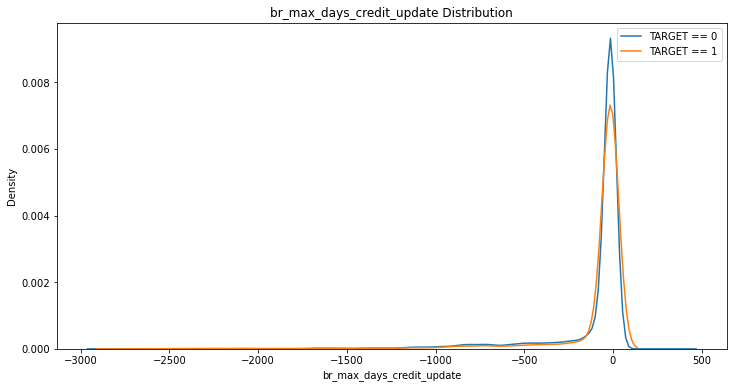

In [464]:
## 特徴量の分布
kde_target('br_max_days_credit_update', app_train)

In [465]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_update'] = pt.transform(app_test[num_cols])

In [466]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.031135
br_max_days_credit_update  0.031135                   1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0311
Median value for loan that was not repaid = 0.3781
Median value for loan that was repaid =     0.3431


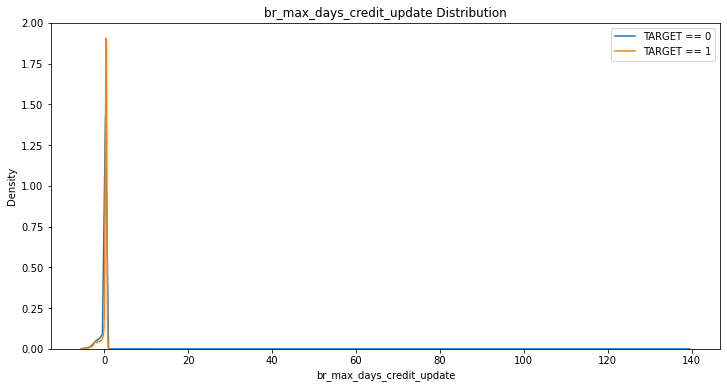

In [467]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_update', app_train)

### br_sum_days_credit_update

In [468]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.050243
br_sum_days_credit_update  0.050243                   1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0502
Median value for loan that was not repaid = -30879.0000
Median value for loan that was repaid =     -53714.0000


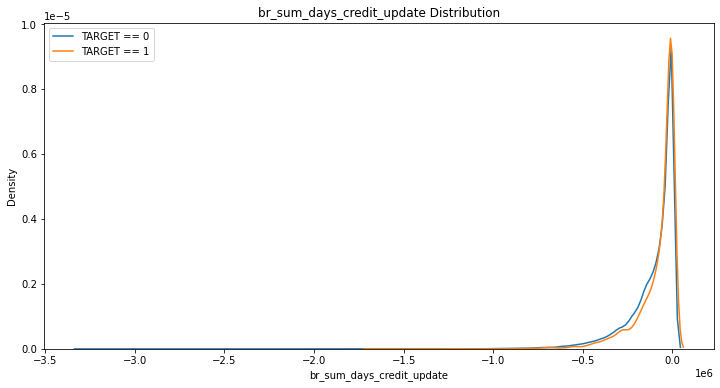

In [469]:
## 特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

In [470]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_update'] = pt.transform(app_test[num_cols])

In [471]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.068131
br_sum_days_credit_update  0.068131                   1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0681
Median value for loan that was not repaid = 0.1966
Median value for loan that was repaid =     -0.1037


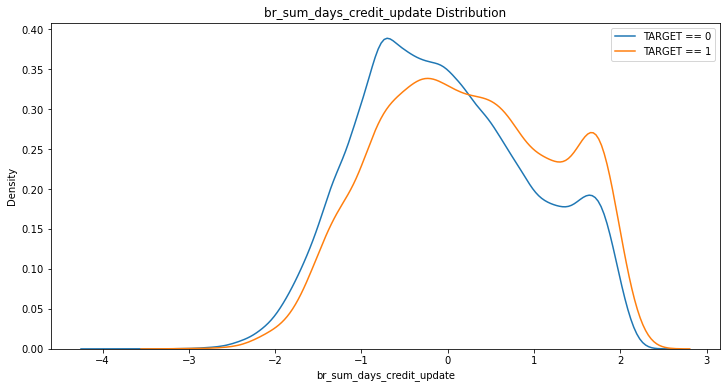

In [472]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

### br_avg_days_credit_update

In [473]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.065588
br_avg_days_credit_update  0.065588                   1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0656
Median value for loan that was not repaid = -380.9533
Median value for loan that was repaid =     -520.2543


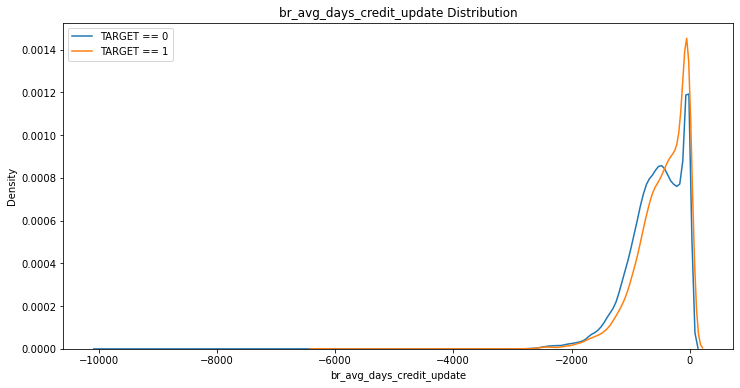

In [474]:
## 特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

In [475]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_update'] = pt.transform(app_test[num_cols])

In [476]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.071936
br_avg_days_credit_update  0.071936                   1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0719
Median value for loan that was not repaid = 0.1708
Median value for loan that was repaid =     -0.1498


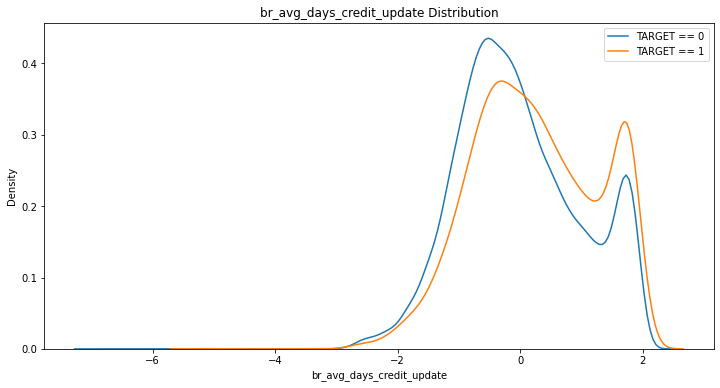

In [477]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

### br_cnt_days_credit_update

In [478]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.040412
br_cnt_days_credit_update -0.040412                   1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


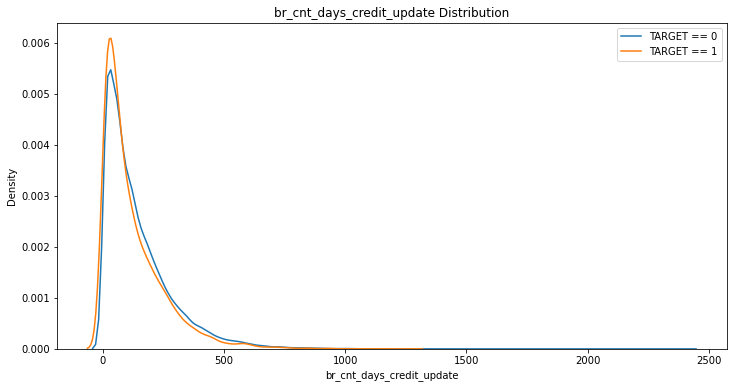

In [479]:
## 特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

In [480]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_update'] = pt.transform(app_test[num_cols])

In [481]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.052954
br_cnt_days_credit_update -0.052954                   1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0530
Median value for loan that was not repaid = -0.1841
Median value for loan that was repaid =     0.0410


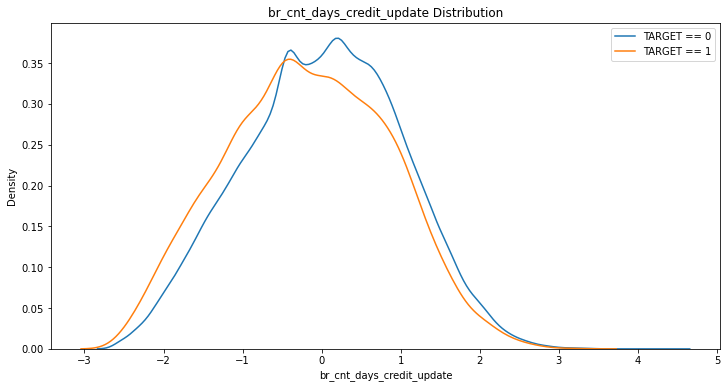

In [482]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

### br_stddev_days_credit_update

In [483]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.040617
br_stddev_days_credit_update -0.040617                      1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0406
Median value for loan that was not repaid = 253.5000
Median value for loan that was repaid =     310.0636


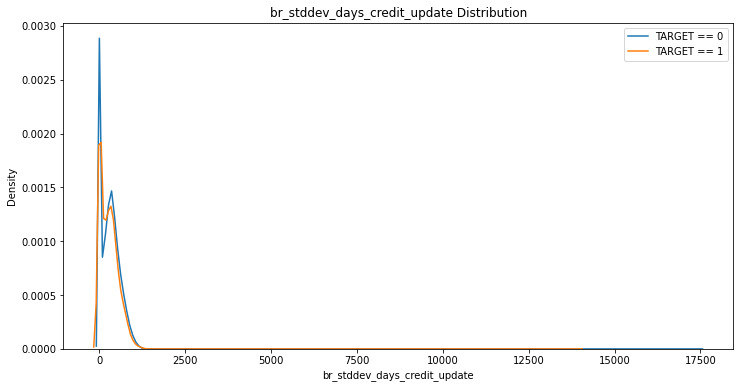

In [484]:
## 特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

In [485]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_credit_update'] = pt.transform(app_test[num_cols])

In [486]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.044598
br_stddev_days_credit_update -0.044598                      1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0446
Median value for loan that was not repaid = 0.0864
Median value for loan that was repaid =     0.2644


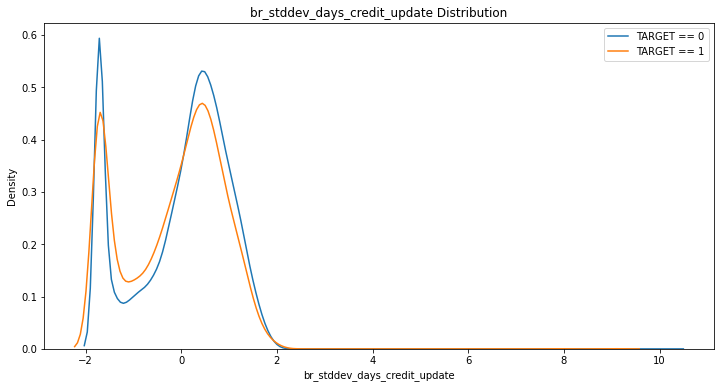

In [487]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

### br_stddev_pop_days_credit_update

In [488]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.040617
br_stddev_pop_days_credit_update -0.040617                          1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0406
Median value for loan that was not repaid = 253.5000
Median value for loan that was repaid =     310.0636


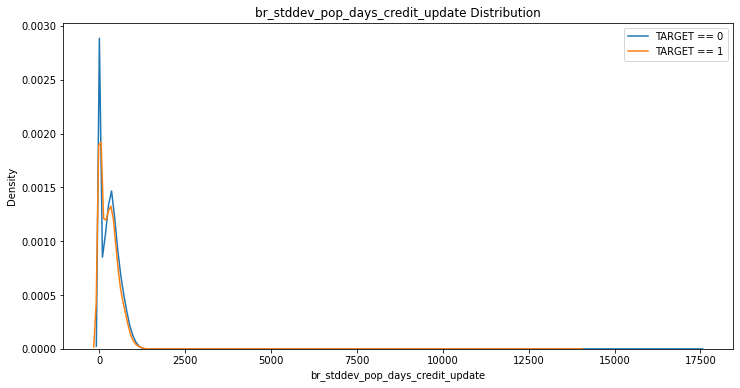

In [489]:
## 特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

In [490]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [491]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.044598
br_stddev_pop_days_credit_update -0.044598                          1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0446
Median value for loan that was not repaid = 0.0864
Median value for loan that was repaid =     0.2644


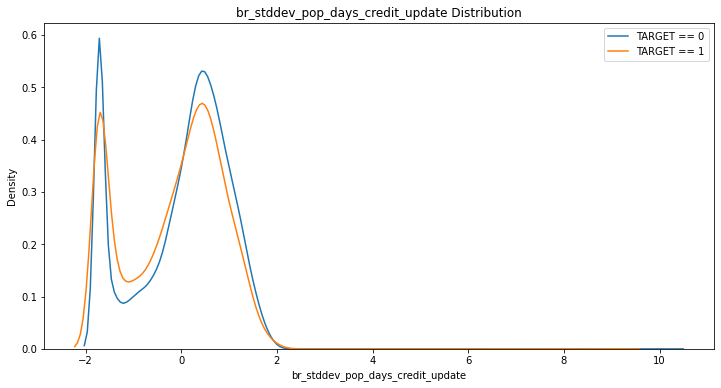

In [492]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

### br_var_pop_days_credit_update

In [493]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.000117
br_var_pop_days_credit_update -0.000117                       1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0001
Median value for loan that was not repaid = 64262.2500
Median value for loan that was repaid =     96139.4612


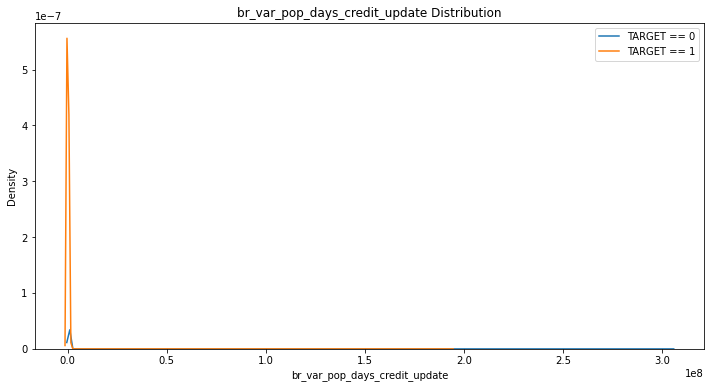

In [494]:
## 特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

In [495]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [496]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.044686
br_var_pop_days_credit_update -0.044686                       1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0447
Median value for loan that was not repaid = 0.0880
Median value for loan that was repaid =     0.2657


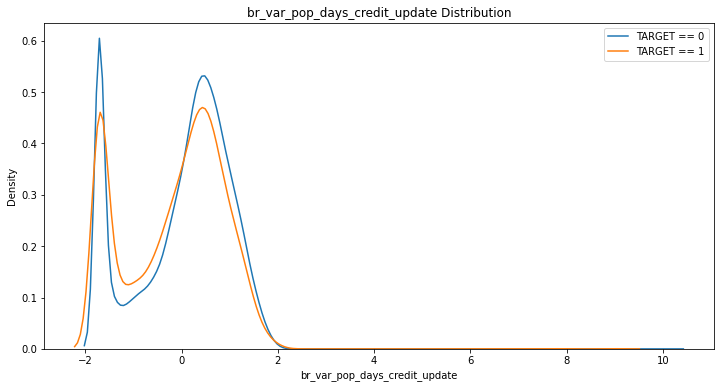

In [497]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

### br_var_samp_days_credit_update

In [498]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.000037
br_var_samp_days_credit_update -0.000037                        1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0000
Median value for loan that was not repaid = 65324.8336
Median value for loan that was repaid =     97233.0059


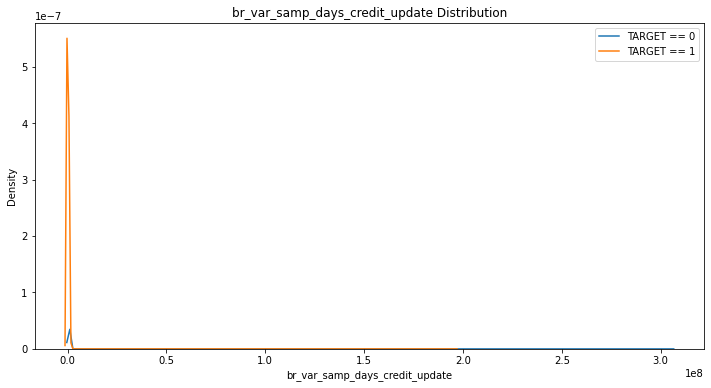

In [499]:
## 特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

In [500]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_credit_update'] = pt.transform(app_test[num_cols])

In [501]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.044509
br_var_samp_days_credit_update -0.044509                        1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0445
Median value for loan that was not repaid = 0.0894
Median value for loan that was repaid =     0.2654


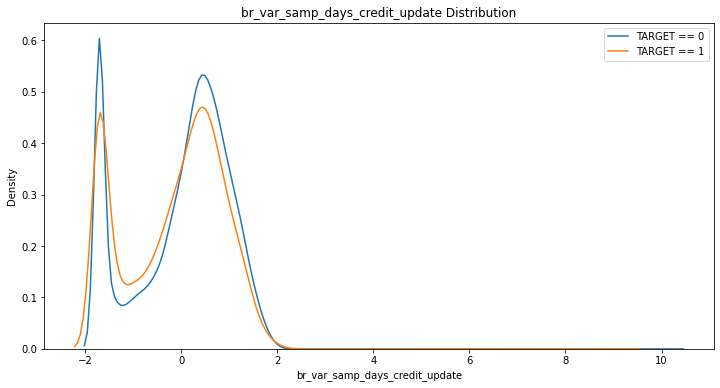

In [502]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

### br_variance_pop_days_credit_update

In [503]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.000117   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.000117  
br_variance_pop_days_credit_update                            1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0001
Median value for loan that was not repaid = 64262.2500
Median value for loan that was repaid =     96139.4612


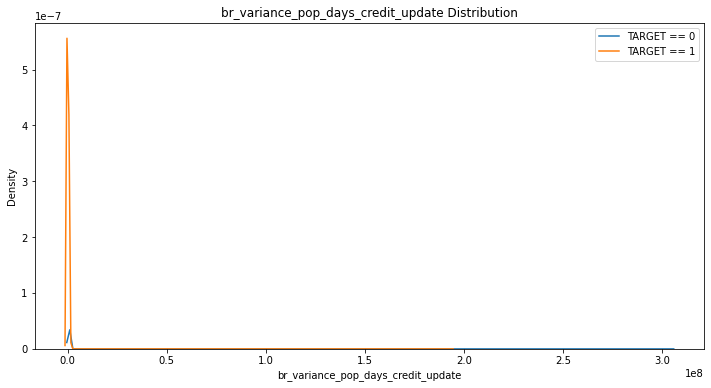

In [504]:
## 特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

In [505]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [506]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.044686   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.044686  
br_variance_pop_days_credit_update                            1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0447
Median value for loan that was not repaid = 0.0880
Median value for loan that was repaid =     0.2657


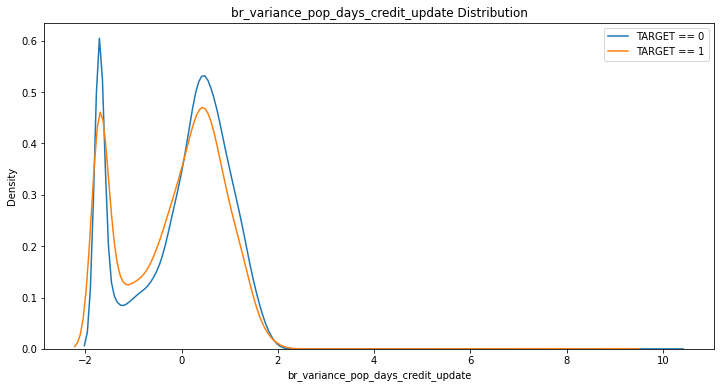

In [507]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

### br_min_amt_annuity

In [508]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.00000            -0.00252
br_min_amt_annuity -0.00252             1.00000

The correlation between br_min_amt_annuity and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


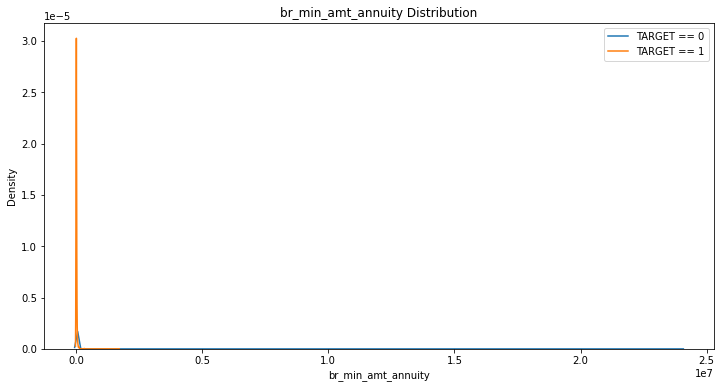

In [509]:
## 特徴量の分布
kde_target('br_min_amt_annuity', app_train)

In [510]:
## Yao-Johnson変換
num_cols = ['br_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_annuity'] = pt.transform(app_test[num_cols])

In [511]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.00000             0.03397
br_min_amt_annuity  0.03397             1.00000

The correlation between br_min_amt_annuity and the TARGET is 0.0340
Median value for loan that was not repaid = -0.8741
Median value for loan that was repaid =     -0.8741


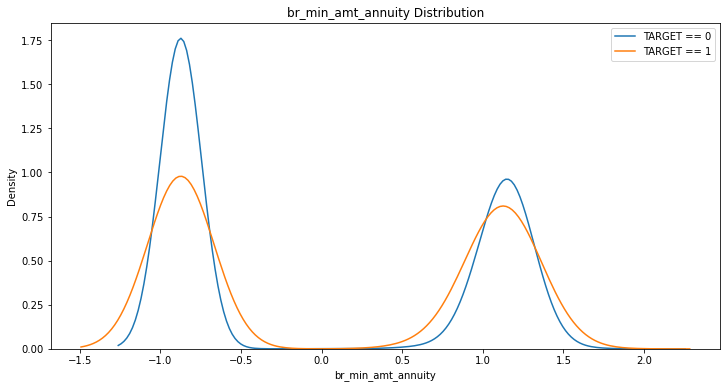

In [512]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_annuity', app_train)

### br_max_amt_annuity

In [513]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.001964
br_max_amt_annuity  0.001964            1.000000

The correlation between br_max_amt_annuity and the TARGET is 0.0020
Median value for loan that was not repaid = 8502.5700
Median value for loan that was repaid =     8370.0000


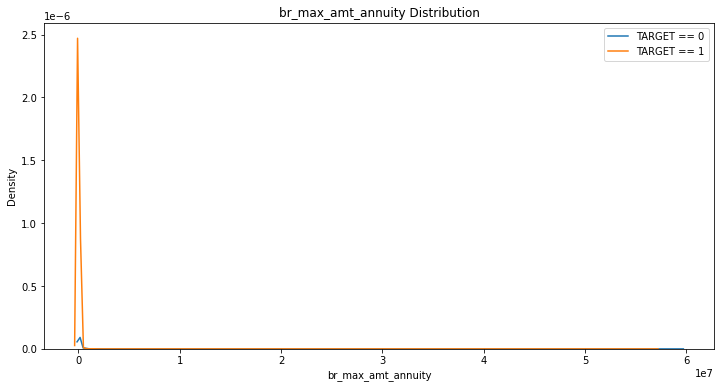

In [514]:
## 特徴量の分布
kde_target('br_max_amt_annuity', app_train)

In [515]:
## Yao-Johnson変換
num_cols = ['br_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_annuity'] = pt.transform(app_test[num_cols])

In [516]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.023339
br_max_amt_annuity  0.023339            1.000000

The correlation between br_max_amt_annuity and the TARGET is 0.0233
Median value for loan that was not repaid = 0.2636
Median value for loan that was repaid =     0.2572


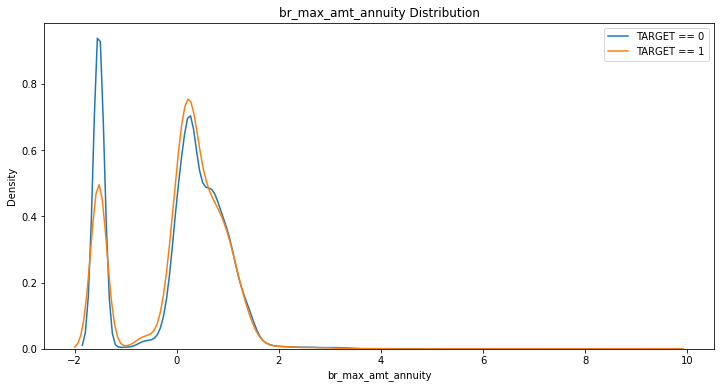

In [517]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_annuity', app_train)

### br_sum_amt_annuity

In [518]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000           -0.002962
br_sum_amt_annuity -0.002962            1.000000

The correlation between br_sum_amt_annuity and the TARGET is -0.0030
Median value for loan that was not repaid = 166500.0000
Median value for loan that was repaid =     149920.8750


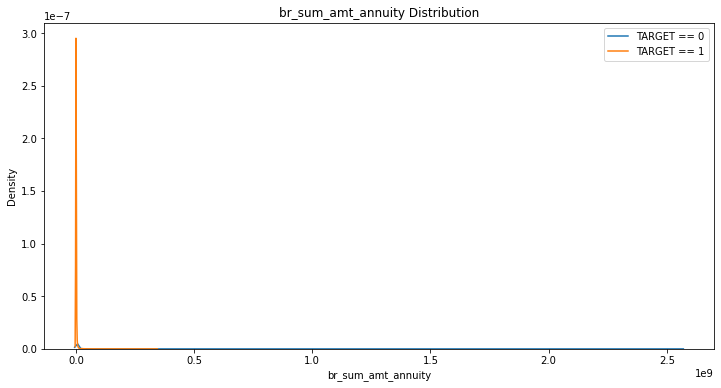

In [519]:
## 特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

In [520]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_annuity'] = pt.transform(app_test[num_cols])

In [521]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000            0.025658
br_sum_amt_annuity  0.025658            1.000000

The correlation between br_sum_amt_annuity and the TARGET is 0.0257
Median value for loan that was not repaid = 0.4378
Median value for loan that was repaid =     0.4143


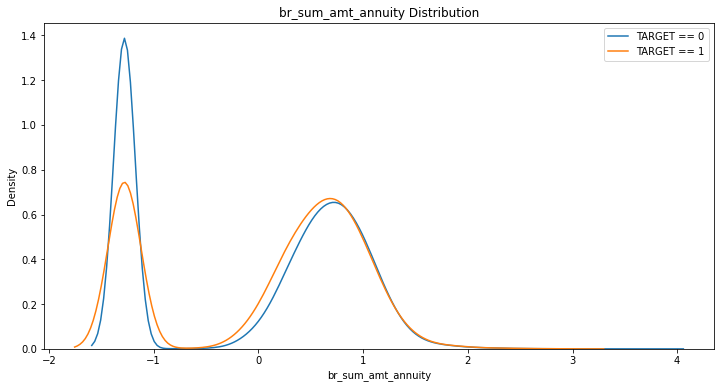

In [522]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

### br_avg_amt_annuity

In [523]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000           -0.001003
br_avg_amt_annuity -0.001003            1.000000

The correlation between br_avg_amt_annuity and the TARGET is -0.0010
Median value for loan that was not repaid = 2799.9047
Median value for loan that was repaid =     1818.5339


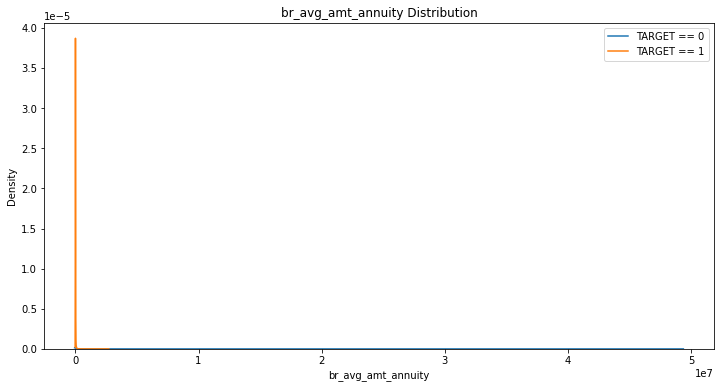

In [524]:
## 特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

In [525]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_annuity'] = pt.transform(app_test[num_cols])

In [526]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000            0.035447
br_avg_amt_annuity  0.035447            1.000000

The correlation between br_avg_amt_annuity and the TARGET is 0.0354
Median value for loan that was not repaid = 0.4820
Median value for loan that was repaid =     0.3529


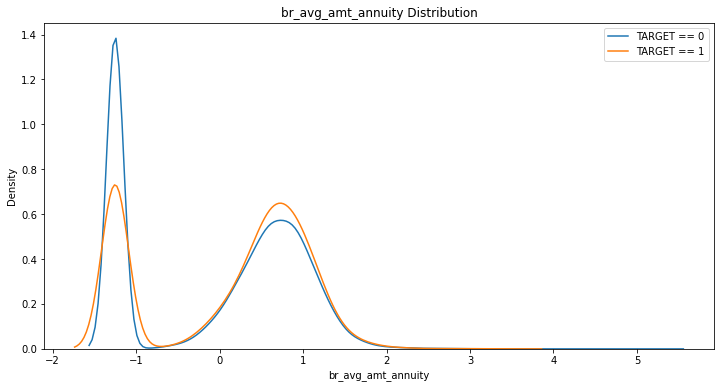

In [527]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

### br_cnt_amt_annuity

In [528]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.040412
br_cnt_amt_annuity -0.040412            1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


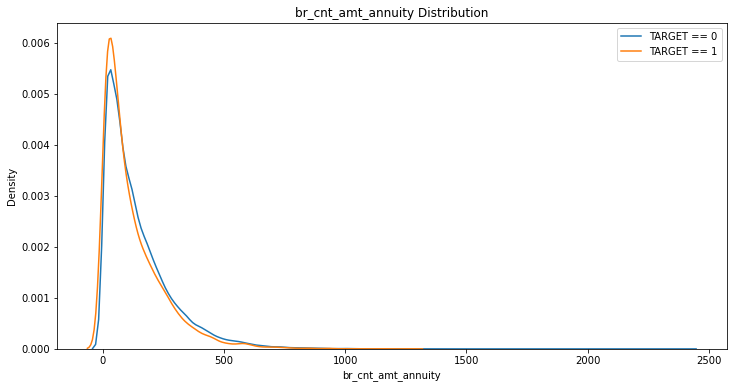

In [529]:
## 特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

In [530]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

In [531]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.052954
br_cnt_amt_annuity -0.052954            1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0530
Median value for loan that was not repaid = -0.1841
Median value for loan that was repaid =     0.0410


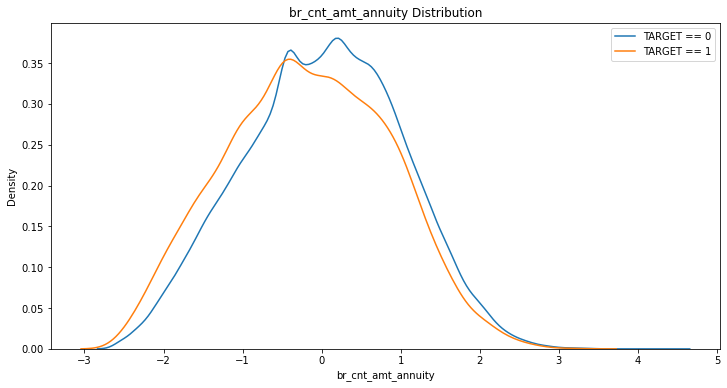

In [532]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

### br_stddev_amt_annuity

In [533]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.000211
br_stddev_amt_annuity  0.000211               1.000000

The correlation between br_stddev_amt_annuity and the TARGET is 0.0002
Median value for loan that was not repaid = 1972.6737
Median value for loan that was repaid =     1162.4758


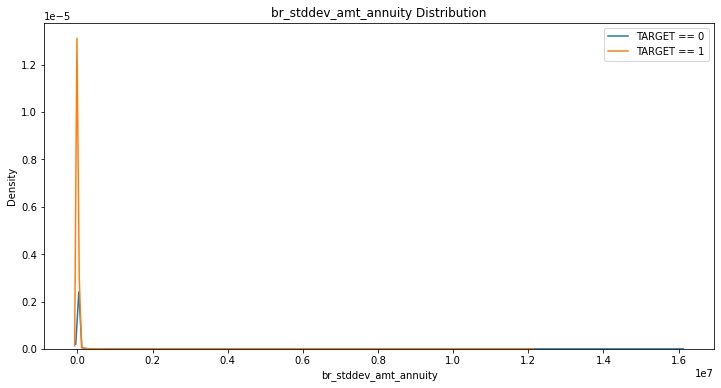

In [534]:
## 特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

In [535]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

In [536]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.024846
br_stddev_amt_annuity  0.024846               1.000000

The correlation between br_stddev_amt_annuity and the TARGET is 0.0248
Median value for loan that was not repaid = 0.6484
Median value for loan that was repaid =     0.5263


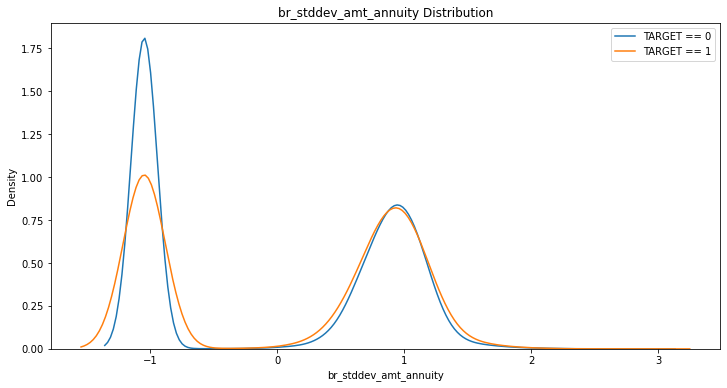

In [537]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

### br_stddev_pop_amt_annuity

In [538]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.000211
br_stddev_pop_amt_annuity  0.000211                   1.000000

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0002
Median value for loan that was not repaid = 1972.6737
Median value for loan that was repaid =     1162.4758


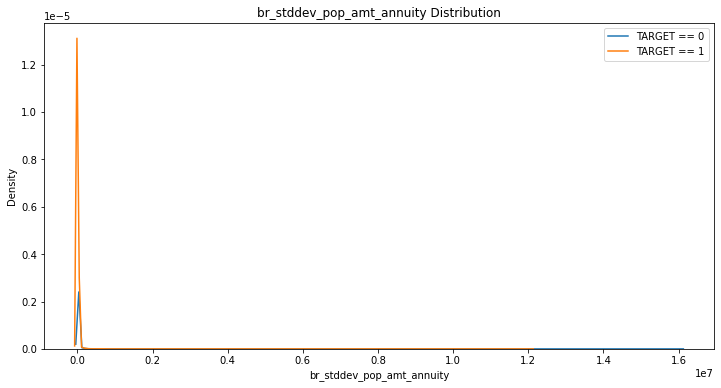

In [539]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

In [540]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [541]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.024846
br_stddev_pop_amt_annuity  0.024846                   1.000000

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0248
Median value for loan that was not repaid = 0.6484
Median value for loan that was repaid =     0.5263


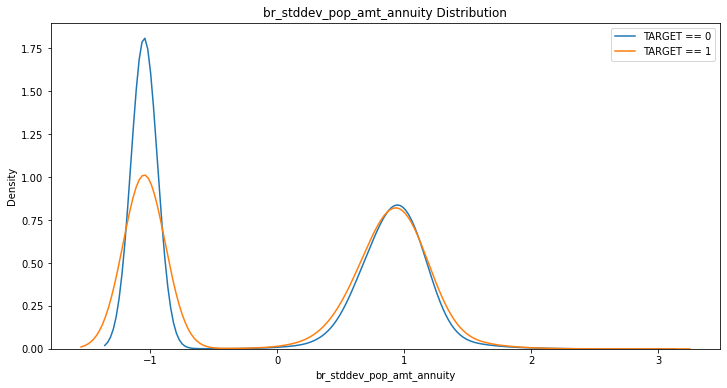

In [542]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

### br_var_pop_amt_annuity

In [543]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.000318
br_var_pop_amt_annuity  0.000318                1.000000

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0003
Median value for loan that was not repaid = 3891441.3524
Median value for loan that was repaid =     1351350.0286


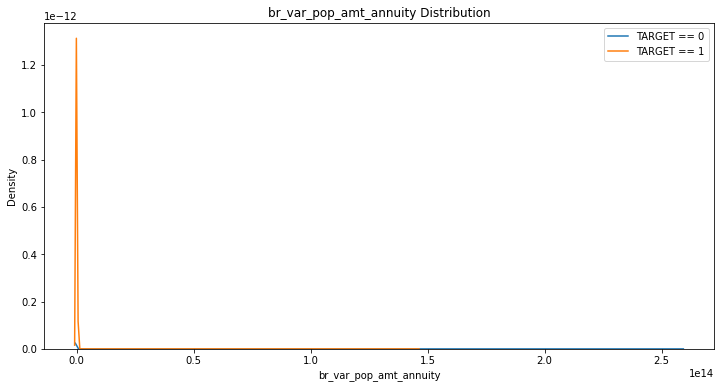

In [544]:
## 特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

In [545]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [546]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.024836
br_var_pop_amt_annuity  0.024836                1.000000

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0248
Median value for loan that was not repaid = 0.6484
Median value for loan that was repaid =     0.5262


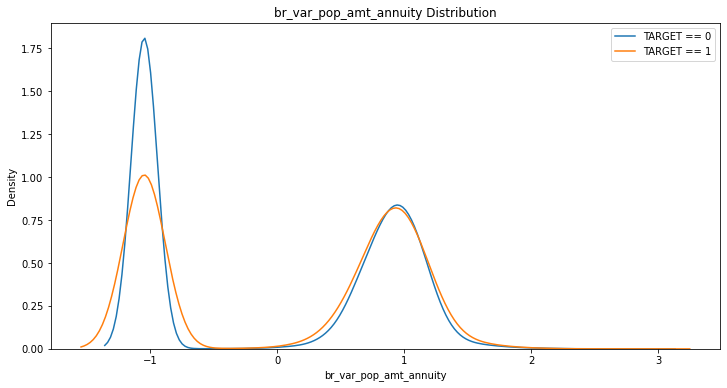

In [547]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

### br_var_samp_amt_annuity

In [548]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.000318
br_var_samp_amt_annuity  0.000318                 1.000000

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0003
Median value for loan that was not repaid = 3966016.6123
Median value for loan that was repaid =     1371602.5501


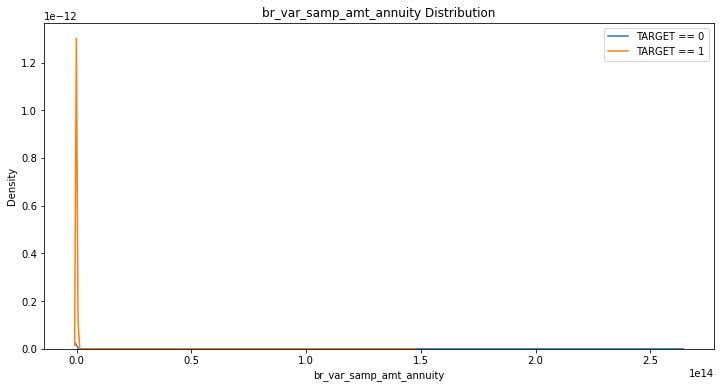

In [549]:
## 特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

In [550]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

In [551]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.024918
br_var_samp_amt_annuity  0.024918                 1.000000

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0249
Median value for loan that was not repaid = 0.6492
Median value for loan that was repaid =     0.5266


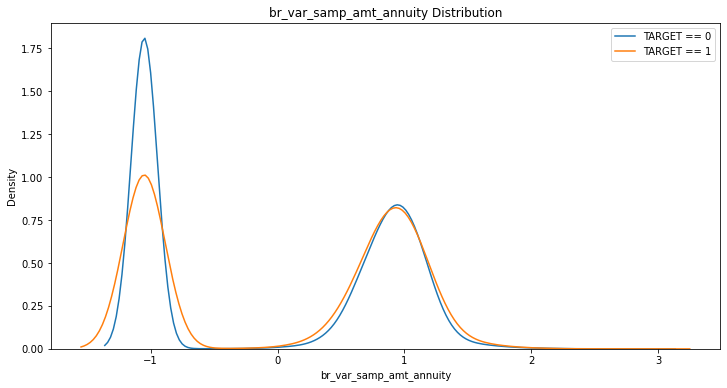

In [552]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

### br_variance_pop_amt_annuity

In [553]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.000318
br_variance_pop_amt_annuity  0.000318                     1.000000

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0003
Median value for loan that was not repaid = 3891441.3524
Median value for loan that was repaid =     1351350.0286


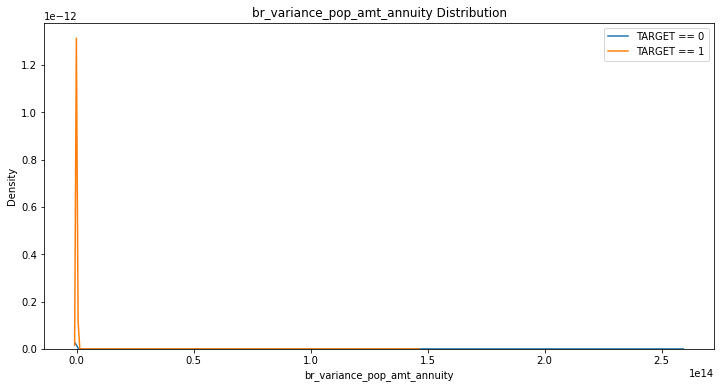

In [554]:
## 特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [555]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [556]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.024836
br_variance_pop_amt_annuity  0.024836                     1.000000

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0248
Median value for loan that was not repaid = 0.6484
Median value for loan that was repaid =     0.5262


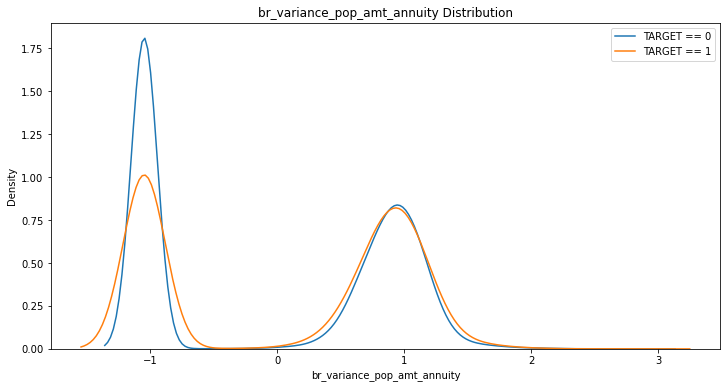

In [557]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [558]:
## CSVをEXPORT

In [559]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_train.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [560]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_test.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [561]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [562]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [563]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[21:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.55498	eval-auc:0.53978
[1]	train-auc:0.56353	eval-auc:0.54506
[2]	train-auc:0.56836	eval-auc:0.54465
[3]	train-auc:0.57341	eval-auc:0.54552
[4]	train-auc:0.57621	eval-auc:0.54923
[5]	train-auc:0.57971	eval-auc:0.54791
[6]	train-auc:0.58219	eval-auc:0.54742
[7]	train-auc:0.58382	eval-auc:0.54637
[8]	train-auc:0.58483	eval-auc:0.54747
[9]	train-auc:0.58727	eval-auc:0.54854
[10]	train-auc:0.58918	eval-auc:0.54701
[11]	train-auc:0.59059	eval-auc:0.54900
[12]	train-auc:0.59276	eval-auc:0.54951
[13]	train-auc:0.59455	eval-auc:0.54876
[14

[12]	train-auc:0.59349	eval-auc:0.55075
[13]	train-auc:0.59581	eval-auc:0.55329
[14]	train-auc:0.59745	eval-auc:0.55371
[15]	train-auc:0.59819	eval-auc:0.55319
[16]	train-auc:0.59997	eval-auc:0.55367
[17]	train-auc:0.60202	eval-auc:0.55385
[18]	train-auc:0.60340	eval-auc:0.55405
[19]	train-auc:0.60429	eval-auc:0.55445
[20]	train-auc:0.60614	eval-auc:0.55316
[21]	train-auc:0.60758	eval-auc:0.55394
[22]	train-auc:0.60974	eval-auc:0.55364
[23]	train-auc:0.61142	eval-auc:0.55447
[24]	train-auc:0.61272	eval-auc:0.55382
[25]	train-auc:0.61391	eval-auc:0.55463
[26]	train-auc:0.61527	eval-auc:0.55374
[27]	train-auc:0.61616	eval-auc:0.55428
[28]	train-auc:0.61779	eval-auc:0.55432
[29]	train-auc:0.61880	eval-auc:0.55461
[30]	train-auc:0.61963	eval-auc:0.55455
[31]	train-auc:0.62190	eval-auc:0.55499
[32]	train-auc:0.62315	eval-auc:0.55405
[33]	train-auc:0.62399	eval-auc:0.55474
[34]	train-auc:0.62471	eval-auc:0.55353
[35]	train-auc:0.62676	eval-auc:0.55412
[36]	train-auc:0.62748	eval-auc:0.55438


In [564]:
app_train = app_train.drop('TARGET', axis=1)

In [565]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [566]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [567]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [568]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[21:49:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.72699	eval-auc:0.71317
[1]	train-auc:0.74120	eval-auc:0.72606
[2]	train-auc:0.75021	eval-auc:0.73112
[3]	train-auc:0.75472	eval-auc:0.73322
[4]	train-auc:0.75918	eval-auc:0.73537
[5]	train-auc:0.76529	eval-auc:0.73868
[6]	train-auc:0.76668	eval-auc:0.73836
[7]	train-auc:0.76768	eval-auc:0.73947
[8]	train-auc:0.76854	eval-auc:0.74027
[9]	train-auc:0.77074	eval-auc:0.74130
[10]	train-auc:0.77341	eval-auc:0.74216
[11]	train-auc:0.77430	eval-auc:0.74206
[12]	train-auc:0.77689	eval-auc:0.74313
[13]	train-auc:0.77776	eval-auc:0.74370
[14

[12]	train-auc:0.77762	eval-auc:0.74086
[13]	train-auc:0.77955	eval-auc:0.74159
[14]	train-auc:0.78127	eval-auc:0.74230
[15]	train-auc:0.78188	eval-auc:0.74191
[16]	train-auc:0.78362	eval-auc:0.74268
[17]	train-auc:0.78466	eval-auc:0.74340
[18]	train-auc:0.78605	eval-auc:0.74376
[19]	train-auc:0.78835	eval-auc:0.74467
[20]	train-auc:0.78955	eval-auc:0.74523
[21]	train-auc:0.79087	eval-auc:0.74558
[22]	train-auc:0.79230	eval-auc:0.74621
[23]	train-auc:0.79285	eval-auc:0.74665
[24]	train-auc:0.79395	eval-auc:0.74757
[25]	train-auc:0.79496	eval-auc:0.74853
[26]	train-auc:0.79625	eval-auc:0.74864
[27]	train-auc:0.79749	eval-auc:0.74870
[28]	train-auc:0.79926	eval-auc:0.74929
[29]	train-auc:0.80042	eval-auc:0.74980
[30]	train-auc:0.80168	eval-auc:0.74978
[31]	train-auc:0.80348	eval-auc:0.75041
[32]	train-auc:0.80495	eval-auc:0.75089
[33]	train-auc:0.80623	eval-auc:0.75096
[34]	train-auc:0.80768	eval-auc:0.75117
[35]	train-auc:0.80881	eval-auc:0.75123
[36]	train-auc:0.80944	eval-auc:0.75140


In [569]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [570]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [571]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [572]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [573]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [574]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [575]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.043754       0.047085       0.058838       0.040733       0.041664
1       0.089707       0.065761       0.097842       0.111332       0.155848
2       0.027904       0.022386       0.025554       0.034689       0.045968
3       0.034953       0.046277       0.039404       0.033998       0.027670
4       0.134653       0.112144       0.117938       0.129119       0.149612

In [576]:
submit_all = app_test[["SK_ID_CURR"]].copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.046415
1      100005  0.104098
2      100013  0.031300
3      100028  0.036461
4      100038  0.128693

In [577]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_br_main_test_60-monthes.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.009283
1      100005  0.020820
2      100013  0.006260
3      100028  0.007292
4      100038  0.025739

In [578]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64